In [1]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.utils as vutils
%matplotlib inline

## Loading data

In [2]:
img_size = 64
batch_size=64
lr = 0.0002
beta1 = 0.5
niter= 25
outf= 'output'

dataset = datasets.CIFAR10( root = 'data',download=True,
                       transform=transforms.Compose([
                           transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size,
                                         shuffle=True)


Files already downloaded and verified


In [3]:
#Size of latnet vector
nz = 100
# Filter size of generator
ngf = 64
# Filter size of discriminator
ndf = 64
# Output image channels
nc = 3

# Network Initialization

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Generator

In [5]:
class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output


netG = _netG()
netG.apply(weights_init)
print(netG)

_netG(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator

In [6]:
class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)


netD = _netD()
netD.apply(weights_init)
print(netD)

_netD(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Defining loss functions

In [7]:

criterion = nn.BCELoss()

input = torch.FloatTensor(batch_size, 3, img_size, img_size)
noise = torch.FloatTensor(batch_size, nz, 1, 1)
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

In [8]:
if torch.cuda.is_available():
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

# Defining optimiser

In [9]:
fixed_noise = Variable(fixed_noise)

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr, betas=(beta1, 0.999))

# Training 

In [10]:
mkdir output

In [11]:

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        if torch.cuda.is_available():
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)

[0/25][0/782] Loss_D: 1.4348 Loss_G: 6.2054 D(x): 0.5771 D(G(z)): 0.4948 / 0.0028
[0/25][1/782] Loss_D: 0.9640 Loss_G: 6.0646 D(x): 0.7210 D(G(z)): 0.3958 / 0.0032
[0/25][2/782] Loss_D: 1.0652 Loss_G: 5.5682 D(x): 0.6648 D(G(z)): 0.3242 / 0.0055
[0/25][3/782] Loss_D: 0.9661 Loss_G: 6.3020 D(x): 0.7228 D(G(z)): 0.3671 / 0.0029
[0/25][4/782] Loss_D: 0.6653 Loss_G: 6.5701 D(x): 0.7541 D(G(z)): 0.2285 / 0.0021
[0/25][5/782] Loss_D: 0.6155 Loss_G: 7.7841 D(x): 0.8334 D(G(z)): 0.2884 / 0.0007
[0/25][6/782] Loss_D: 0.7043 Loss_G: 6.8667 D(x): 0.7553 D(G(z)): 0.1996 / 0.0017
[0/25][7/782] Loss_D: 1.0269 Loss_G: 9.5358 D(x): 0.8392 D(G(z)): 0.4861 / 0.0002
[0/25][8/782] Loss_D: 0.5650 Loss_G: 6.9982 D(x): 0.7157 D(G(z)): 0.0829 / 0.0015
[0/25][9/782] Loss_D: 1.2223 Loss_G: 10.2285 D(x): 0.7950 D(G(z)): 0.5323 / 0.0001
[0/25][10/782] Loss_D: 0.5348 Loss_G: 7.7384 D(x): 0.7123 D(G(z)): 0.0708 / 0.0008
[0/25][11/782] Loss_D: 0.7140 Loss_G: 9.6349 D(x): 0.8500 D(G(z)): 0.3336 / 0.0002
[0/25][12/782

[0/25][100/782] Loss_D: 0.4091 Loss_G: 5.6065 D(x): 0.8928 D(G(z)): 0.2237 / 0.0053
[0/25][101/782] Loss_D: 1.1117 Loss_G: 0.2567 D(x): 0.4543 D(G(z)): 0.0291 / 0.7898
[0/25][102/782] Loss_D: 2.9606 Loss_G: 9.7520 D(x): 0.9883 D(G(z)): 0.9225 / 0.0006
[0/25][103/782] Loss_D: 3.0982 Loss_G: 6.6990 D(x): 0.1329 D(G(z)): 0.0023 / 0.0047
[0/25][104/782] Loss_D: 0.4801 Loss_G: 3.6408 D(x): 0.7125 D(G(z)): 0.0195 / 0.0559
[0/25][105/782] Loss_D: 0.3509 Loss_G: 3.1639 D(x): 0.9333 D(G(z)): 0.2131 / 0.0602
[0/25][106/782] Loss_D: 0.3913 Loss_G: 4.2867 D(x): 0.8964 D(G(z)): 0.2187 / 0.0195
[0/25][107/782] Loss_D: 0.3000 Loss_G: 4.0597 D(x): 0.8438 D(G(z)): 0.0899 / 0.0232
[0/25][108/782] Loss_D: 0.3051 Loss_G: 3.6206 D(x): 0.8641 D(G(z)): 0.1134 / 0.0343
[0/25][109/782] Loss_D: 0.2369 Loss_G: 4.1418 D(x): 0.9095 D(G(z)): 0.1173 / 0.0208
[0/25][110/782] Loss_D: 0.3949 Loss_G: 3.1852 D(x): 0.8211 D(G(z)): 0.1155 / 0.0545
[0/25][111/782] Loss_D: 0.2239 Loss_G: 4.3485 D(x): 0.9366 D(G(z)): 0.1348 /

[0/25][200/782] Loss_D: 0.3977 Loss_G: 9.6172 D(x): 0.9405 D(G(z)): 0.2677 / 0.0001
[0/25][201/782] Loss_D: 0.2538 Loss_G: 8.9561 D(x): 0.8338 D(G(z)): 0.0020 / 0.0003
[0/25][202/782] Loss_D: 0.0814 Loss_G: 6.4005 D(x): 0.9367 D(G(z)): 0.0068 / 0.0031
[0/25][203/782] Loss_D: 0.1793 Loss_G: 5.5882 D(x): 0.9349 D(G(z)): 0.0975 / 0.0048
[0/25][204/782] Loss_D: 0.2393 Loss_G: 8.9116 D(x): 0.9717 D(G(z)): 0.1817 / 0.0002
[0/25][205/782] Loss_D: 0.2154 Loss_G: 7.6971 D(x): 0.8303 D(G(z)): 0.0050 / 0.0007
[0/25][206/782] Loss_D: 0.0858 Loss_G: 5.4445 D(x): 0.9511 D(G(z)): 0.0322 / 0.0062
[0/25][207/782] Loss_D: 0.2857 Loss_G: 10.3967 D(x): 0.9737 D(G(z)): 0.2132 / 0.0000
[0/25][208/782] Loss_D: 0.3396 Loss_G: 8.0302 D(x): 0.7906 D(G(z)): 0.0045 / 0.0006
[0/25][209/782] Loss_D: 0.1137 Loss_G: 5.4274 D(x): 0.9262 D(G(z)): 0.0231 / 0.0063
[0/25][210/782] Loss_D: 0.2818 Loss_G: 10.2272 D(x): 0.9794 D(G(z)): 0.2212 / 0.0001
[0/25][211/782] Loss_D: 0.1181 Loss_G: 9.4432 D(x): 0.9052 D(G(z)): 0.0027

[0/25][301/782] Loss_D: 0.0985 Loss_G: 4.8721 D(x): 0.9571 D(G(z)): 0.0429 / 0.0297
[0/25][302/782] Loss_D: 0.5667 Loss_G: 12.1429 D(x): 0.9843 D(G(z)): 0.3098 / 0.0000
[0/25][303/782] Loss_D: 0.2167 Loss_G: 12.1808 D(x): 0.8573 D(G(z)): 0.0010 / 0.0001
[0/25][304/782] Loss_D: 0.2200 Loss_G: 8.9246 D(x): 0.8619 D(G(z)): 0.0017 / 0.0012
[0/25][305/782] Loss_D: 0.0706 Loss_G: 5.8039 D(x): 0.9752 D(G(z)): 0.0301 / 0.0111
[0/25][306/782] Loss_D: 0.3669 Loss_G: 10.5222 D(x): 0.9883 D(G(z)): 0.2292 / 0.0000
[0/25][307/782] Loss_D: 0.1476 Loss_G: 10.2818 D(x): 0.8979 D(G(z)): 0.0018 / 0.0001
[0/25][308/782] Loss_D: 0.0968 Loss_G: 8.7624 D(x): 0.9332 D(G(z)): 0.0006 / 0.0004
[0/25][309/782] Loss_D: 0.1005 Loss_G: 5.4468 D(x): 0.9604 D(G(z)): 0.0188 / 0.0101
[0/25][310/782] Loss_D: 0.4025 Loss_G: 11.2805 D(x): 0.9732 D(G(z)): 0.2510 / 0.0000
[0/25][311/782] Loss_D: 0.8056 Loss_G: 7.2147 D(x): 0.6501 D(G(z)): 0.0012 / 0.0013
[0/25][312/782] Loss_D: 0.1142 Loss_G: 4.2199 D(x): 0.9770 D(G(z)): 0.0

[0/25][401/782] Loss_D: 0.6786 Loss_G: 6.8072 D(x): 0.6143 D(G(z)): 0.0025 / 0.0040
[0/25][402/782] Loss_D: 0.2884 Loss_G: 2.9606 D(x): 0.8196 D(G(z)): 0.0389 / 0.0913
[0/25][403/782] Loss_D: 0.8245 Loss_G: 7.7721 D(x): 0.9656 D(G(z)): 0.4750 / 0.0009
[0/25][404/782] Loss_D: 0.6225 Loss_G: 5.7111 D(x): 0.7109 D(G(z)): 0.0122 / 0.0060
[0/25][405/782] Loss_D: 0.2469 Loss_G: 3.6575 D(x): 0.8316 D(G(z)): 0.0200 / 0.0486
[0/25][406/782] Loss_D: 0.4449 Loss_G: 4.5882 D(x): 0.9585 D(G(z)): 0.2823 / 0.0163
[0/25][407/782] Loss_D: 0.2593 Loss_G: 4.2331 D(x): 0.8609 D(G(z)): 0.0837 / 0.0232
[0/25][408/782] Loss_D: 0.2736 Loss_G: 4.6480 D(x): 0.9422 D(G(z)): 0.1736 / 0.0175
[0/25][409/782] Loss_D: 0.3653 Loss_G: 4.0564 D(x): 0.8299 D(G(z)): 0.1183 / 0.0312
[0/25][410/782] Loss_D: 0.7413 Loss_G: 6.4964 D(x): 0.8672 D(G(z)): 0.3798 / 0.0026
[0/25][411/782] Loss_D: 1.1584 Loss_G: 1.4515 D(x): 0.4397 D(G(z)): 0.0351 / 0.3239
[0/25][412/782] Loss_D: 2.1045 Loss_G: 11.2117 D(x): 0.9619 D(G(z)): 0.8184 

[0/25][499/782] Loss_D: 0.6881 Loss_G: 3.3930 D(x): 0.8929 D(G(z)): 0.3627 / 0.0611
[0/25][500/782] Loss_D: 0.7253 Loss_G: 6.1599 D(x): 0.8791 D(G(z)): 0.3828 / 0.0041
[0/25][501/782] Loss_D: 1.1134 Loss_G: 3.3310 D(x): 0.4708 D(G(z)): 0.0782 / 0.0733
[0/25][502/782] Loss_D: 0.7366 Loss_G: 5.1020 D(x): 0.9137 D(G(z)): 0.4108 / 0.0086
[0/25][503/782] Loss_D: 0.3182 Loss_G: 5.7950 D(x): 0.8603 D(G(z)): 0.1328 / 0.0056
[0/25][504/782] Loss_D: 0.3803 Loss_G: 3.8822 D(x): 0.7790 D(G(z)): 0.0744 / 0.0328
[0/25][505/782] Loss_D: 0.8080 Loss_G: 7.1742 D(x): 0.8463 D(G(z)): 0.4093 / 0.0022
[0/25][506/782] Loss_D: 1.0131 Loss_G: 3.1833 D(x): 0.4480 D(G(z)): 0.0179 / 0.0798
[0/25][507/782] Loss_D: 0.7204 Loss_G: 7.0558 D(x): 0.9523 D(G(z)): 0.4489 / 0.0021
[0/25][508/782] Loss_D: 0.1426 Loss_G: 5.9479 D(x): 0.9250 D(G(z)): 0.0502 / 0.0096
[0/25][509/782] Loss_D: 0.4338 Loss_G: 6.8901 D(x): 0.8852 D(G(z)): 0.2010 / 0.0030
[0/25][510/782] Loss_D: 0.8353 Loss_G: 2.8397 D(x): 0.5786 D(G(z)): 0.0769 /

[0/25][600/782] Loss_D: 0.2503 Loss_G: 3.4554 D(x): 0.8477 D(G(z)): 0.0630 / 0.0453
[0/25][601/782] Loss_D: 0.6130 Loss_G: 9.4832 D(x): 0.9724 D(G(z)): 0.3971 / 0.0002
[0/25][602/782] Loss_D: 0.7746 Loss_G: 4.1056 D(x): 0.5605 D(G(z)): 0.0120 / 0.0268
[0/25][603/782] Loss_D: 1.1992 Loss_G: 8.9890 D(x): 0.8355 D(G(z)): 0.5591 / 0.0004
[0/25][604/782] Loss_D: 1.8026 Loss_G: 2.2489 D(x): 0.2697 D(G(z)): 0.0162 / 0.1738
[0/25][605/782] Loss_D: 1.2028 Loss_G: 7.0603 D(x): 0.9323 D(G(z)): 0.5623 / 0.0018
[0/25][606/782] Loss_D: 0.4930 Loss_G: 5.3714 D(x): 0.7234 D(G(z)): 0.0581 / 0.0096
[0/25][607/782] Loss_D: 0.3722 Loss_G: 3.4632 D(x): 0.8234 D(G(z)): 0.1250 / 0.0481
[0/25][608/782] Loss_D: 0.8904 Loss_G: 6.3984 D(x): 0.9272 D(G(z)): 0.4802 / 0.0036
[0/25][609/782] Loss_D: 0.8138 Loss_G: 3.6888 D(x): 0.5962 D(G(z)): 0.0441 / 0.0414
[0/25][610/782] Loss_D: 0.8039 Loss_G: 3.0251 D(x): 0.8031 D(G(z)): 0.2355 / 0.0743
[0/25][611/782] Loss_D: 0.9701 Loss_G: 6.5417 D(x): 0.8499 D(G(z)): 0.4861 /

[0/25][698/782] Loss_D: 0.4823 Loss_G: 4.4679 D(x): 0.6711 D(G(z)): 0.0039 / 0.0181
[0/25][699/782] Loss_D: 0.2864 Loss_G: 6.4991 D(x): 0.9632 D(G(z)): 0.2016 / 0.0022
[0/25][700/782] Loss_D: 0.1742 Loss_G: 5.7166 D(x): 0.9078 D(G(z)): 0.0665 / 0.0045
[0/25][701/782] Loss_D: 0.6006 Loss_G: 1.7105 D(x): 0.6612 D(G(z)): 0.0891 / 0.2269
[0/25][702/782] Loss_D: 1.7925 Loss_G: 13.6400 D(x): 0.9933 D(G(z)): 0.7812 / 0.0000
[0/25][703/782] Loss_D: 3.9794 Loss_G: 8.2566 D(x): 0.0447 D(G(z)): 0.0000 / 0.0009
[0/25][704/782] Loss_D: 0.4819 Loss_G: 3.4942 D(x): 0.6980 D(G(z)): 0.0040 / 0.0990
[0/25][705/782] Loss_D: 0.5954 Loss_G: 3.8804 D(x): 0.9590 D(G(z)): 0.3045 / 0.0449
[0/25][706/782] Loss_D: 0.5014 Loss_G: 6.2757 D(x): 0.9796 D(G(z)): 0.2979 / 0.0063
[0/25][707/782] Loss_D: 0.3765 Loss_G: 5.0315 D(x): 0.7803 D(G(z)): 0.0561 / 0.0166
[0/25][708/782] Loss_D: 0.3634 Loss_G: 4.0951 D(x): 0.8449 D(G(z)): 0.1343 / 0.0376
[0/25][709/782] Loss_D: 0.7619 Loss_G: 4.1220 D(x): 0.7593 D(G(z)): 0.2777 

[1/25][17/782] Loss_D: 0.1770 Loss_G: 5.5344 D(x): 0.8702 D(G(z)): 0.0061 / 0.0069
[1/25][18/782] Loss_D: 0.1183 Loss_G: 3.8204 D(x): 0.9306 D(G(z)): 0.0384 / 0.0389
[1/25][19/782] Loss_D: 0.1853 Loss_G: 3.4645 D(x): 0.9451 D(G(z)): 0.1130 / 0.0454
[1/25][20/782] Loss_D: 0.3468 Loss_G: 4.2457 D(x): 0.9328 D(G(z)): 0.2199 / 0.0209
[1/25][21/782] Loss_D: 0.1615 Loss_G: 4.4505 D(x): 0.9259 D(G(z)): 0.0764 / 0.0149
[1/25][22/782] Loss_D: 0.4514 Loss_G: 2.8244 D(x): 0.7578 D(G(z)): 0.1091 / 0.0793
[1/25][23/782] Loss_D: 0.5862 Loss_G: 4.9859 D(x): 0.8041 D(G(z)): 0.2721 / 0.0158
[1/25][24/782] Loss_D: 0.2745 Loss_G: 4.7390 D(x): 0.8580 D(G(z)): 0.0863 / 0.0153
[1/25][25/782] Loss_D: 0.2656 Loss_G: 3.7228 D(x): 0.8500 D(G(z)): 0.0782 / 0.0381
[1/25][26/782] Loss_D: 0.2725 Loss_G: 4.4110 D(x): 0.9000 D(G(z)): 0.1339 / 0.0205
[1/25][27/782] Loss_D: 0.2967 Loss_G: 5.0596 D(x): 0.9122 D(G(z)): 0.1709 / 0.0098
[1/25][28/782] Loss_D: 0.1673 Loss_G: 4.7409 D(x): 0.9084 D(G(z)): 0.0554 / 0.0134
[1/2

[1/25][118/782] Loss_D: 2.5563 Loss_G: 6.7236 D(x): 0.9077 D(G(z)): 0.8879 / 0.0022
[1/25][119/782] Loss_D: 2.5063 Loss_G: 2.8551 D(x): 0.1603 D(G(z)): 0.0106 / 0.0958
[1/25][120/782] Loss_D: 0.5406 Loss_G: 1.8844 D(x): 0.8189 D(G(z)): 0.2420 / 0.2104
[1/25][121/782] Loss_D: 0.9285 Loss_G: 4.0296 D(x): 0.9461 D(G(z)): 0.4875 / 0.0338
[1/25][122/782] Loss_D: 0.4408 Loss_G: 3.8612 D(x): 0.7509 D(G(z)): 0.0903 / 0.0444
[1/25][123/782] Loss_D: 0.3512 Loss_G: 2.9028 D(x): 0.8219 D(G(z)): 0.1001 / 0.0797
[1/25][124/782] Loss_D: 0.4495 Loss_G: 2.8996 D(x): 0.8725 D(G(z)): 0.2217 / 0.0843
[1/25][125/782] Loss_D: 0.2969 Loss_G: 3.7280 D(x): 0.9377 D(G(z)): 0.1823 / 0.0366
[1/25][126/782] Loss_D: 0.2954 Loss_G: 3.4502 D(x): 0.8539 D(G(z)): 0.1102 / 0.0455
[1/25][127/782] Loss_D: 0.3639 Loss_G: 2.6769 D(x): 0.8142 D(G(z)): 0.1157 / 0.0844
[1/25][128/782] Loss_D: 0.6049 Loss_G: 3.5353 D(x): 0.8528 D(G(z)): 0.3110 / 0.0400
[1/25][129/782] Loss_D: 0.4157 Loss_G: 3.3427 D(x): 0.7990 D(G(z)): 0.1327 /

[1/25][218/782] Loss_D: 0.4514 Loss_G: 4.0122 D(x): 0.8444 D(G(z)): 0.2148 / 0.0295
[1/25][219/782] Loss_D: 0.6465 Loss_G: 3.7240 D(x): 0.7706 D(G(z)): 0.2698 / 0.0361
[1/25][220/782] Loss_D: 1.0350 Loss_G: 1.0842 D(x): 0.5072 D(G(z)): 0.1754 / 0.3974
[1/25][221/782] Loss_D: 1.5163 Loss_G: 6.9954 D(x): 0.9442 D(G(z)): 0.7350 / 0.0018
[1/25][222/782] Loss_D: 1.0316 Loss_G: 5.0515 D(x): 0.4473 D(G(z)): 0.0078 / 0.0150
[1/25][223/782] Loss_D: 0.3361 Loss_G: 2.6134 D(x): 0.7938 D(G(z)): 0.0607 / 0.1435
[1/25][224/782] Loss_D: 0.4547 Loss_G: 3.6299 D(x): 0.9711 D(G(z)): 0.3046 / 0.0507
[1/25][225/782] Loss_D: 0.3638 Loss_G: 4.2932 D(x): 0.9345 D(G(z)): 0.2193 / 0.0214
[1/25][226/782] Loss_D: 0.3767 Loss_G: 3.3862 D(x): 0.7882 D(G(z)): 0.0881 / 0.0591
[1/25][227/782] Loss_D: 0.5088 Loss_G: 2.9320 D(x): 0.8298 D(G(z)): 0.2274 / 0.0799
[1/25][228/782] Loss_D: 0.6680 Loss_G: 4.3169 D(x): 0.8117 D(G(z)): 0.3090 / 0.0196
[1/25][229/782] Loss_D: 0.9513 Loss_G: 1.7674 D(x): 0.5262 D(G(z)): 0.1230 /

[1/25][319/782] Loss_D: 0.9774 Loss_G: 1.6534 D(x): 0.5108 D(G(z)): 0.0484 / 0.2556
[1/25][320/782] Loss_D: 1.4314 Loss_G: 7.8774 D(x): 0.9811 D(G(z)): 0.6945 / 0.0007
[1/25][321/782] Loss_D: 1.5613 Loss_G: 2.6826 D(x): 0.3260 D(G(z)): 0.0048 / 0.1109
[1/25][322/782] Loss_D: 0.7533 Loss_G: 4.7599 D(x): 0.9421 D(G(z)): 0.4440 / 0.0148
[1/25][323/782] Loss_D: 0.5008 Loss_G: 4.2265 D(x): 0.7869 D(G(z)): 0.1440 / 0.0241
[1/25][324/782] Loss_D: 0.7948 Loss_G: 2.4862 D(x): 0.6754 D(G(z)): 0.1909 / 0.1374
[1/25][325/782] Loss_D: 1.0151 Loss_G: 5.5242 D(x): 0.8135 D(G(z)): 0.4597 / 0.0074
[1/25][326/782] Loss_D: 0.7163 Loss_G: 2.9411 D(x): 0.6116 D(G(z)): 0.0870 / 0.0921
[1/25][327/782] Loss_D: 0.6433 Loss_G: 4.9042 D(x): 0.9170 D(G(z)): 0.3451 / 0.0125
[1/25][328/782] Loss_D: 0.6026 Loss_G: 3.0885 D(x): 0.6808 D(G(z)): 0.1202 / 0.0724
[1/25][329/782] Loss_D: 0.5976 Loss_G: 4.5142 D(x): 0.8613 D(G(z)): 0.3137 / 0.0172
[1/25][330/782] Loss_D: 0.3608 Loss_G: 4.2958 D(x): 0.8242 D(G(z)): 0.1296 /

[1/25][419/782] Loss_D: 1.1619 Loss_G: 2.7648 D(x): 0.3912 D(G(z)): 0.0093 / 0.1064
[1/25][420/782] Loss_D: 0.6420 Loss_G: 4.6576 D(x): 0.9129 D(G(z)): 0.3696 / 0.0158
[1/25][421/782] Loss_D: 0.3036 Loss_G: 4.1439 D(x): 0.8352 D(G(z)): 0.0895 / 0.0281
[1/25][422/782] Loss_D: 0.3562 Loss_G: 2.6392 D(x): 0.7784 D(G(z)): 0.0583 / 0.0945
[1/25][423/782] Loss_D: 0.6446 Loss_G: 5.8397 D(x): 0.9744 D(G(z)): 0.4081 / 0.0054
[1/25][424/782] Loss_D: 0.4069 Loss_G: 4.1557 D(x): 0.7064 D(G(z)): 0.0163 / 0.0243
[1/25][425/782] Loss_D: 0.3257 Loss_G: 3.2245 D(x): 0.8894 D(G(z)): 0.1568 / 0.0568
[1/25][426/782] Loss_D: 0.4113 Loss_G: 3.8166 D(x): 0.8571 D(G(z)): 0.1881 / 0.0361
[1/25][427/782] Loss_D: 0.3992 Loss_G: 3.3461 D(x): 0.8186 D(G(z)): 0.1541 / 0.0519
[1/25][428/782] Loss_D: 0.3899 Loss_G: 4.3335 D(x): 0.8767 D(G(z)): 0.1957 / 0.0216
[1/25][429/782] Loss_D: 0.4543 Loss_G: 2.8747 D(x): 0.7861 D(G(z)): 0.1466 / 0.0791
[1/25][430/782] Loss_D: 0.5575 Loss_G: 4.6608 D(x): 0.8602 D(G(z)): 0.3008 /

[1/25][518/782] Loss_D: 0.2865 Loss_G: 3.7321 D(x): 0.8946 D(G(z)): 0.1392 / 0.0360
[1/25][519/782] Loss_D: 0.3780 Loss_G: 4.0967 D(x): 0.8684 D(G(z)): 0.1706 / 0.0277
[1/25][520/782] Loss_D: 0.4100 Loss_G: 4.1678 D(x): 0.8546 D(G(z)): 0.1559 / 0.0243
[1/25][521/782] Loss_D: 0.2727 Loss_G: 3.9459 D(x): 0.8541 D(G(z)): 0.0666 / 0.0292
[1/25][522/782] Loss_D: 0.3652 Loss_G: 3.8072 D(x): 0.8650 D(G(z)): 0.1659 / 0.0339
[1/25][523/782] Loss_D: 0.1297 Loss_G: 4.1492 D(x): 0.9440 D(G(z)): 0.0659 / 0.0264
[1/25][524/782] Loss_D: 0.4805 Loss_G: 5.5519 D(x): 0.9568 D(G(z)): 0.3218 / 0.0053
[1/25][525/782] Loss_D: 1.2905 Loss_G: 1.2879 D(x): 0.3511 D(G(z)): 0.0234 / 0.3443
[1/25][526/782] Loss_D: 1.7799 Loss_G: 7.7568 D(x): 0.9806 D(G(z)): 0.7712 / 0.0010
[1/25][527/782] Loss_D: 0.6413 Loss_G: 6.0362 D(x): 0.5927 D(G(z)): 0.0080 / 0.0072
[1/25][528/782] Loss_D: 0.4519 Loss_G: 2.2742 D(x): 0.7122 D(G(z)): 0.0244 / 0.1648
[1/25][529/782] Loss_D: 0.7712 Loss_G: 5.3331 D(x): 0.9375 D(G(z)): 0.4476 /

[1/25][617/782] Loss_D: 0.3984 Loss_G: 3.3667 D(x): 0.8496 D(G(z)): 0.1774 / 0.0510
[1/25][618/782] Loss_D: 0.4797 Loss_G: 4.7200 D(x): 0.8707 D(G(z)): 0.2427 / 0.0141
[1/25][619/782] Loss_D: 0.5369 Loss_G: 2.0081 D(x): 0.6703 D(G(z)): 0.0660 / 0.1830
[1/25][620/782] Loss_D: 0.7587 Loss_G: 5.1920 D(x): 0.8978 D(G(z)): 0.4126 / 0.0085
[1/25][621/782] Loss_D: 0.3547 Loss_G: 4.1220 D(x): 0.7618 D(G(z)): 0.0335 / 0.0303
[1/25][622/782] Loss_D: 0.2873 Loss_G: 2.9489 D(x): 0.8651 D(G(z)): 0.1069 / 0.0811
[1/25][623/782] Loss_D: 0.6452 Loss_G: 5.6017 D(x): 0.9135 D(G(z)): 0.3498 / 0.0071
[1/25][624/782] Loss_D: 0.5436 Loss_G: 3.3333 D(x): 0.6740 D(G(z)): 0.0391 / 0.0669
[1/25][625/782] Loss_D: 0.6731 Loss_G: 5.9535 D(x): 0.9183 D(G(z)): 0.3750 / 0.0048
[1/25][626/782] Loss_D: 0.9975 Loss_G: 1.6790 D(x): 0.5056 D(G(z)): 0.0242 / 0.2489
[1/25][627/782] Loss_D: 1.0245 Loss_G: 7.8916 D(x): 0.9857 D(G(z)): 0.5643 / 0.0006
[1/25][628/782] Loss_D: 1.0009 Loss_G: 3.1743 D(x): 0.4613 D(G(z)): 0.0054 /

[1/25][718/782] Loss_D: 0.5005 Loss_G: 2.5492 D(x): 0.8841 D(G(z)): 0.2562 / 0.1139
[1/25][719/782] Loss_D: 0.5854 Loss_G: 4.7859 D(x): 0.8906 D(G(z)): 0.3111 / 0.0143
[1/25][720/782] Loss_D: 0.3710 Loss_G: 3.6968 D(x): 0.7793 D(G(z)): 0.0793 / 0.0430
[1/25][721/782] Loss_D: 0.4399 Loss_G: 2.8151 D(x): 0.7884 D(G(z)): 0.1371 / 0.1003
[1/25][722/782] Loss_D: 0.4036 Loss_G: 4.6100 D(x): 0.9362 D(G(z)): 0.2603 / 0.0148
[1/25][723/782] Loss_D: 0.3545 Loss_G: 3.6380 D(x): 0.7759 D(G(z)): 0.0551 / 0.0452
[1/25][724/782] Loss_D: 0.4299 Loss_G: 4.0258 D(x): 0.8775 D(G(z)): 0.2295 / 0.0277
[1/25][725/782] Loss_D: 0.2871 Loss_G: 3.8908 D(x): 0.8626 D(G(z)): 0.1063 / 0.0305
[1/25][726/782] Loss_D: 0.2019 Loss_G: 3.5766 D(x): 0.8929 D(G(z)): 0.0749 / 0.0402
[1/25][727/782] Loss_D: 0.2248 Loss_G: 3.5568 D(x): 0.8895 D(G(z)): 0.0899 / 0.0419
[1/25][728/782] Loss_D: 0.3466 Loss_G: 4.5043 D(x): 0.9111 D(G(z)): 0.1968 / 0.0173
[1/25][729/782] Loss_D: 0.4787 Loss_G: 2.7790 D(x): 0.7097 D(G(z)): 0.0611 /

[2/25][37/782] Loss_D: 0.8472 Loss_G: 1.0951 D(x): 0.5900 D(G(z)): 0.1259 / 0.4118
[2/25][38/782] Loss_D: 1.4513 Loss_G: 9.2660 D(x): 0.9896 D(G(z)): 0.7063 / 0.0002
[2/25][39/782] Loss_D: 2.2122 Loss_G: 3.9878 D(x): 0.1877 D(G(z)): 0.0013 / 0.0525
[2/25][40/782] Loss_D: 0.4343 Loss_G: 3.5990 D(x): 0.9237 D(G(z)): 0.2430 / 0.0551
[2/25][41/782] Loss_D: 0.3817 Loss_G: 5.8817 D(x): 0.9307 D(G(z)): 0.2197 / 0.0047
[2/25][42/782] Loss_D: 0.2903 Loss_G: 4.4071 D(x): 0.8214 D(G(z)): 0.0439 / 0.0313
[2/25][43/782] Loss_D: 0.3002 Loss_G: 3.5902 D(x): 0.8888 D(G(z)): 0.1334 / 0.0495
[2/25][44/782] Loss_D: 0.5008 Loss_G: 3.3705 D(x): 0.7963 D(G(z)): 0.1638 / 0.0567
[2/25][45/782] Loss_D: 0.7603 Loss_G: 5.4101 D(x): 0.8230 D(G(z)): 0.3550 / 0.0071
[2/25][46/782] Loss_D: 1.0609 Loss_G: 0.8450 D(x): 0.4857 D(G(z)): 0.0837 / 0.5385
[2/25][47/782] Loss_D: 1.8136 Loss_G: 9.0654 D(x): 0.9714 D(G(z)): 0.7571 / 0.0003
[2/25][48/782] Loss_D: 1.5568 Loss_G: 2.9533 D(x): 0.3283 D(G(z)): 0.0094 / 0.1091
[2/2

[2/25][138/782] Loss_D: 0.3828 Loss_G: 3.4635 D(x): 0.8386 D(G(z)): 0.1621 / 0.0485
[2/25][139/782] Loss_D: 0.3632 Loss_G: 4.0343 D(x): 0.8847 D(G(z)): 0.1960 / 0.0231
[2/25][140/782] Loss_D: 0.3736 Loss_G: 3.1419 D(x): 0.7624 D(G(z)): 0.0580 / 0.0617
[2/25][141/782] Loss_D: 0.3931 Loss_G: 3.8595 D(x): 0.9179 D(G(z)): 0.2377 / 0.0312
[2/25][142/782] Loss_D: 0.2059 Loss_G: 3.9967 D(x): 0.8775 D(G(z)): 0.0565 / 0.0293
[2/25][143/782] Loss_D: 0.4056 Loss_G: 3.7825 D(x): 0.8851 D(G(z)): 0.2003 / 0.0391
[2/25][144/782] Loss_D: 0.5426 Loss_G: 1.9493 D(x): 0.6794 D(G(z)): 0.0873 / 0.1816
[2/25][145/782] Loss_D: 0.6195 Loss_G: 4.7413 D(x): 0.9217 D(G(z)): 0.3689 / 0.0127
[2/25][146/782] Loss_D: 0.2046 Loss_G: 4.4199 D(x): 0.8886 D(G(z)): 0.0670 / 0.0177
[2/25][147/782] Loss_D: 0.2644 Loss_G: 3.3218 D(x): 0.8442 D(G(z)): 0.0729 / 0.0502
[2/25][148/782] Loss_D: 0.3464 Loss_G: 3.8325 D(x): 0.8816 D(G(z)): 0.1807 / 0.0277
[2/25][149/782] Loss_D: 0.3319 Loss_G: 3.4346 D(x): 0.8301 D(G(z)): 0.1154 /

[2/25][237/782] Loss_D: 0.2344 Loss_G: 3.8987 D(x): 0.9326 D(G(z)): 0.1356 / 0.0329
[2/25][238/782] Loss_D: 0.2522 Loss_G: 3.9712 D(x): 0.8972 D(G(z)): 0.1146 / 0.0320
[2/25][239/782] Loss_D: 0.4407 Loss_G: 2.5852 D(x): 0.7751 D(G(z)): 0.1433 / 0.1006
[2/25][240/782] Loss_D: 0.2988 Loss_G: 3.9633 D(x): 0.9144 D(G(z)): 0.1721 / 0.0268
[2/25][241/782] Loss_D: 0.2867 Loss_G: 3.8042 D(x): 0.8640 D(G(z)): 0.1119 / 0.0336
[2/25][242/782] Loss_D: 0.5220 Loss_G: 2.8393 D(x): 0.7695 D(G(z)): 0.1846 / 0.0930
[2/25][243/782] Loss_D: 0.5005 Loss_G: 3.0331 D(x): 0.7881 D(G(z)): 0.2040 / 0.0633
[2/25][244/782] Loss_D: 0.2290 Loss_G: 3.9385 D(x): 0.9076 D(G(z)): 0.1108 / 0.0317
[2/25][245/782] Loss_D: 0.3099 Loss_G: 3.1146 D(x): 0.8423 D(G(z)): 0.1139 / 0.0661
[2/25][246/782] Loss_D: 0.4772 Loss_G: 3.5662 D(x): 0.8383 D(G(z)): 0.2167 / 0.0414
[2/25][247/782] Loss_D: 0.3035 Loss_G: 4.1891 D(x): 0.8969 D(G(z)): 0.1606 / 0.0226
[2/25][248/782] Loss_D: 0.5227 Loss_G: 1.6489 D(x): 0.6696 D(G(z)): 0.0495 /

[2/25][336/782] Loss_D: 0.6905 Loss_G: 1.8923 D(x): 0.6298 D(G(z)): 0.1058 / 0.2030
[2/25][337/782] Loss_D: 0.7895 Loss_G: 5.4361 D(x): 0.8875 D(G(z)): 0.4289 / 0.0074
[2/25][338/782] Loss_D: 0.8754 Loss_G: 0.9326 D(x): 0.5061 D(G(z)): 0.0435 / 0.4481
[2/25][339/782] Loss_D: 1.2450 Loss_G: 6.4113 D(x): 0.9580 D(G(z)): 0.6279 / 0.0035
[2/25][340/782] Loss_D: 0.6668 Loss_G: 3.5420 D(x): 0.6336 D(G(z)): 0.0581 / 0.0519
[2/25][341/782] Loss_D: 0.3069 Loss_G: 2.6341 D(x): 0.8334 D(G(z)): 0.0889 / 0.1098
[2/25][342/782] Loss_D: 0.8894 Loss_G: 6.2763 D(x): 0.9351 D(G(z)): 0.4902 / 0.0030
[2/25][343/782] Loss_D: 0.6757 Loss_G: 4.5539 D(x): 0.5841 D(G(z)): 0.0104 / 0.0218
[2/25][344/782] Loss_D: 0.4912 Loss_G: 1.5911 D(x): 0.7103 D(G(z)): 0.0736 / 0.2668
[2/25][345/782] Loss_D: 1.4239 Loss_G: 5.8638 D(x): 0.9309 D(G(z)): 0.6630 / 0.0070
[2/25][346/782] Loss_D: 0.4460 Loss_G: 5.1964 D(x): 0.7363 D(G(z)): 0.0431 / 0.0181
[2/25][347/782] Loss_D: 0.6426 Loss_G: 1.4447 D(x): 0.6379 D(G(z)): 0.0583 /

[2/25][436/782] Loss_D: 0.5821 Loss_G: 4.2618 D(x): 0.8844 D(G(z)): 0.2960 / 0.0247
[2/25][437/782] Loss_D: 0.9461 Loss_G: 1.6166 D(x): 0.4714 D(G(z)): 0.0317 / 0.2692
[2/25][438/782] Loss_D: 0.9842 Loss_G: 4.3333 D(x): 0.9495 D(G(z)): 0.5296 / 0.0202
[2/25][439/782] Loss_D: 0.4028 Loss_G: 3.7939 D(x): 0.8048 D(G(z)): 0.1183 / 0.0364
[2/25][440/782] Loss_D: 0.4392 Loss_G: 2.3561 D(x): 0.7260 D(G(z)): 0.0655 / 0.1329
[2/25][441/782] Loss_D: 0.4644 Loss_G: 2.8251 D(x): 0.8566 D(G(z)): 0.2333 / 0.0796
[2/25][442/782] Loss_D: 0.4744 Loss_G: 3.5914 D(x): 0.8729 D(G(z)): 0.2520 / 0.0415
[2/25][443/782] Loss_D: 0.6541 Loss_G: 1.7951 D(x): 0.6494 D(G(z)): 0.1204 / 0.2200
[2/25][444/782] Loss_D: 0.8122 Loss_G: 4.6315 D(x): 0.9186 D(G(z)): 0.4677 / 0.0140
[2/25][445/782] Loss_D: 0.6597 Loss_G: 2.9312 D(x): 0.5990 D(G(z)): 0.0394 / 0.0780
[2/25][446/782] Loss_D: 0.3469 Loss_G: 2.3127 D(x): 0.8632 D(G(z)): 0.1564 / 0.1348
[2/25][447/782] Loss_D: 0.4493 Loss_G: 3.7756 D(x): 0.9083 D(G(z)): 0.2760 /

[2/25][537/782] Loss_D: 0.6864 Loss_G: 3.1266 D(x): 0.5846 D(G(z)): 0.0370 / 0.0736
[2/25][538/782] Loss_D: 0.3378 Loss_G: 2.7565 D(x): 0.8753 D(G(z)): 0.1437 / 0.0909
[2/25][539/782] Loss_D: 0.6359 Loss_G: 5.7602 D(x): 0.9234 D(G(z)): 0.3840 / 0.0048
[2/25][540/782] Loss_D: 0.4608 Loss_G: 3.8910 D(x): 0.6806 D(G(z)): 0.0175 / 0.0385
[2/25][541/782] Loss_D: 0.5472 Loss_G: 2.1994 D(x): 0.7736 D(G(z)): 0.1834 / 0.1614
[2/25][542/782] Loss_D: 0.7433 Loss_G: 6.0348 D(x): 0.9405 D(G(z)): 0.4264 / 0.0035
[2/25][543/782] Loss_D: 0.6504 Loss_G: 2.8146 D(x): 0.6214 D(G(z)): 0.0317 / 0.0858
[2/25][544/782] Loss_D: 0.4836 Loss_G: 4.6370 D(x): 0.9189 D(G(z)): 0.2831 / 0.0168
[2/25][545/782] Loss_D: 0.3062 Loss_G: 3.4889 D(x): 0.8115 D(G(z)): 0.0608 / 0.0384
[2/25][546/782] Loss_D: 0.2398 Loss_G: 3.3763 D(x): 0.9034 D(G(z)): 0.1176 / 0.0482
[2/25][547/782] Loss_D: 0.3343 Loss_G: 4.1235 D(x): 0.9158 D(G(z)): 0.1961 / 0.0245
[2/25][548/782] Loss_D: 0.3671 Loss_G: 3.0375 D(x): 0.7785 D(G(z)): 0.0694 /

[2/25][636/782] Loss_D: 0.5300 Loss_G: 2.4381 D(x): 0.7228 D(G(z)): 0.1065 / 0.1277
[2/25][637/782] Loss_D: 0.7125 Loss_G: 4.6549 D(x): 0.8203 D(G(z)): 0.3416 / 0.0140
[2/25][638/782] Loss_D: 0.3555 Loss_G: 4.1289 D(x): 0.8308 D(G(z)): 0.1263 / 0.0294
[2/25][639/782] Loss_D: 0.7414 Loss_G: 1.3751 D(x): 0.6152 D(G(z)): 0.1335 / 0.3208
[2/25][640/782] Loss_D: 0.7956 Loss_G: 7.1774 D(x): 0.9605 D(G(z)): 0.4669 / 0.0013
[2/25][641/782] Loss_D: 0.7600 Loss_G: 2.9408 D(x): 0.5749 D(G(z)): 0.0081 / 0.0938
[2/25][642/782] Loss_D: 0.4577 Loss_G: 4.3250 D(x): 0.9211 D(G(z)): 0.2712 / 0.0196
[2/25][643/782] Loss_D: 0.5034 Loss_G: 3.0885 D(x): 0.7647 D(G(z)): 0.1337 / 0.0864
[2/25][644/782] Loss_D: 0.3882 Loss_G: 4.4075 D(x): 0.9088 D(G(z)): 0.2167 / 0.0237
[2/25][645/782] Loss_D: 0.4718 Loss_G: 2.9714 D(x): 0.7491 D(G(z)): 0.1017 / 0.0863
[2/25][646/782] Loss_D: 0.3948 Loss_G: 3.1237 D(x): 0.8545 D(G(z)): 0.1853 / 0.0644
[2/25][647/782] Loss_D: 0.6079 Loss_G: 4.7518 D(x): 0.8346 D(G(z)): 0.3043 /

[2/25][735/782] Loss_D: 0.3952 Loss_G: 3.7894 D(x): 0.8441 D(G(z)): 0.1651 / 0.0365
[2/25][736/782] Loss_D: 0.6900 Loss_G: 2.8149 D(x): 0.7286 D(G(z)): 0.2353 / 0.0854
[2/25][737/782] Loss_D: 0.5071 Loss_G: 3.8646 D(x): 0.8356 D(G(z)): 0.2266 / 0.0387
[2/25][738/782] Loss_D: 0.3579 Loss_G: 3.5569 D(x): 0.8266 D(G(z)): 0.1259 / 0.0458
[2/25][739/782] Loss_D: 0.4263 Loss_G: 3.0039 D(x): 0.8191 D(G(z)): 0.1583 / 0.0708
[2/25][740/782] Loss_D: 0.4367 Loss_G: 2.8003 D(x): 0.8067 D(G(z)): 0.1622 / 0.0885
[2/25][741/782] Loss_D: 0.5121 Loss_G: 4.5932 D(x): 0.9270 D(G(z)): 0.3063 / 0.0168
[2/25][742/782] Loss_D: 1.3860 Loss_G: 0.8470 D(x): 0.3721 D(G(z)): 0.0781 / 0.4808
[2/25][743/782] Loss_D: 1.7365 Loss_G: 6.7038 D(x): 0.9869 D(G(z)): 0.7640 / 0.0026
[2/25][744/782] Loss_D: 1.2534 Loss_G: 2.3245 D(x): 0.3821 D(G(z)): 0.0311 / 0.1872
[2/25][745/782] Loss_D: 0.5288 Loss_G: 3.5346 D(x): 0.9119 D(G(z)): 0.2816 / 0.0451
[2/25][746/782] Loss_D: 0.3682 Loss_G: 4.5205 D(x): 0.8997 D(G(z)): 0.1927 /

[3/25][54/782] Loss_D: 0.6903 Loss_G: 2.2256 D(x): 0.6392 D(G(z)): 0.1356 / 0.1579
[3/25][55/782] Loss_D: 0.4999 Loss_G: 3.3900 D(x): 0.8908 D(G(z)): 0.2821 / 0.0489
[3/25][56/782] Loss_D: 0.3606 Loss_G: 3.3097 D(x): 0.8281 D(G(z)): 0.1267 / 0.0572
[3/25][57/782] Loss_D: 0.7627 Loss_G: 2.0864 D(x): 0.6992 D(G(z)): 0.2802 / 0.1590
[3/25][58/782] Loss_D: 0.7835 Loss_G: 5.3593 D(x): 0.8657 D(G(z)): 0.4238 / 0.0071
[3/25][59/782] Loss_D: 1.7660 Loss_G: 0.5131 D(x): 0.2259 D(G(z)): 0.0144 / 0.6467
[3/25][60/782] Loss_D: 1.4166 Loss_G: 6.2333 D(x): 0.9735 D(G(z)): 0.6854 / 0.0038
[3/25][61/782] Loss_D: 1.4843 Loss_G: 1.2181 D(x): 0.3220 D(G(z)): 0.0177 / 0.3893
[3/25][62/782] Loss_D: 0.7360 Loss_G: 3.8621 D(x): 0.9656 D(G(z)): 0.4264 / 0.0374
[3/25][63/782] Loss_D: 0.4252 Loss_G: 3.4889 D(x): 0.8018 D(G(z)): 0.1368 / 0.0488
[3/25][64/782] Loss_D: 0.4822 Loss_G: 2.0931 D(x): 0.7603 D(G(z)): 0.1349 / 0.1706
[3/25][65/782] Loss_D: 0.4403 Loss_G: 3.9428 D(x): 0.9619 D(G(z)): 0.2806 / 0.0316
[3/2

[3/25][154/782] Loss_D: 0.4642 Loss_G: 3.2422 D(x): 0.8782 D(G(z)): 0.2408 / 0.0578
[3/25][155/782] Loss_D: 0.6032 Loss_G: 4.7619 D(x): 0.8791 D(G(z)): 0.3433 / 0.0111
[3/25][156/782] Loss_D: 0.8553 Loss_G: 1.5514 D(x): 0.5014 D(G(z)): 0.0350 / 0.2626
[3/25][157/782] Loss_D: 0.6158 Loss_G: 4.1659 D(x): 0.9326 D(G(z)): 0.3758 / 0.0224
[3/25][158/782] Loss_D: 0.4584 Loss_G: 3.1272 D(x): 0.7578 D(G(z)): 0.1074 / 0.0645
[3/25][159/782] Loss_D: 0.4111 Loss_G: 3.8633 D(x): 0.8989 D(G(z)): 0.2291 / 0.0304
[3/25][160/782] Loss_D: 0.4996 Loss_G: 2.5117 D(x): 0.7036 D(G(z)): 0.0797 / 0.1307
[3/25][161/782] Loss_D: 0.5643 Loss_G: 3.2459 D(x): 0.8647 D(G(z)): 0.2969 / 0.0550
[3/25][162/782] Loss_D: 0.3745 Loss_G: 3.9367 D(x): 0.8757 D(G(z)): 0.1842 / 0.0298
[3/25][163/782] Loss_D: 0.4154 Loss_G: 2.7675 D(x): 0.7469 D(G(z)): 0.0761 / 0.0934
[3/25][164/782] Loss_D: 0.4101 Loss_G: 3.4121 D(x): 0.9003 D(G(z)): 0.2433 / 0.0439
[3/25][165/782] Loss_D: 0.4829 Loss_G: 2.9684 D(x): 0.7947 D(G(z)): 0.1810 /

[3/25][254/782] Loss_D: 0.3498 Loss_G: 3.0123 D(x): 0.8251 D(G(z)): 0.1288 / 0.0634
[3/25][255/782] Loss_D: 0.5613 Loss_G: 2.3076 D(x): 0.7617 D(G(z)): 0.2109 / 0.1261
[3/25][256/782] Loss_D: 0.6069 Loss_G: 3.8940 D(x): 0.8472 D(G(z)): 0.3190 / 0.0295
[3/25][257/782] Loss_D: 0.5159 Loss_G: 2.5504 D(x): 0.7163 D(G(z)): 0.1133 / 0.0963
[3/25][258/782] Loss_D: 0.3363 Loss_G: 3.0417 D(x): 0.8824 D(G(z)): 0.1728 / 0.0617
[3/25][259/782] Loss_D: 0.2924 Loss_G: 3.3178 D(x): 0.8826 D(G(z)): 0.1427 / 0.0491
[3/25][260/782] Loss_D: 0.3421 Loss_G: 3.3243 D(x): 0.8748 D(G(z)): 0.1740 / 0.0505
[3/25][261/782] Loss_D: 0.3578 Loss_G: 2.4462 D(x): 0.7639 D(G(z)): 0.0651 / 0.1123
[3/25][262/782] Loss_D: 0.4336 Loss_G: 3.9375 D(x): 0.9340 D(G(z)): 0.2853 / 0.0255
[3/25][263/782] Loss_D: 0.5545 Loss_G: 1.8241 D(x): 0.6726 D(G(z)): 0.0832 / 0.2017
[3/25][264/782] Loss_D: 0.6476 Loss_G: 5.1815 D(x): 0.9500 D(G(z)): 0.4025 / 0.0088
[3/25][265/782] Loss_D: 0.6327 Loss_G: 2.4573 D(x): 0.5942 D(G(z)): 0.0381 /

[3/25][355/782] Loss_D: 0.7071 Loss_G: 3.0569 D(x): 0.7007 D(G(z)): 0.2185 / 0.0668
[3/25][356/782] Loss_D: 0.6362 Loss_G: 2.2260 D(x): 0.7214 D(G(z)): 0.1960 / 0.1554
[3/25][357/782] Loss_D: 0.3705 Loss_G: 2.8526 D(x): 0.8511 D(G(z)): 0.1640 / 0.0818
[3/25][358/782] Loss_D: 0.7025 Loss_G: 4.0924 D(x): 0.8547 D(G(z)): 0.3723 / 0.0220
[3/25][359/782] Loss_D: 0.7842 Loss_G: 2.3677 D(x): 0.6247 D(G(z)): 0.1950 / 0.1248
[3/25][360/782] Loss_D: 0.6841 Loss_G: 3.2524 D(x): 0.7802 D(G(z)): 0.2895 / 0.0678
[3/25][361/782] Loss_D: 0.5645 Loss_G: 2.4282 D(x): 0.7317 D(G(z)): 0.1543 / 0.1206
[3/25][362/782] Loss_D: 0.8963 Loss_G: 4.8181 D(x): 0.8761 D(G(z)): 0.4357 / 0.0149
[3/25][363/782] Loss_D: 0.6968 Loss_G: 2.6094 D(x): 0.5863 D(G(z)): 0.0525 / 0.1181
[3/25][364/782] Loss_D: 0.4910 Loss_G: 2.6685 D(x): 0.8499 D(G(z)): 0.2014 / 0.1067
[3/25][365/782] Loss_D: 0.8219 Loss_G: 3.8552 D(x): 0.8081 D(G(z)): 0.3828 / 0.0272
[3/25][366/782] Loss_D: 0.4669 Loss_G: 3.2434 D(x): 0.7670 D(G(z)): 0.1270 /

[3/25][455/782] Loss_D: 0.3767 Loss_G: 2.6839 D(x): 0.8121 D(G(z)): 0.1296 / 0.0961
[3/25][456/782] Loss_D: 0.6584 Loss_G: 5.9881 D(x): 0.9306 D(G(z)): 0.3938 / 0.0034
[3/25][457/782] Loss_D: 1.1387 Loss_G: 0.6010 D(x): 0.4098 D(G(z)): 0.0573 / 0.5978
[3/25][458/782] Loss_D: 2.2627 Loss_G: 9.0685 D(x): 0.9196 D(G(z)): 0.8084 / 0.0004
[3/25][459/782] Loss_D: 3.0507 Loss_G: 0.4278 D(x): 0.0845 D(G(z)): 0.0021 / 0.6935
[3/25][460/782] Loss_D: 1.8188 Loss_G: 7.1175 D(x): 0.9317 D(G(z)): 0.7439 / 0.0016
[3/25][461/782] Loss_D: 3.5593 Loss_G: 0.2895 D(x): 0.0574 D(G(z)): 0.0096 / 0.7723
[3/25][462/782] Loss_D: 1.9630 Loss_G: 3.9860 D(x): 0.9732 D(G(z)): 0.7939 / 0.0316
[3/25][463/782] Loss_D: 1.4555 Loss_G: 1.2913 D(x): 0.3857 D(G(z)): 0.2124 / 0.3661
[3/25][464/782] Loss_D: 1.3804 Loss_G: 3.5573 D(x): 0.7547 D(G(z)): 0.5565 / 0.0775
[3/25][465/782] Loss_D: 1.5655 Loss_G: 2.1173 D(x): 0.4917 D(G(z)): 0.3506 / 0.2497
[3/25][466/782] Loss_D: 1.5784 Loss_G: 1.0709 D(x): 0.5094 D(G(z)): 0.3572 /

[3/25][556/782] Loss_D: 0.6089 Loss_G: 3.7332 D(x): 0.8865 D(G(z)): 0.3424 / 0.0310
[3/25][557/782] Loss_D: 0.5320 Loss_G: 2.9174 D(x): 0.7394 D(G(z)): 0.1667 / 0.0732
[3/25][558/782] Loss_D: 0.5621 Loss_G: 2.3934 D(x): 0.7395 D(G(z)): 0.1768 / 0.1214
[3/25][559/782] Loss_D: 0.6142 Loss_G: 3.9400 D(x): 0.8822 D(G(z)): 0.3502 / 0.0258
[3/25][560/782] Loss_D: 0.6825 Loss_G: 2.4635 D(x): 0.6354 D(G(z)): 0.1115 / 0.1166
[3/25][561/782] Loss_D: 0.6058 Loss_G: 3.2125 D(x): 0.8204 D(G(z)): 0.2978 / 0.0545
[3/25][562/782] Loss_D: 0.5930 Loss_G: 2.4536 D(x): 0.6920 D(G(z)): 0.1418 / 0.1096
[3/25][563/782] Loss_D: 0.4664 Loss_G: 4.2314 D(x): 0.9283 D(G(z)): 0.2906 / 0.0208
[3/25][564/782] Loss_D: 0.3874 Loss_G: 3.1126 D(x): 0.7888 D(G(z)): 0.1015 / 0.0645
[3/25][565/782] Loss_D: 0.5972 Loss_G: 2.5122 D(x): 0.7566 D(G(z)): 0.2167 / 0.1089
[3/25][566/782] Loss_D: 0.4284 Loss_G: 4.7808 D(x): 0.9389 D(G(z)): 0.2873 / 0.0121
[3/25][567/782] Loss_D: 0.5330 Loss_G: 2.2617 D(x): 0.6596 D(G(z)): 0.0470 /

[3/25][654/782] Loss_D: 1.2998 Loss_G: 5.0192 D(x): 0.9641 D(G(z)): 0.6123 / 0.0111
[3/25][655/782] Loss_D: 0.6167 Loss_G: 2.8036 D(x): 0.6421 D(G(z)): 0.0599 / 0.1057
[3/25][656/782] Loss_D: 0.5653 Loss_G: 2.1137 D(x): 0.7802 D(G(z)): 0.2081 / 0.1569
[3/25][657/782] Loss_D: 0.9511 Loss_G: 3.3193 D(x): 0.7255 D(G(z)): 0.3860 / 0.0549
[3/25][658/782] Loss_D: 0.8382 Loss_G: 2.1470 D(x): 0.6355 D(G(z)): 0.1992 / 0.1708
[3/25][659/782] Loss_D: 0.5902 Loss_G: 4.2821 D(x): 0.9133 D(G(z)): 0.3479 / 0.0214
[3/25][660/782] Loss_D: 0.2824 Loss_G: 3.8479 D(x): 0.8250 D(G(z)): 0.0666 / 0.0352
[3/25][661/782] Loss_D: 0.5335 Loss_G: 1.6874 D(x): 0.6861 D(G(z)): 0.0812 / 0.2398
[3/25][662/782] Loss_D: 0.7325 Loss_G: 4.3475 D(x): 0.9612 D(G(z)): 0.4369 / 0.0215
[3/25][663/782] Loss_D: 0.6238 Loss_G: 2.7308 D(x): 0.6560 D(G(z)): 0.1044 / 0.0949
[3/25][664/782] Loss_D: 0.4106 Loss_G: 2.5231 D(x): 0.8276 D(G(z)): 0.1556 / 0.1224
[3/25][665/782] Loss_D: 0.6198 Loss_G: 4.4387 D(x): 0.9191 D(G(z)): 0.3572 /

[3/25][752/782] Loss_D: 1.0009 Loss_G: 5.3667 D(x): 0.9077 D(G(z)): 0.5408 / 0.0067
[3/25][753/782] Loss_D: 1.2577 Loss_G: 1.5786 D(x): 0.3747 D(G(z)): 0.0265 / 0.2629
[3/25][754/782] Loss_D: 1.0849 Loss_G: 4.7791 D(x): 0.9463 D(G(z)): 0.5799 / 0.0119
[3/25][755/782] Loss_D: 0.7093 Loss_G: 2.4646 D(x): 0.6020 D(G(z)): 0.1085 / 0.1209
[3/25][756/782] Loss_D: 0.6927 Loss_G: 1.9230 D(x): 0.7322 D(G(z)): 0.2658 / 0.1834
[3/25][757/782] Loss_D: 1.4721 Loss_G: 5.1522 D(x): 0.7981 D(G(z)): 0.6263 / 0.0100
[3/25][758/782] Loss_D: 1.3978 Loss_G: 2.0228 D(x): 0.3418 D(G(z)): 0.0393 / 0.2000
[3/25][759/782] Loss_D: 0.7251 Loss_G: 2.3711 D(x): 0.8093 D(G(z)): 0.3319 / 0.1241
[3/25][760/782] Loss_D: 0.6937 Loss_G: 4.9663 D(x): 0.9171 D(G(z)): 0.3873 / 0.0106
[3/25][761/782] Loss_D: 0.9260 Loss_G: 0.5745 D(x): 0.4692 D(G(z)): 0.0480 / 0.6104
[3/25][762/782] Loss_D: 1.8403 Loss_G: 5.6918 D(x): 0.9609 D(G(z)): 0.7759 / 0.0062
[3/25][763/782] Loss_D: 1.9112 Loss_G: 0.9112 D(x): 0.2420 D(G(z)): 0.0143 /

[4/25][69/782] Loss_D: 1.2867 Loss_G: 0.8667 D(x): 0.3685 D(G(z)): 0.0416 / 0.4758
[4/25][70/782] Loss_D: 1.2978 Loss_G: 6.8862 D(x): 0.9685 D(G(z)): 0.6439 / 0.0018
[4/25][71/782] Loss_D: 1.1605 Loss_G: 2.3579 D(x): 0.3966 D(G(z)): 0.0113 / 0.1380
[4/25][72/782] Loss_D: 0.4404 Loss_G: 2.1622 D(x): 0.9069 D(G(z)): 0.2603 / 0.1501
[4/25][73/782] Loss_D: 0.6560 Loss_G: 3.5230 D(x): 0.8573 D(G(z)): 0.3409 / 0.0442
[4/25][74/782] Loss_D: 1.0033 Loss_G: 1.3228 D(x): 0.5120 D(G(z)): 0.1449 / 0.3128
[4/25][75/782] Loss_D: 0.7834 Loss_G: 4.1615 D(x): 0.9366 D(G(z)): 0.4584 / 0.0246
[4/25][76/782] Loss_D: 0.3591 Loss_G: 3.7234 D(x): 0.8034 D(G(z)): 0.0861 / 0.0372
[4/25][77/782] Loss_D: 0.3736 Loss_G: 2.3292 D(x): 0.7862 D(G(z)): 0.1007 / 0.1232
[4/25][78/782] Loss_D: 0.7985 Loss_G: 2.1874 D(x): 0.7174 D(G(z)): 0.2961 / 0.1518
[4/25][79/782] Loss_D: 0.6855 Loss_G: 4.8878 D(x): 0.9106 D(G(z)): 0.3942 / 0.0108
[4/25][80/782] Loss_D: 0.6870 Loss_G: 2.2996 D(x): 0.5651 D(G(z)): 0.0260 / 0.1448
[4/2

[4/25][169/782] Loss_D: 0.4503 Loss_G: 3.8419 D(x): 0.8711 D(G(z)): 0.2275 / 0.0303
[4/25][170/782] Loss_D: 0.5210 Loss_G: 2.2584 D(x): 0.6995 D(G(z)): 0.1004 / 0.1468
[4/25][171/782] Loss_D: 0.6323 Loss_G: 4.5619 D(x): 0.9043 D(G(z)): 0.3727 / 0.0162
[4/25][172/782] Loss_D: 0.7744 Loss_G: 1.4417 D(x): 0.5411 D(G(z)): 0.0501 / 0.2867
[4/25][173/782] Loss_D: 0.9179 Loss_G: 5.3483 D(x): 0.9807 D(G(z)): 0.5465 / 0.0068
[4/25][174/782] Loss_D: 1.3017 Loss_G: 1.4746 D(x): 0.3400 D(G(z)): 0.0567 / 0.2861
[4/25][175/782] Loss_D: 0.5037 Loss_G: 4.3130 D(x): 0.9586 D(G(z)): 0.3367 / 0.0198
[4/25][176/782] Loss_D: 0.6396 Loss_G: 1.8386 D(x): 0.6436 D(G(z)): 0.1177 / 0.2130
[4/25][177/782] Loss_D: 0.8594 Loss_G: 6.5001 D(x): 0.9534 D(G(z)): 0.4841 / 0.0022
[4/25][178/782] Loss_D: 0.6210 Loss_G: 2.7670 D(x): 0.6063 D(G(z)): 0.0356 / 0.1029
[4/25][179/782] Loss_D: 0.2570 Loss_G: 3.1965 D(x): 0.9354 D(G(z)): 0.1614 / 0.0566
[4/25][180/782] Loss_D: 0.5092 Loss_G: 2.1587 D(x): 0.7343 D(G(z)): 0.1439 /

[4/25][270/782] Loss_D: 0.6715 Loss_G: 1.5093 D(x): 0.6445 D(G(z)): 0.1250 / 0.2789
[4/25][271/782] Loss_D: 0.9397 Loss_G: 4.2371 D(x): 0.9090 D(G(z)): 0.5025 / 0.0227
[4/25][272/782] Loss_D: 1.2324 Loss_G: 0.6690 D(x): 0.3843 D(G(z)): 0.1145 / 0.5552
[4/25][273/782] Loss_D: 1.3002 Loss_G: 5.4069 D(x): 0.9818 D(G(z)): 0.6629 / 0.0069
[4/25][274/782] Loss_D: 1.1806 Loss_G: 2.1872 D(x): 0.3881 D(G(z)): 0.0299 / 0.1640
[4/25][275/782] Loss_D: 0.6028 Loss_G: 4.2214 D(x): 0.9608 D(G(z)): 0.3757 / 0.0203
[4/25][276/782] Loss_D: 0.2841 Loss_G: 3.9798 D(x): 0.8501 D(G(z)): 0.0984 / 0.0278
[4/25][277/782] Loss_D: 0.4260 Loss_G: 1.5696 D(x): 0.7142 D(G(z)): 0.0542 / 0.2550
[4/25][278/782] Loss_D: 1.5283 Loss_G: 6.5921 D(x): 0.9214 D(G(z)): 0.6858 / 0.0022
[4/25][279/782] Loss_D: 1.2840 Loss_G: 3.3108 D(x): 0.3382 D(G(z)): 0.0035 / 0.0693
[4/25][280/782] Loss_D: 0.3414 Loss_G: 2.4788 D(x): 0.9213 D(G(z)): 0.2077 / 0.1161
[4/25][281/782] Loss_D: 0.3316 Loss_G: 3.9772 D(x): 0.9366 D(G(z)): 0.2123 /

[4/25][370/782] Loss_D: 0.5859 Loss_G: 3.4831 D(x): 0.8741 D(G(z)): 0.3261 / 0.0381
[4/25][371/782] Loss_D: 0.5638 Loss_G: 1.7666 D(x): 0.6611 D(G(z)): 0.0945 / 0.2032
[4/25][372/782] Loss_D: 0.7897 Loss_G: 4.2704 D(x): 0.8665 D(G(z)): 0.4211 / 0.0186
[4/25][373/782] Loss_D: 0.8784 Loss_G: 1.1939 D(x): 0.4944 D(G(z)): 0.0551 / 0.3544
[4/25][374/782] Loss_D: 0.7938 Loss_G: 4.8519 D(x): 0.9589 D(G(z)): 0.4741 / 0.0120
[4/25][375/782] Loss_D: 0.9015 Loss_G: 1.5933 D(x): 0.5012 D(G(z)): 0.0476 / 0.2645
[4/25][376/782] Loss_D: 0.7437 Loss_G: 4.7876 D(x): 0.9313 D(G(z)): 0.4210 / 0.0124
[4/25][377/782] Loss_D: 0.7950 Loss_G: 1.5775 D(x): 0.5441 D(G(z)): 0.0471 / 0.2748
[4/25][378/782] Loss_D: 0.9196 Loss_G: 5.1494 D(x): 0.9493 D(G(z)): 0.5074 / 0.0113
[4/25][379/782] Loss_D: 0.2889 Loss_G: 3.3070 D(x): 0.7996 D(G(z)): 0.0301 / 0.0547
[4/25][380/782] Loss_D: 0.2992 Loss_G: 2.6190 D(x): 0.8607 D(G(z)): 0.1174 / 0.0959
[4/25][381/782] Loss_D: 0.3682 Loss_G: 3.5537 D(x): 0.8661 D(G(z)): 0.1789 /

[4/25][471/782] Loss_D: 5.1732 Loss_G: 0.1499 D(x): 0.0090 D(G(z)): 0.0006 / 0.8741
[4/25][472/782] Loss_D: 3.9758 Loss_G: 4.9461 D(x): 0.9610 D(G(z)): 0.9394 / 0.0136
[4/25][473/782] Loss_D: 3.8366 Loss_G: 0.5507 D(x): 0.0346 D(G(z)): 0.0343 / 0.6603
[4/25][474/782] Loss_D: 2.2155 Loss_G: 1.8274 D(x): 0.8510 D(G(z)): 0.7655 / 0.2127
[4/25][475/782] Loss_D: 1.7178 Loss_G: 1.3876 D(x): 0.4254 D(G(z)): 0.4209 / 0.3143
[4/25][476/782] Loss_D: 1.2091 Loss_G: 1.6416 D(x): 0.6122 D(G(z)): 0.3961 / 0.2410
[4/25][477/782] Loss_D: 1.8793 Loss_G: 1.0379 D(x): 0.4094 D(G(z)): 0.5111 / 0.3972
[4/25][478/782] Loss_D: 1.4338 Loss_G: 2.5115 D(x): 0.6644 D(G(z)): 0.5719 / 0.1133
[4/25][479/782] Loss_D: 1.8153 Loss_G: 0.4625 D(x): 0.2802 D(G(z)): 0.2184 / 0.6587
[4/25][480/782] Loss_D: 1.7819 Loss_G: 3.7454 D(x): 0.8614 D(G(z)): 0.7555 / 0.0329
[4/25][481/782] Loss_D: 1.9476 Loss_G: 0.6504 D(x): 0.2448 D(G(z)): 0.1077 / 0.5600
[4/25][482/782] Loss_D: 1.6055 Loss_G: 3.0601 D(x): 0.8418 D(G(z)): 0.7025 /

[4/25][569/782] Loss_D: 0.3184 Loss_G: 4.1706 D(x): 0.9754 D(G(z)): 0.2368 / 0.0190
[4/25][570/782] Loss_D: 0.2756 Loss_G: 3.2570 D(x): 0.8215 D(G(z)): 0.0567 / 0.0549
[4/25][571/782] Loss_D: 0.1936 Loss_G: 2.7802 D(x): 0.8754 D(G(z)): 0.0520 / 0.0829
[4/25][572/782] Loss_D: 0.1776 Loss_G: 3.3658 D(x): 0.9547 D(G(z)): 0.1155 / 0.0491
[4/25][573/782] Loss_D: 0.1631 Loss_G: 3.5637 D(x): 0.9370 D(G(z)): 0.0877 / 0.0393
[4/25][574/782] Loss_D: 0.1115 Loss_G: 3.6653 D(x): 0.9421 D(G(z)): 0.0480 / 0.0344
[4/25][575/782] Loss_D: 0.2935 Loss_G: 3.7126 D(x): 0.9304 D(G(z)): 0.1836 / 0.0315
[4/25][576/782] Loss_D: 0.3666 Loss_G: 2.3022 D(x): 0.7491 D(G(z)): 0.0495 / 0.1394
[4/25][577/782] Loss_D: 0.3227 Loss_G: 4.3749 D(x): 0.9644 D(G(z)): 0.2280 / 0.0173
[4/25][578/782] Loss_D: 0.4500 Loss_G: 2.1907 D(x): 0.6857 D(G(z)): 0.0358 / 0.1608
[4/25][579/782] Loss_D: 0.4968 Loss_G: 5.5419 D(x): 0.9717 D(G(z)): 0.3394 / 0.0057
[4/25][580/782] Loss_D: 0.7357 Loss_G: 1.6557 D(x): 0.5240 D(G(z)): 0.0277 /

[4/25][669/782] Loss_D: 0.2357 Loss_G: 3.7487 D(x): 0.9186 D(G(z)): 0.1261 / 0.0399
[4/25][670/782] Loss_D: 0.3478 Loss_G: 2.3947 D(x): 0.7873 D(G(z)): 0.0705 / 0.1202
[4/25][671/782] Loss_D: 0.4223 Loss_G: 4.4195 D(x): 0.9505 D(G(z)): 0.2695 / 0.0179
[4/25][672/782] Loss_D: 0.5613 Loss_G: 1.8232 D(x): 0.6432 D(G(z)): 0.0448 / 0.2181
[4/25][673/782] Loss_D: 0.7090 Loss_G: 6.0266 D(x): 0.9845 D(G(z)): 0.4620 / 0.0036
[4/25][674/782] Loss_D: 0.6213 Loss_G: 2.9863 D(x): 0.5929 D(G(z)): 0.0172 / 0.0770
[4/25][675/782] Loss_D: 0.3895 Loss_G: 3.7831 D(x): 0.9138 D(G(z)): 0.2307 / 0.0294
[4/25][676/782] Loss_D: 0.3607 Loss_G: 2.1138 D(x): 0.7622 D(G(z)): 0.0605 / 0.1536
[4/25][677/782] Loss_D: 0.5353 Loss_G: 6.2930 D(x): 0.9889 D(G(z)): 0.3663 / 0.0031
[4/25][678/782] Loss_D: 0.7027 Loss_G: 1.4237 D(x): 0.5816 D(G(z)): 0.0323 / 0.2887
[4/25][679/782] Loss_D: 0.8144 Loss_G: 6.7265 D(x): 0.9683 D(G(z)): 0.4869 / 0.0022
[4/25][680/782] Loss_D: 0.5454 Loss_G: 3.3168 D(x): 0.6286 D(G(z)): 0.0100 /

[4/25][769/782] Loss_D: 0.8696 Loss_G: 3.1895 D(x): 0.4999 D(G(z)): 0.0115 / 0.0677
[4/25][770/782] Loss_D: 0.3358 Loss_G: 3.9622 D(x): 0.9397 D(G(z)): 0.2177 / 0.0285
[4/25][771/782] Loss_D: 0.3256 Loss_G: 3.2958 D(x): 0.8604 D(G(z)): 0.1327 / 0.0553
[4/25][772/782] Loss_D: 0.2244 Loss_G: 3.4743 D(x): 0.9127 D(G(z)): 0.1165 / 0.0425
[4/25][773/782] Loss_D: 0.3015 Loss_G: 2.7992 D(x): 0.8571 D(G(z)): 0.1182 / 0.0846
[4/25][774/782] Loss_D: 0.2707 Loss_G: 4.5379 D(x): 0.9640 D(G(z)): 0.1975 / 0.0132
[4/25][775/782] Loss_D: 0.3620 Loss_G: 2.6669 D(x): 0.7642 D(G(z)): 0.0615 / 0.0900
[4/25][776/782] Loss_D: 0.2321 Loss_G: 3.9139 D(x): 0.9608 D(G(z)): 0.1637 / 0.0275
[4/25][777/782] Loss_D: 0.2525 Loss_G: 4.2083 D(x): 0.8998 D(G(z)): 0.1254 / 0.0203
[4/25][778/782] Loss_D: 0.2943 Loss_G: 2.9609 D(x): 0.8117 D(G(z)): 0.0605 / 0.0720
[4/25][779/782] Loss_D: 0.1186 Loss_G: 3.9042 D(x): 0.9730 D(G(z)): 0.0824 / 0.0311
[4/25][780/782] Loss_D: 0.4650 Loss_G: 6.1252 D(x): 0.9188 D(G(z)): 0.2841 /

[5/25][87/782] Loss_D: 0.0973 Loss_G: 4.4090 D(x): 0.9414 D(G(z)): 0.0330 / 0.0183
[5/25][88/782] Loss_D: 0.0639 Loss_G: 4.6178 D(x): 0.9523 D(G(z)): 0.0133 / 0.0148
[5/25][89/782] Loss_D: 0.0719 Loss_G: 3.8773 D(x): 0.9520 D(G(z)): 0.0212 / 0.0285
[5/25][90/782] Loss_D: 0.1182 Loss_G: 4.0007 D(x): 0.9735 D(G(z)): 0.0844 / 0.0253
[5/25][91/782] Loss_D: 0.1484 Loss_G: 3.3773 D(x): 0.9023 D(G(z)): 0.0403 / 0.0446
[5/25][92/782] Loss_D: 0.0522 Loss_G: 4.1827 D(x): 0.9800 D(G(z)): 0.0307 / 0.0239
[5/25][93/782] Loss_D: 0.1225 Loss_G: 4.1943 D(x): 0.9674 D(G(z)): 0.0826 / 0.0210
[5/25][94/782] Loss_D: 0.0812 Loss_G: 4.5781 D(x): 0.9770 D(G(z)): 0.0550 / 0.0140
[5/25][95/782] Loss_D: 0.0970 Loss_G: 4.1889 D(x): 0.9270 D(G(z)): 0.0161 / 0.0195
[5/25][96/782] Loss_D: 0.1768 Loss_G: 2.8014 D(x): 0.8895 D(G(z)): 0.0513 / 0.0811
[5/25][97/782] Loss_D: 0.0651 Loss_G: 3.8159 D(x): 0.9846 D(G(z)): 0.0477 / 0.0284
[5/25][98/782] Loss_D: 0.0317 Loss_G: 4.7517 D(x): 0.9870 D(G(z)): 0.0183 / 0.0118
[5/2

[5/25][188/782] Loss_D: 0.4060 Loss_G: 2.8740 D(x): 0.7297 D(G(z)): 0.0367 / 0.0786
[5/25][189/782] Loss_D: 0.2960 Loss_G: 4.4723 D(x): 0.9610 D(G(z)): 0.2045 / 0.0178
[5/25][190/782] Loss_D: 0.1425 Loss_G: 4.3382 D(x): 0.9259 D(G(z)): 0.0576 / 0.0178
[5/25][191/782] Loss_D: 0.2957 Loss_G: 2.5194 D(x): 0.8318 D(G(z)): 0.0832 / 0.1038
[5/25][192/782] Loss_D: 0.3529 Loss_G: 4.1429 D(x): 0.9379 D(G(z)): 0.2266 / 0.0232
[5/25][193/782] Loss_D: 0.4101 Loss_G: 2.4604 D(x): 0.7340 D(G(z)): 0.0684 / 0.1144
[5/25][194/782] Loss_D: 0.5138 Loss_G: 5.1540 D(x): 0.9506 D(G(z)): 0.3164 / 0.0086
[5/25][195/782] Loss_D: 0.6919 Loss_G: 1.5661 D(x): 0.5657 D(G(z)): 0.0409 / 0.2675
[5/25][196/782] Loss_D: 0.7101 Loss_G: 7.6864 D(x): 0.9777 D(G(z)): 0.4439 / 0.0008
[5/25][197/782] Loss_D: 1.6774 Loss_G: 2.7094 D(x): 0.2522 D(G(z)): 0.0035 / 0.1053
[5/25][198/782] Loss_D: 0.5549 Loss_G: 6.2241 D(x): 0.9534 D(G(z)): 0.3512 / 0.0032
[5/25][199/782] Loss_D: 2.1684 Loss_G: 0.1213 D(x): 0.1742 D(G(z)): 0.0160 /

[5/25][289/782] Loss_D: 0.1792 Loss_G: 6.2941 D(x): 0.9825 D(G(z)): 0.1410 / 0.0031
[5/25][290/782] Loss_D: 0.2495 Loss_G: 5.4527 D(x): 0.8008 D(G(z)): 0.0042 / 0.0072
[5/25][291/782] Loss_D: 0.0235 Loss_G: 3.8762 D(x): 0.9903 D(G(z)): 0.0135 / 0.0291
[5/25][292/782] Loss_D: 0.0493 Loss_G: 4.3805 D(x): 0.9877 D(G(z)): 0.0354 / 0.0179
[5/25][293/782] Loss_D: 0.4308 Loss_G: 10.0008 D(x): 0.9909 D(G(z)): 0.3147 / 0.0001
[5/25][294/782] Loss_D: 1.5343 Loss_G: 5.0711 D(x): 0.3098 D(G(z)): 0.0005 / 0.0134
[5/25][295/782] Loss_D: 2.3122 Loss_G: 0.0021 D(x): 0.1758 D(G(z)): 0.0653 / 0.9979
[5/25][296/782] Loss_D: 7.6392 Loss_G: 5.7442 D(x): 0.9999 D(G(z)): 0.9982 / 0.0100
[5/25][297/782] Loss_D: 1.0602 Loss_G: 2.9349 D(x): 0.4472 D(G(z)): 0.0392 / 0.0992
[5/25][298/782] Loss_D: 0.4374 Loss_G: 2.4633 D(x): 0.8991 D(G(z)): 0.2408 / 0.1321
[5/25][299/782] Loss_D: 0.7947 Loss_G: 3.9593 D(x): 0.8515 D(G(z)): 0.4099 / 0.0287
[5/25][300/782] Loss_D: 0.7945 Loss_G: 1.7754 D(x): 0.5658 D(G(z)): 0.1244 

[5/25][389/782] Loss_D: 0.2822 Loss_G: 3.8842 D(x): 0.9238 D(G(z)): 0.1723 / 0.0269
[5/25][390/782] Loss_D: 0.2923 Loss_G: 3.6468 D(x): 0.8534 D(G(z)): 0.1105 / 0.0405
[5/25][391/782] Loss_D: 0.3908 Loss_G: 2.2108 D(x): 0.7443 D(G(z)): 0.0559 / 0.1481
[5/25][392/782] Loss_D: 0.2765 Loss_G: 3.8333 D(x): 0.9632 D(G(z)): 0.1936 / 0.0305
[5/25][393/782] Loss_D: 0.2067 Loss_G: 4.6030 D(x): 0.9606 D(G(z)): 0.1456 / 0.0142
[5/25][394/782] Loss_D: 0.6892 Loss_G: 1.9959 D(x): 0.5679 D(G(z)): 0.0312 / 0.1904
[5/25][395/782] Loss_D: 1.1532 Loss_G: 8.9552 D(x): 0.9798 D(G(z)): 0.6129 / 0.0002
[5/25][396/782] Loss_D: 4.1156 Loss_G: 1.6843 D(x): 0.0279 D(G(z)): 0.0011 / 0.2557
[5/25][397/782] Loss_D: 0.5979 Loss_G: 2.3984 D(x): 0.9221 D(G(z)): 0.3584 / 0.1136
[5/25][398/782] Loss_D: 0.4784 Loss_G: 4.2149 D(x): 0.9507 D(G(z)): 0.3053 / 0.0220
[5/25][399/782] Loss_D: 0.7052 Loss_G: 1.7627 D(x): 0.6164 D(G(z)): 0.1089 / 0.2209
[5/25][400/782] Loss_D: 1.0184 Loss_G: 4.5122 D(x): 0.8794 D(G(z)): 0.5170 /

[5/25][488/782] Loss_D: 0.5464 Loss_G: 4.4140 D(x): 0.9921 D(G(z)): 0.3491 / 0.0209
[5/25][489/782] Loss_D: 0.3442 Loss_G: 3.1254 D(x): 0.8141 D(G(z)): 0.1123 / 0.0625
[5/25][490/782] Loss_D: 0.6561 Loss_G: 3.6522 D(x): 0.8378 D(G(z)): 0.3386 / 0.0360
[5/25][491/782] Loss_D: 0.8464 Loss_G: 0.7581 D(x): 0.5105 D(G(z)): 0.0711 / 0.5221
[5/25][492/782] Loss_D: 2.5144 Loss_G: 7.0886 D(x): 0.9917 D(G(z)): 0.8868 / 0.0015
[5/25][493/782] Loss_D: 1.7857 Loss_G: 3.4161 D(x): 0.2179 D(G(z)): 0.0064 / 0.0626
[5/25][494/782] Loss_D: 0.4667 Loss_G: 1.4338 D(x): 0.7927 D(G(z)): 0.1584 / 0.2835
[5/25][495/782] Loss_D: 1.3628 Loss_G: 5.6567 D(x): 0.9812 D(G(z)): 0.6793 / 0.0054
[5/25][496/782] Loss_D: 0.8534 Loss_G: 3.2796 D(x): 0.5223 D(G(z)): 0.0348 / 0.0616
[5/25][497/782] Loss_D: 0.2581 Loss_G: 3.1034 D(x): 0.9241 D(G(z)): 0.1492 / 0.0647
[5/25][498/782] Loss_D: 0.7149 Loss_G: 5.7835 D(x): 0.9558 D(G(z)): 0.4352 / 0.0044
[5/25][499/782] Loss_D: 0.9781 Loss_G: 2.3360 D(x): 0.4562 D(G(z)): 0.0337 /

[5/25][587/782] Loss_D: 0.2516 Loss_G: 4.6868 D(x): 0.9452 D(G(z)): 0.1629 / 0.0145
[5/25][588/782] Loss_D: 0.2026 Loss_G: 3.9217 D(x): 0.8718 D(G(z)): 0.0390 / 0.0278
[5/25][589/782] Loss_D: 0.1042 Loss_G: 3.6312 D(x): 0.9572 D(G(z)): 0.0513 / 0.0350
[5/25][590/782] Loss_D: 0.2354 Loss_G: 4.1750 D(x): 0.9382 D(G(z)): 0.1430 / 0.0211
[5/25][591/782] Loss_D: 0.2491 Loss_G: 2.8993 D(x): 0.8268 D(G(z)): 0.0403 / 0.0721
[5/25][592/782] Loss_D: 0.2956 Loss_G: 4.3967 D(x): 0.9655 D(G(z)): 0.2174 / 0.0164
[5/25][593/782] Loss_D: 0.2068 Loss_G: 3.7968 D(x): 0.8754 D(G(z)): 0.0652 / 0.0335
[5/25][594/782] Loss_D: 0.1151 Loss_G: 3.8223 D(x): 0.9538 D(G(z)): 0.0628 / 0.0317
[5/25][595/782] Loss_D: 0.1425 Loss_G: 3.7399 D(x): 0.9422 D(G(z)): 0.0752 / 0.0329
[5/25][596/782] Loss_D: 0.1568 Loss_G: 3.3100 D(x): 0.8859 D(G(z)): 0.0305 / 0.0489
[5/25][597/782] Loss_D: 0.2415 Loss_G: 3.9375 D(x): 0.9421 D(G(z)): 0.1575 / 0.0252
[5/25][598/782] Loss_D: 0.1646 Loss_G: 3.9393 D(x): 0.9190 D(G(z)): 0.0715 /

[5/25][685/782] Loss_D: 0.5567 Loss_G: 2.9514 D(x): 0.6327 D(G(z)): 0.0203 / 0.0763
[5/25][686/782] Loss_D: 0.6385 Loss_G: 5.1073 D(x): 0.9282 D(G(z)): 0.3838 / 0.0088
[5/25][687/782] Loss_D: 0.6754 Loss_G: 1.7227 D(x): 0.5803 D(G(z)): 0.0306 / 0.2404
[5/25][688/782] Loss_D: 0.9953 Loss_G: 6.6857 D(x): 0.9776 D(G(z)): 0.5459 / 0.0022
[5/25][689/782] Loss_D: 0.5793 Loss_G: 1.8481 D(x): 0.6125 D(G(z)): 0.0082 / 0.2014
[5/25][690/782] Loss_D: 0.7682 Loss_G: 7.2848 D(x): 0.9651 D(G(z)): 0.4526 / 0.0011
[5/25][691/782] Loss_D: 1.3333 Loss_G: 1.8650 D(x): 0.3213 D(G(z)): 0.0109 / 0.2153
[5/25][692/782] Loss_D: 0.4889 Loss_G: 4.7447 D(x): 0.9762 D(G(z)): 0.3355 / 0.0131
[5/25][693/782] Loss_D: 0.8645 Loss_G: 1.0158 D(x): 0.5090 D(G(z)): 0.0737 / 0.4309
[5/25][694/782] Loss_D: 1.3833 Loss_G: 6.5806 D(x): 0.9442 D(G(z)): 0.6742 / 0.0026
[5/25][695/782] Loss_D: 1.1608 Loss_G: 1.7315 D(x): 0.3924 D(G(z)): 0.0235 / 0.2424
[5/25][696/782] Loss_D: 0.6631 Loss_G: 3.0398 D(x): 0.8459 D(G(z)): 0.3430 /

[6/25][1/782] Loss_D: 4.4596 Loss_G: 1.3587 D(x): 0.0211 D(G(z)): 0.0034 / 0.3387
[6/25][2/782] Loss_D: 1.1226 Loss_G: 2.6989 D(x): 0.9020 D(G(z)): 0.5399 / 0.0943
[6/25][3/782] Loss_D: 0.7482 Loss_G: 2.0815 D(x): 0.6732 D(G(z)): 0.2003 / 0.1816
[6/25][4/782] Loss_D: 1.1958 Loss_G: 3.5421 D(x): 0.7478 D(G(z)): 0.5144 / 0.0447
[6/25][5/782] Loss_D: 1.0127 Loss_G: 1.3341 D(x): 0.4824 D(G(z)): 0.0994 / 0.3383
[6/25][6/782] Loss_D: 0.8898 Loss_G: 5.2482 D(x): 0.9618 D(G(z)): 0.5141 / 0.0083
[6/25][7/782] Loss_D: 1.4444 Loss_G: 1.1900 D(x): 0.3089 D(G(z)): 0.0639 / 0.3813
[6/25][8/782] Loss_D: 0.8979 Loss_G: 4.7356 D(x): 0.9854 D(G(z)): 0.5358 / 0.0129
[6/25][9/782] Loss_D: 1.1738 Loss_G: 1.0257 D(x): 0.3988 D(G(z)): 0.0435 / 0.4210
[6/25][10/782] Loss_D: 0.9618 Loss_G: 4.8751 D(x): 0.9805 D(G(z)): 0.5229 / 0.0146
[6/25][11/782] Loss_D: 0.3937 Loss_G: 3.5126 D(x): 0.7972 D(G(z)): 0.1186 / 0.0420
[6/25][12/782] Loss_D: 0.4689 Loss_G: 2.2936 D(x): 0.7724 D(G(z)): 0.1444 / 0.1458
[6/25][13/782

[6/25][101/782] Loss_D: 0.1778 Loss_G: 5.0908 D(x): 0.9958 D(G(z)): 0.1502 / 0.0094
[6/25][102/782] Loss_D: 0.2110 Loss_G: 6.1007 D(x): 0.9491 D(G(z)): 0.1374 / 0.0035
[6/25][103/782] Loss_D: 1.0261 Loss_G: 3.5324 D(x): 0.4322 D(G(z)): 0.0159 / 0.0419
[6/25][104/782] Loss_D: 0.2538 Loss_G: 2.0285 D(x): 0.8534 D(G(z)): 0.0802 / 0.1713
[6/25][105/782] Loss_D: 0.8653 Loss_G: 5.8651 D(x): 0.8089 D(G(z)): 0.4338 / 0.0044
[6/25][106/782] Loss_D: 3.0508 Loss_G: 0.1055 D(x): 0.0748 D(G(z)): 0.0299 / 0.9069
[6/25][107/782] Loss_D: 3.4375 Loss_G: 5.8820 D(x): 0.9943 D(G(z)): 0.9392 / 0.0057
[6/25][108/782] Loss_D: 1.7624 Loss_G: 1.6168 D(x): 0.2197 D(G(z)): 0.0170 / 0.2638
[6/25][109/782] Loss_D: 0.6826 Loss_G: 1.3842 D(x): 0.8259 D(G(z)): 0.3367 / 0.2969
[6/25][110/782] Loss_D: 1.2353 Loss_G: 3.4276 D(x): 0.8944 D(G(z)): 0.5747 / 0.0424
[6/25][111/782] Loss_D: 1.3378 Loss_G: 1.2345 D(x): 0.3523 D(G(z)): 0.0975 / 0.3574
[6/25][112/782] Loss_D: 1.1452 Loss_G: 2.7230 D(x): 0.8829 D(G(z)): 0.5726 /

[6/25][201/782] Loss_D: 0.3149 Loss_G: 6.8062 D(x): 0.9135 D(G(z)): 0.1857 / 0.0016
[6/25][202/782] Loss_D: 4.3323 Loss_G: 0.0019 D(x): 0.0191 D(G(z)): 0.0082 / 0.9981
[6/25][203/782] Loss_D: 6.1351 Loss_G: 7.4970 D(x): 1.0000 D(G(z)): 0.9966 / 0.0010
[6/25][204/782] Loss_D: 3.6364 Loss_G: 1.1172 D(x): 0.0411 D(G(z)): 0.0025 / 0.4215
[6/25][205/782] Loss_D: 1.1889 Loss_G: 2.1611 D(x): 0.9095 D(G(z)): 0.5700 / 0.1656
[6/25][206/782] Loss_D: 0.9592 Loss_G: 3.4510 D(x): 0.7590 D(G(z)): 0.3843 / 0.0514
[6/25][207/782] Loss_D: 1.3784 Loss_G: 0.8524 D(x): 0.3697 D(G(z)): 0.0839 / 0.4757
[6/25][208/782] Loss_D: 1.1074 Loss_G: 3.0468 D(x): 0.9363 D(G(z)): 0.5818 / 0.0786
[6/25][209/782] Loss_D: 0.7545 Loss_G: 2.0193 D(x): 0.5982 D(G(z)): 0.1289 / 0.1708
[6/25][210/782] Loss_D: 1.0520 Loss_G: 2.3095 D(x): 0.7631 D(G(z)): 0.4354 / 0.1395
[6/25][211/782] Loss_D: 0.8980 Loss_G: 1.3700 D(x): 0.5874 D(G(z)): 0.2214 / 0.2769
[6/25][212/782] Loss_D: 0.8223 Loss_G: 2.4294 D(x): 0.7945 D(G(z)): 0.4071 /

[6/25][301/782] Loss_D: 0.9542 Loss_G: 5.7999 D(x): 0.9557 D(G(z)): 0.5387 / 0.0055
[6/25][302/782] Loss_D: 1.2683 Loss_G: 1.7757 D(x): 0.3460 D(G(z)): 0.0177 / 0.2251
[6/25][303/782] Loss_D: 0.4619 Loss_G: 2.8974 D(x): 0.9684 D(G(z)): 0.3047 / 0.0744
[6/25][304/782] Loss_D: 0.3671 Loss_G: 4.6907 D(x): 0.9451 D(G(z)): 0.2455 / 0.0145
[6/25][305/782] Loss_D: 0.4874 Loss_G: 2.1099 D(x): 0.6828 D(G(z)): 0.0601 / 0.1544
[6/25][306/782] Loss_D: 0.9648 Loss_G: 5.5805 D(x): 0.9532 D(G(z)): 0.5405 / 0.0059
[6/25][307/782] Loss_D: 1.2395 Loss_G: 1.4197 D(x): 0.3894 D(G(z)): 0.0402 / 0.3202
[6/25][308/782] Loss_D: 1.1954 Loss_G: 5.8503 D(x): 0.8731 D(G(z)): 0.5985 / 0.0050
[6/25][309/782] Loss_D: 1.5471 Loss_G: 1.3514 D(x): 0.2880 D(G(z)): 0.0256 / 0.3186
[6/25][310/782] Loss_D: 1.1768 Loss_G: 6.0470 D(x): 0.9908 D(G(z)): 0.6311 / 0.0035
[6/25][311/782] Loss_D: 2.4435 Loss_G: 1.3284 D(x): 0.1320 D(G(z)): 0.0099 / 0.3510
[6/25][312/782] Loss_D: 1.3484 Loss_G: 3.1225 D(x): 0.9710 D(G(z)): 0.6473 /

[6/25][400/782] Loss_D: 6.4605 Loss_G: 5.1537 D(x): 0.0023 D(G(z)): 0.0001 / 0.0100
[6/25][401/782] Loss_D: 0.5259 Loss_G: 0.1489 D(x): 0.6597 D(G(z)): 0.0480 / 0.8706
[6/25][402/782] Loss_D: 2.5713 Loss_G: 7.3018 D(x): 0.9997 D(G(z)): 0.8852 / 0.0012
[6/25][403/782] Loss_D: 2.8607 Loss_G: 1.4771 D(x): 0.0888 D(G(z)): 0.0038 / 0.2929
[6/25][404/782] Loss_D: 0.7639 Loss_G: 2.1336 D(x): 0.8972 D(G(z)): 0.4411 / 0.1420
[6/25][405/782] Loss_D: 0.5535 Loss_G: 3.9399 D(x): 0.8843 D(G(z)): 0.3146 / 0.0287
[6/25][406/782] Loss_D: 0.8339 Loss_G: 1.1353 D(x): 0.5038 D(G(z)): 0.0500 / 0.3771
[6/25][407/782] Loss_D: 1.1740 Loss_G: 3.8712 D(x): 0.9350 D(G(z)): 0.5995 / 0.0320
[6/25][408/782] Loss_D: 0.4878 Loss_G: 2.8503 D(x): 0.6838 D(G(z)): 0.0592 / 0.0817
[6/25][409/782] Loss_D: 0.3588 Loss_G: 2.4009 D(x): 0.8523 D(G(z)): 0.1530 / 0.1156
[6/25][410/782] Loss_D: 0.3991 Loss_G: 2.7456 D(x): 0.8447 D(G(z)): 0.1852 / 0.0928
[6/25][411/782] Loss_D: 0.4367 Loss_G: 3.5496 D(x): 0.8841 D(G(z)): 0.2391 /

[6/25][501/782] Loss_D: 0.6995 Loss_G: 2.0614 D(x): 0.7621 D(G(z)): 0.3071 / 0.1623
[6/25][502/782] Loss_D: 1.0431 Loss_G: 2.1903 D(x): 0.6675 D(G(z)): 0.3747 / 0.1541
[6/25][503/782] Loss_D: 0.5955 Loss_G: 2.2628 D(x): 0.7315 D(G(z)): 0.1947 / 0.1374
[6/25][504/782] Loss_D: 0.5905 Loss_G: 2.0061 D(x): 0.7687 D(G(z)): 0.2462 / 0.1666
[6/25][505/782] Loss_D: 0.7144 Loss_G: 2.7841 D(x): 0.8044 D(G(z)): 0.3372 / 0.0792
[6/25][506/782] Loss_D: 0.6741 Loss_G: 2.2565 D(x): 0.7061 D(G(z)): 0.2339 / 0.1288
[6/25][507/782] Loss_D: 1.1601 Loss_G: 0.7480 D(x): 0.4825 D(G(z)): 0.2545 / 0.5077
[6/25][508/782] Loss_D: 1.2783 Loss_G: 3.9890 D(x): 0.9222 D(G(z)): 0.6565 / 0.0269
[6/25][509/782] Loss_D: 0.9186 Loss_G: 2.2429 D(x): 0.5197 D(G(z)): 0.1327 / 0.1287
[6/25][510/782] Loss_D: 0.9542 Loss_G: 1.3363 D(x): 0.6064 D(G(z)): 0.2890 / 0.3110
[6/25][511/782] Loss_D: 1.1353 Loss_G: 2.5582 D(x): 0.7505 D(G(z)): 0.5123 / 0.1005
[6/25][512/782] Loss_D: 0.7525 Loss_G: 2.1492 D(x): 0.6554 D(G(z)): 0.2016 /

[6/25][600/782] Loss_D: 3.4381 Loss_G: 0.0791 D(x): 0.0511 D(G(z)): 0.0060 / 0.9296
[6/25][601/782] Loss_D: 3.6229 Loss_G: 9.2390 D(x): 0.9998 D(G(z)): 0.9425 / 0.0002
[6/25][602/782] Loss_D: 2.5932 Loss_G: 1.7257 D(x): 0.1148 D(G(z)): 0.0005 / 0.2197
[6/25][603/782] Loss_D: 1.0626 Loss_G: 4.5490 D(x): 0.9943 D(G(z)): 0.5879 / 0.0151
[6/25][604/782] Loss_D: 0.1928 Loss_G: 4.8001 D(x): 0.8950 D(G(z)): 0.0669 / 0.0154
[6/25][605/782] Loss_D: 0.6585 Loss_G: 1.0121 D(x): 0.6044 D(G(z)): 0.0614 / 0.4368
[6/25][606/782] Loss_D: 1.5981 Loss_G: 6.9886 D(x): 0.9930 D(G(z)): 0.7372 / 0.0015
[6/25][607/782] Loss_D: 1.0001 Loss_G: 3.1552 D(x): 0.4411 D(G(z)): 0.0166 / 0.0653
[6/25][608/782] Loss_D: 0.2279 Loss_G: 2.7288 D(x): 0.9431 D(G(z)): 0.1420 / 0.0898
[6/25][609/782] Loss_D: 0.3854 Loss_G: 4.4927 D(x): 0.9811 D(G(z)): 0.2784 / 0.0157
[6/25][610/782] Loss_D: 0.3448 Loss_G: 4.8608 D(x): 0.8955 D(G(z)): 0.1812 / 0.0126
[6/25][611/782] Loss_D: 0.5535 Loss_G: 2.0798 D(x): 0.6739 D(G(z)): 0.0845 /

[6/25][700/782] Loss_D: 0.1524 Loss_G: 5.1455 D(x): 0.9922 D(G(z)): 0.1296 / 0.0082
[6/25][701/782] Loss_D: 0.1312 Loss_G: 4.4158 D(x): 0.9270 D(G(z)): 0.0503 / 0.0185
[6/25][702/782] Loss_D: 0.1111 Loss_G: 3.3698 D(x): 0.9202 D(G(z)): 0.0255 / 0.0485
[6/25][703/782] Loss_D: 0.0813 Loss_G: 4.6928 D(x): 0.9861 D(G(z)): 0.0629 / 0.0134
[6/25][704/782] Loss_D: 0.0402 Loss_G: 4.6121 D(x): 0.9904 D(G(z)): 0.0293 / 0.0132
[6/25][705/782] Loss_D: 0.1733 Loss_G: 3.9983 D(x): 0.9284 D(G(z)): 0.0844 / 0.0278
[6/25][706/782] Loss_D: 0.0413 Loss_G: 4.6346 D(x): 0.9799 D(G(z)): 0.0202 / 0.0149
[6/25][707/782] Loss_D: 0.1220 Loss_G: 3.5366 D(x): 0.9207 D(G(z)): 0.0317 / 0.0410
[6/25][708/782] Loss_D: 0.0995 Loss_G: 4.3958 D(x): 0.9908 D(G(z)): 0.0838 / 0.0174
[6/25][709/782] Loss_D: 0.0462 Loss_G: 5.3844 D(x): 0.9653 D(G(z)): 0.0088 / 0.0071
[6/25][710/782] Loss_D: 0.0987 Loss_G: 4.3765 D(x): 0.9787 D(G(z)): 0.0720 / 0.0174
[6/25][711/782] Loss_D: 0.0852 Loss_G: 4.2830 D(x): 0.9499 D(G(z)): 0.0322 /

[7/25][18/782] Loss_D: 3.9838 Loss_G: 1.5808 D(x): 0.0330 D(G(z)): 0.0048 / 0.2968
[7/25][19/782] Loss_D: 1.0768 Loss_G: 9.8705 D(x): 0.9796 D(G(z)): 0.5789 / 0.0001
[7/25][20/782] Loss_D: 6.1544 Loss_G: 0.9735 D(x): 0.0057 D(G(z)): 0.0002 / 0.4648
[7/25][21/782] Loss_D: 1.6338 Loss_G: 2.7650 D(x): 0.7966 D(G(z)): 0.6682 / 0.1116
[7/25][22/782] Loss_D: 1.3118 Loss_G: 0.5778 D(x): 0.4033 D(G(z)): 0.1401 / 0.6322
[7/25][23/782] Loss_D: 2.0964 Loss_G: 3.9767 D(x): 0.8790 D(G(z)): 0.7321 / 0.0716
[7/25][24/782] Loss_D: 1.8340 Loss_G: 1.5173 D(x): 0.3390 D(G(z)): 0.1625 / 0.3150
[7/25][25/782] Loss_D: 0.9863 Loss_G: 1.2688 D(x): 0.6903 D(G(z)): 0.3453 / 0.3653
[7/25][26/782] Loss_D: 0.9576 Loss_G: 3.1654 D(x): 0.8314 D(G(z)): 0.4575 / 0.0770
[7/25][27/782] Loss_D: 0.7192 Loss_G: 1.9831 D(x): 0.6171 D(G(z)): 0.1640 / 0.1852
[7/25][28/782] Loss_D: 0.9839 Loss_G: 0.5998 D(x): 0.5317 D(G(z)): 0.1936 / 0.5915
[7/25][29/782] Loss_D: 1.6656 Loss_G: 4.1418 D(x): 0.9547 D(G(z)): 0.7307 / 0.0287
[7/2

[7/25][117/782] Loss_D: 0.3358 Loss_G: 4.7109 D(x): 0.9675 D(G(z)): 0.2427 / 0.0121
[7/25][118/782] Loss_D: 0.4694 Loss_G: 1.8267 D(x): 0.6778 D(G(z)): 0.0324 / 0.2005
[7/25][119/782] Loss_D: 0.7642 Loss_G: 5.8683 D(x): 0.9734 D(G(z)): 0.4692 / 0.0044
[7/25][120/782] Loss_D: 1.5309 Loss_G: 0.7360 D(x): 0.2873 D(G(z)): 0.0374 / 0.5498
[7/25][121/782] Loss_D: 1.1176 Loss_G: 6.3204 D(x): 0.9798 D(G(z)): 0.6191 / 0.0028
[7/25][122/782] Loss_D: 1.8123 Loss_G: 0.2621 D(x): 0.2404 D(G(z)): 0.0159 / 0.7912
[7/25][123/782] Loss_D: 2.3131 Loss_G: 3.7214 D(x): 0.9812 D(G(z)): 0.8377 / 0.0369
[7/25][124/782] Loss_D: 0.9678 Loss_G: 2.3547 D(x): 0.5070 D(G(z)): 0.0747 / 0.1245
[7/25][125/782] Loss_D: 0.9192 Loss_G: 1.4496 D(x): 0.6734 D(G(z)): 0.3410 / 0.2731
[7/25][126/782] Loss_D: 0.7342 Loss_G: 2.2727 D(x): 0.7622 D(G(z)): 0.3214 / 0.1272
[7/25][127/782] Loss_D: 0.7203 Loss_G: 2.2286 D(x): 0.7356 D(G(z)): 0.2803 / 0.1414
[7/25][128/782] Loss_D: 0.7570 Loss_G: 1.8296 D(x): 0.6677 D(G(z)): 0.2265 /

[7/25][218/782] Loss_D: 0.2690 Loss_G: 3.2047 D(x): 0.8431 D(G(z)): 0.0828 / 0.0549
[7/25][219/782] Loss_D: 0.2213 Loss_G: 3.3305 D(x): 0.9311 D(G(z)): 0.1304 / 0.0468
[7/25][220/782] Loss_D: 0.3739 Loss_G: 3.6743 D(x): 0.8758 D(G(z)): 0.1972 / 0.0332
[7/25][221/782] Loss_D: 0.4908 Loss_G: 1.8179 D(x): 0.7097 D(G(z)): 0.0938 / 0.1990
[7/25][222/782] Loss_D: 0.7174 Loss_G: 5.7808 D(x): 0.9143 D(G(z)): 0.4127 / 0.0041
[7/25][223/782] Loss_D: 0.7963 Loss_G: 2.2527 D(x): 0.5089 D(G(z)): 0.0129 / 0.1506
[7/25][224/782] Loss_D: 0.4211 Loss_G: 5.9494 D(x): 0.9787 D(G(z)): 0.2932 / 0.0041
[7/25][225/782] Loss_D: 1.3561 Loss_G: 0.4217 D(x): 0.3196 D(G(z)): 0.0141 / 0.6861
[7/25][226/782] Loss_D: 2.3427 Loss_G: 8.1997 D(x): 0.9998 D(G(z)): 0.8462 / 0.0004
[7/25][227/782] Loss_D: 3.3727 Loss_G: 1.2215 D(x): 0.0464 D(G(z)): 0.0021 / 0.3614
[7/25][228/782] Loss_D: 0.9070 Loss_G: 2.0177 D(x): 0.8857 D(G(z)): 0.4965 / 0.1780
[7/25][229/782] Loss_D: 0.8071 Loss_G: 3.1506 D(x): 0.7760 D(G(z)): 0.3643 /

[7/25][319/782] Loss_D: 0.0408 Loss_G: 5.0643 D(x): 0.9722 D(G(z)): 0.0119 / 0.0100
[7/25][320/782] Loss_D: 0.0283 Loss_G: 4.8605 D(x): 0.9913 D(G(z)): 0.0190 / 0.0119
[7/25][321/782] Loss_D: 0.0607 Loss_G: 4.3904 D(x): 0.9676 D(G(z)): 0.0266 / 0.0176
[7/25][322/782] Loss_D: 0.0392 Loss_G: 4.5622 D(x): 0.9852 D(G(z)): 0.0237 / 0.0138
[7/25][323/782] Loss_D: 0.0686 Loss_G: 4.4845 D(x): 0.9652 D(G(z)): 0.0314 / 0.0174
[7/25][324/782] Loss_D: 0.0274 Loss_G: 5.7158 D(x): 0.9775 D(G(z)): 0.0044 / 0.0047
[7/25][325/782] Loss_D: 0.1138 Loss_G: 5.1996 D(x): 0.9917 D(G(z)): 0.0975 / 0.0071
[7/25][326/782] Loss_D: 0.0619 Loss_G: 6.9501 D(x): 0.9441 D(G(z)): 0.0017 / 0.0014
[7/25][327/782] Loss_D: 0.0256 Loss_G: 5.4017 D(x): 0.9823 D(G(z)): 0.0075 / 0.0074
[7/25][328/782] Loss_D: 0.0410 Loss_G: 4.9471 D(x): 0.9698 D(G(z)): 0.0093 / 0.0112
[7/25][329/782] Loss_D: 0.0882 Loss_G: 4.7776 D(x): 0.9947 D(G(z)): 0.0775 / 0.0113
[7/25][330/782] Loss_D: 0.0377 Loss_G: 6.0167 D(x): 0.9698 D(G(z)): 0.0062 /

[7/25][417/782] Loss_D: 0.0667 Loss_G: 3.8769 D(x): 0.9644 D(G(z)): 0.0284 / 0.0297
[7/25][418/782] Loss_D: 0.0102 Loss_G: 5.4449 D(x): 0.9962 D(G(z)): 0.0063 / 0.0066
[7/25][419/782] Loss_D: 0.0254 Loss_G: 4.8650 D(x): 0.9926 D(G(z)): 0.0176 / 0.0109
[7/25][420/782] Loss_D: 0.0902 Loss_G: 6.2506 D(x): 0.9932 D(G(z)): 0.0775 / 0.0028
[7/25][421/782] Loss_D: 0.0298 Loss_G: 5.9864 D(x): 0.9824 D(G(z)): 0.0116 / 0.0036
[7/25][422/782] Loss_D: 0.3222 Loss_G: 4.6492 D(x): 0.7402 D(G(z)): 0.0019 / 0.0143
[7/25][423/782] Loss_D: 0.3049 Loss_G: 10.5235 D(x): 0.9802 D(G(z)): 0.2324 / 0.0000
[7/25][424/782] Loss_D: 6.1586 Loss_G: 0.3848 D(x): 0.0043 D(G(z)): 0.0001 / 0.7252
[7/25][425/782] Loss_D: 2.5249 Loss_G: 9.1368 D(x): 0.9955 D(G(z)): 0.8651 / 0.0002
[7/25][426/782] Loss_D: 5.1222 Loss_G: 1.6807 D(x): 0.0106 D(G(z)): 0.0003 / 0.2886
[7/25][427/782] Loss_D: 0.9107 Loss_G: 1.4215 D(x): 0.8114 D(G(z)): 0.3859 / 0.4081
[7/25][428/782] Loss_D: 1.1347 Loss_G: 3.9076 D(x): 0.8026 D(G(z)): 0.4037 

[7/25][515/782] Loss_D: 0.9129 Loss_G: 4.1758 D(x): 0.9544 D(G(z)): 0.4823 / 0.0216
[7/25][516/782] Loss_D: 0.8075 Loss_G: 1.3716 D(x): 0.5521 D(G(z)): 0.0866 / 0.3130
[7/25][517/782] Loss_D: 0.9852 Loss_G: 4.4759 D(x): 0.9238 D(G(z)): 0.5331 / 0.0182
[7/25][518/782] Loss_D: 0.5186 Loss_G: 3.0511 D(x): 0.6664 D(G(z)): 0.0529 / 0.0730
[7/25][519/782] Loss_D: 0.2725 Loss_G: 2.6997 D(x): 0.9021 D(G(z)): 0.1410 / 0.0958
[7/25][520/782] Loss_D: 0.6595 Loss_G: 4.0201 D(x): 0.8721 D(G(z)): 0.3642 / 0.0233
[7/25][521/782] Loss_D: 0.6274 Loss_G: 2.1980 D(x): 0.6653 D(G(z)): 0.1452 / 0.1413
[7/25][522/782] Loss_D: 1.4777 Loss_G: 9.2435 D(x): 0.9730 D(G(z)): 0.7006 / 0.0002
[7/25][523/782] Loss_D: 3.7484 Loss_G: 3.0582 D(x): 0.0377 D(G(z)): 0.0005 / 0.0819
[7/25][524/782] Loss_D: 0.3096 Loss_G: 1.1115 D(x): 0.8779 D(G(z)): 0.1462 / 0.3802
[7/25][525/782] Loss_D: 0.9799 Loss_G: 5.2412 D(x): 0.9739 D(G(z)): 0.5577 / 0.0082
[7/25][526/782] Loss_D: 0.9124 Loss_G: 2.9029 D(x): 0.5060 D(G(z)): 0.0404 /

[7/25][615/782] Loss_D: 0.7996 Loss_G: 1.5275 D(x): 0.5854 D(G(z)): 0.1300 / 0.2779
[7/25][616/782] Loss_D: 0.9212 Loss_G: 6.3114 D(x): 0.9245 D(G(z)): 0.5225 / 0.0026
[7/25][617/782] Loss_D: 1.0440 Loss_G: 1.9467 D(x): 0.4340 D(G(z)): 0.0178 / 0.2090
[7/25][618/782] Loss_D: 0.6581 Loss_G: 3.0989 D(x): 0.8776 D(G(z)): 0.3413 / 0.0709
[7/25][619/782] Loss_D: 0.6607 Loss_G: 4.6874 D(x): 0.8413 D(G(z)): 0.3259 / 0.0154
[7/25][620/782] Loss_D: 0.3079 Loss_G: 3.7367 D(x): 0.8080 D(G(z)): 0.0665 / 0.0446
[7/25][621/782] Loss_D: 0.3211 Loss_G: 2.9543 D(x): 0.8825 D(G(z)): 0.1508 / 0.0799
[7/25][622/782] Loss_D: 0.2461 Loss_G: 5.0457 D(x): 0.9755 D(G(z)): 0.1802 / 0.0093
[7/25][623/782] Loss_D: 0.1538 Loss_G: 4.3904 D(x): 0.9301 D(G(z)): 0.0718 / 0.0178
[7/25][624/782] Loss_D: 0.3440 Loss_G: 1.4969 D(x): 0.7789 D(G(z)): 0.0429 / 0.2747
[7/25][625/782] Loss_D: 1.7085 Loss_G: 10.4511 D(x): 0.9995 D(G(z)): 0.7617 / 0.0001
[7/25][626/782] Loss_D: 4.8806 Loss_G: 2.5230 D(x): 0.0207 D(G(z)): 0.0003 

[7/25][715/782] Loss_D: 2.2626 Loss_G: 1.7061 D(x): 0.1384 D(G(z)): 0.0042 / 0.2455
[7/25][716/782] Loss_D: 0.6578 Loss_G: 4.3729 D(x): 0.9288 D(G(z)): 0.3984 / 0.0175
[7/25][717/782] Loss_D: 1.3470 Loss_G: 0.5044 D(x): 0.3488 D(G(z)): 0.0635 / 0.6479
[7/25][718/782] Loss_D: 1.9008 Loss_G: 5.1254 D(x): 0.9738 D(G(z)): 0.7810 / 0.0110
[7/25][719/782] Loss_D: 1.2259 Loss_G: 1.9815 D(x): 0.3742 D(G(z)): 0.0453 / 0.2090
[7/25][720/782] Loss_D: 0.5270 Loss_G: 1.5779 D(x): 0.8236 D(G(z)): 0.2402 / 0.2471
[7/25][721/782] Loss_D: 0.7065 Loss_G: 3.7799 D(x): 0.9480 D(G(z)): 0.4261 / 0.0319
[7/25][722/782] Loss_D: 0.7492 Loss_G: 2.5097 D(x): 0.5963 D(G(z)): 0.1141 / 0.1126
[7/25][723/782] Loss_D: 0.8011 Loss_G: 1.4685 D(x): 0.6773 D(G(z)): 0.2619 / 0.2692
[7/25][724/782] Loss_D: 0.8187 Loss_G: 2.9503 D(x): 0.8195 D(G(z)): 0.4141 / 0.0659
[7/25][725/782] Loss_D: 0.8217 Loss_G: 2.2891 D(x): 0.6331 D(G(z)): 0.2494 / 0.1309
[7/25][726/782] Loss_D: 0.7245 Loss_G: 1.8524 D(x): 0.6995 D(G(z)): 0.2447 /

[8/25][33/782] Loss_D: 0.1782 Loss_G: 5.7163 D(x): 0.9873 D(G(z)): 0.1445 / 0.0043
[8/25][34/782] Loss_D: 0.5392 Loss_G: 3.3933 D(x): 0.6319 D(G(z)): 0.0128 / 0.0434
[8/25][35/782] Loss_D: 0.2557 Loss_G: 3.4372 D(x): 0.9109 D(G(z)): 0.1410 / 0.0377
[8/25][36/782] Loss_D: 0.8621 Loss_G: 0.0874 D(x): 0.5340 D(G(z)): 0.1305 / 0.9193
[8/25][37/782] Loss_D: 3.2920 Loss_G: 8.9468 D(x): 1.0000 D(G(z)): 0.9388 / 0.0003
[8/25][38/782] Loss_D: 5.7103 Loss_G: 0.6399 D(x): 0.0048 D(G(z)): 0.0005 / 0.5774
[8/25][39/782] Loss_D: 1.7562 Loss_G: 2.5693 D(x): 0.8627 D(G(z)): 0.7406 / 0.1027
[8/25][40/782] Loss_D: 1.3704 Loss_G: 1.0602 D(x): 0.4213 D(G(z)): 0.1876 / 0.4102
[8/25][41/782] Loss_D: 1.2454 Loss_G: 1.2973 D(x): 0.6256 D(G(z)): 0.4527 / 0.3595
[8/25][42/782] Loss_D: 1.1865 Loss_G: 3.2678 D(x): 0.7742 D(G(z)): 0.5173 / 0.0725
[8/25][43/782] Loss_D: 1.4501 Loss_G: 0.8207 D(x): 0.3406 D(G(z)): 0.0714 / 0.4828
[8/25][44/782] Loss_D: 1.2498 Loss_G: 2.9390 D(x): 0.8850 D(G(z)): 0.6190 / 0.0706
[8/2

[8/25][132/782] Loss_D: 0.0924 Loss_G: 4.1124 D(x): 0.9635 D(G(z)): 0.0520 / 0.0222
[8/25][133/782] Loss_D: 0.0429 Loss_G: 4.8806 D(x): 0.9895 D(G(z)): 0.0313 / 0.0109
[8/25][134/782] Loss_D: 0.0601 Loss_G: 4.6555 D(x): 0.9663 D(G(z)): 0.0245 / 0.0142
[8/25][135/782] Loss_D: 0.1437 Loss_G: 3.3964 D(x): 0.8960 D(G(z)): 0.0206 / 0.0422
[8/25][136/782] Loss_D: 0.1704 Loss_G: 6.4284 D(x): 0.9922 D(G(z)): 0.1433 / 0.0024
[8/25][137/782] Loss_D: 0.0504 Loss_G: 5.8924 D(x): 0.9600 D(G(z)): 0.0087 / 0.0039
[8/25][138/782] Loss_D: 0.0954 Loss_G: 5.2734 D(x): 0.9160 D(G(z)): 0.0043 / 0.0067
[8/25][139/782] Loss_D: 0.0539 Loss_G: 3.8494 D(x): 0.9592 D(G(z)): 0.0116 / 0.0277
[8/25][140/782] Loss_D: 0.0326 Loss_G: 4.5354 D(x): 0.9939 D(G(z)): 0.0259 / 0.0141
[8/25][141/782] Loss_D: 0.0361 Loss_G: 4.6381 D(x): 0.9936 D(G(z)): 0.0289 / 0.0135
[8/25][142/782] Loss_D: 0.1363 Loss_G: 6.3471 D(x): 0.9971 D(G(z)): 0.1183 / 0.0024
[8/25][143/782] Loss_D: 0.1490 Loss_G: 5.6658 D(x): 0.8719 D(G(z)): 0.0041 /

[8/25][231/782] Loss_D: 0.5083 Loss_G: 2.1314 D(x): 0.6964 D(G(z)): 0.0817 / 0.1858
[8/25][232/782] Loss_D: 0.5831 Loss_G: 3.6607 D(x): 0.9022 D(G(z)): 0.3519 / 0.0331
[8/25][233/782] Loss_D: 0.4691 Loss_G: 3.1044 D(x): 0.7788 D(G(z)): 0.1476 / 0.0645
[8/25][234/782] Loss_D: 0.4638 Loss_G: 2.3707 D(x): 0.7853 D(G(z)): 0.1739 / 0.1150
[8/25][235/782] Loss_D: 0.6031 Loss_G: 3.6133 D(x): 0.8117 D(G(z)): 0.2881 / 0.0378
[8/25][236/782] Loss_D: 0.4946 Loss_G: 2.4039 D(x): 0.7293 D(G(z)): 0.1310 / 0.1230
[8/25][237/782] Loss_D: 0.3791 Loss_G: 3.5237 D(x): 0.8987 D(G(z)): 0.2202 / 0.0373
[8/25][238/782] Loss_D: 0.5377 Loss_G: 4.1786 D(x): 0.8389 D(G(z)): 0.2729 / 0.0203
[8/25][239/782] Loss_D: 0.9416 Loss_G: 0.5967 D(x): 0.4608 D(G(z)): 0.0467 / 0.5987
[8/25][240/782] Loss_D: 1.5620 Loss_G: 6.3611 D(x): 0.9915 D(G(z)): 0.7117 / 0.0029
[8/25][241/782] Loss_D: 1.0817 Loss_G: 2.2581 D(x): 0.3971 D(G(z)): 0.0173 / 0.1672
[8/25][242/782] Loss_D: 0.5609 Loss_G: 3.9232 D(x): 0.9571 D(G(z)): 0.3626 /

[8/25][331/782] Loss_D: 0.8164 Loss_G: 3.9642 D(x): 0.8579 D(G(z)): 0.4328 / 0.0271
[8/25][332/782] Loss_D: 0.6316 Loss_G: 2.5205 D(x): 0.6396 D(G(z)): 0.0974 / 0.1184
[8/25][333/782] Loss_D: 0.6975 Loss_G: 1.1237 D(x): 0.6566 D(G(z)): 0.1740 / 0.3721
[8/25][334/782] Loss_D: 1.0991 Loss_G: 4.2345 D(x): 0.9104 D(G(z)): 0.5845 / 0.0194
[8/25][335/782] Loss_D: 1.1148 Loss_G: 1.8887 D(x): 0.4105 D(G(z)): 0.0572 / 0.2205
[8/25][336/782] Loss_D: 0.7951 Loss_G: 1.2355 D(x): 0.7068 D(G(z)): 0.2598 / 0.3493
[8/25][337/782] Loss_D: 1.3366 Loss_G: 4.9783 D(x): 0.9568 D(G(z)): 0.6564 / 0.0124
[8/25][338/782] Loss_D: 0.7404 Loss_G: 3.3942 D(x): 0.5645 D(G(z)): 0.0453 / 0.0581
[8/25][339/782] Loss_D: 0.7701 Loss_G: 1.1691 D(x): 0.6312 D(G(z)): 0.1551 / 0.3810
[8/25][340/782] Loss_D: 0.7771 Loss_G: 2.8155 D(x): 0.8433 D(G(z)): 0.3934 / 0.0786
[8/25][341/782] Loss_D: 0.6865 Loss_G: 4.2715 D(x): 0.8643 D(G(z)): 0.3657 / 0.0216
[8/25][342/782] Loss_D: 0.9964 Loss_G: 1.5773 D(x): 0.4652 D(G(z)): 0.0945 /

[8/25][431/782] Loss_D: 0.4525 Loss_G: 3.9298 D(x): 0.9245 D(G(z)): 0.2862 / 0.0287
[8/25][432/782] Loss_D: 0.6996 Loss_G: 1.8096 D(x): 0.6067 D(G(z)): 0.0846 / 0.2264
[8/25][433/782] Loss_D: 0.7059 Loss_G: 4.6865 D(x): 0.9916 D(G(z)): 0.4256 / 0.0137
[8/25][434/782] Loss_D: 0.2344 Loss_G: 4.4622 D(x): 0.8916 D(G(z)): 0.0897 / 0.0199
[8/25][435/782] Loss_D: 0.4466 Loss_G: 2.3354 D(x): 0.7276 D(G(z)): 0.0833 / 0.1372
[8/25][436/782] Loss_D: 0.9691 Loss_G: 6.8448 D(x): 0.9951 D(G(z)): 0.5433 / 0.0016
[8/25][437/782] Loss_D: 2.1141 Loss_G: 1.9753 D(x): 0.1820 D(G(z)): 0.0034 / 0.1825
[8/25][438/782] Loss_D: 0.5446 Loss_G: 2.7691 D(x): 0.9528 D(G(z)): 0.3438 / 0.0809
[8/25][439/782] Loss_D: 0.5554 Loss_G: 3.1656 D(x): 0.7966 D(G(z)): 0.2306 / 0.0555
[8/25][440/782] Loss_D: 0.8827 Loss_G: 3.0979 D(x): 0.7114 D(G(z)): 0.3514 / 0.0593
[8/25][441/782] Loss_D: 0.6954 Loss_G: 3.5626 D(x): 0.7526 D(G(z)): 0.2728 / 0.0426
[8/25][442/782] Loss_D: 0.3645 Loss_G: 4.0845 D(x): 0.8723 D(G(z)): 0.1760 /

[8/25][531/782] Loss_D: 0.0535 Loss_G: 5.0344 D(x): 0.9900 D(G(z)): 0.0418 / 0.0093
[8/25][532/782] Loss_D: 0.0549 Loss_G: 5.8763 D(x): 0.9924 D(G(z)): 0.0452 / 0.0042
[8/25][533/782] Loss_D: 0.0264 Loss_G: 6.5536 D(x): 0.9774 D(G(z)): 0.0031 / 0.0024
[8/25][534/782] Loss_D: 0.0693 Loss_G: 4.5952 D(x): 0.9671 D(G(z)): 0.0340 / 0.0141
[8/25][535/782] Loss_D: 0.0777 Loss_G: 4.6671 D(x): 0.9314 D(G(z)): 0.0043 / 0.0134
[8/25][536/782] Loss_D: 0.0115 Loss_G: 5.1856 D(x): 0.9934 D(G(z)): 0.0049 / 0.0087
[8/25][537/782] Loss_D: 0.0473 Loss_G: 5.8640 D(x): 0.9949 D(G(z)): 0.0406 / 0.0042
[8/25][538/782] Loss_D: 0.0926 Loss_G: 6.2680 D(x): 0.9637 D(G(z)): 0.0521 / 0.0027
[8/25][539/782] Loss_D: 0.0213 Loss_G: 6.1461 D(x): 0.9828 D(G(z)): 0.0037 / 0.0033
[8/25][540/782] Loss_D: 0.0886 Loss_G: 3.7941 D(x): 0.9291 D(G(z)): 0.0127 / 0.0338
[8/25][541/782] Loss_D: 0.0280 Loss_G: 4.4405 D(x): 0.9863 D(G(z)): 0.0140 / 0.0157
[8/25][542/782] Loss_D: 0.0167 Loss_G: 5.1650 D(x): 0.9994 D(G(z)): 0.0158 /

[8/25][629/782] Loss_D: 0.0422 Loss_G: 4.8550 D(x): 0.9760 D(G(z)): 0.0172 / 0.0123
[8/25][630/782] Loss_D: 0.0463 Loss_G: 4.7704 D(x): 0.9864 D(G(z)): 0.0315 / 0.0130
[8/25][631/782] Loss_D: 0.0253 Loss_G: 5.3898 D(x): 0.9830 D(G(z)): 0.0080 / 0.0064
[8/25][632/782] Loss_D: 0.0844 Loss_G: 5.3628 D(x): 0.9912 D(G(z)): 0.0704 / 0.0071
[8/25][633/782] Loss_D: 0.0351 Loss_G: 7.0568 D(x): 0.9681 D(G(z)): 0.0020 / 0.0014
[8/25][634/782] Loss_D: 0.0386 Loss_G: 4.8515 D(x): 0.9774 D(G(z)): 0.0151 / 0.0111
[8/25][635/782] Loss_D: 0.0266 Loss_G: 5.2573 D(x): 0.9826 D(G(z)): 0.0087 / 0.0086
[8/25][636/782] Loss_D: 0.0613 Loss_G: 4.2147 D(x): 0.9601 D(G(z)): 0.0193 / 0.0201
[8/25][637/782] Loss_D: 0.0263 Loss_G: 4.8711 D(x): 0.9866 D(G(z)): 0.0125 / 0.0116
[8/25][638/782] Loss_D: 0.0270 Loss_G: 4.9824 D(x): 0.9965 D(G(z)): 0.0230 / 0.0097
[8/25][639/782] Loss_D: 0.0519 Loss_G: 5.4213 D(x): 0.9849 D(G(z)): 0.0351 / 0.0070
[8/25][640/782] Loss_D: 0.0408 Loss_G: 6.0568 D(x): 0.9644 D(G(z)): 0.0039 /

[8/25][728/782] Loss_D: 0.0490 Loss_G: 4.6709 D(x): 0.9597 D(G(z)): 0.0071 / 0.0133
[8/25][729/782] Loss_D: 0.0087 Loss_G: 6.7911 D(x): 0.9924 D(G(z)): 0.0011 / 0.0018
[8/25][730/782] Loss_D: 0.0637 Loss_G: 7.0417 D(x): 0.9976 D(G(z)): 0.0577 / 0.0016
[8/25][731/782] Loss_D: 0.0958 Loss_G: 7.7811 D(x): 0.9146 D(G(z)): 0.0005 / 0.0007
[8/25][732/782] Loss_D: 0.1347 Loss_G: 10.1187 D(x): 0.9967 D(G(z)): 0.1179 / 0.0001
[8/25][733/782] Loss_D: 1.9605 Loss_G: 7.1045 D(x): 0.2108 D(G(z)): 0.0010 / 0.0014
[8/25][734/782] Loss_D: 4.7775 Loss_G: 0.0092 D(x): 0.0153 D(G(z)): 0.0022 / 0.9909
[8/25][735/782] Loss_D: 6.0425 Loss_G: 4.9395 D(x): 0.9986 D(G(z)): 0.9902 / 0.0268
[8/25][736/782] Loss_D: 3.0524 Loss_G: 0.1605 D(x): 0.1126 D(G(z)): 0.0387 / 0.8600
[8/25][737/782] Loss_D: 2.8976 Loss_G: 4.1168 D(x): 0.9920 D(G(z)): 0.8967 / 0.0491
[8/25][738/782] Loss_D: 0.8368 Loss_G: 3.6001 D(x): 0.5759 D(G(z)): 0.0699 / 0.0795
[8/25][739/782] Loss_D: 0.6203 Loss_G: 1.7724 D(x): 0.6712 D(G(z)): 0.1001 

[9/25][48/782] Loss_D: 0.5827 Loss_G: 3.1073 D(x): 0.8203 D(G(z)): 0.2692 / 0.0622
[9/25][49/782] Loss_D: 0.3834 Loss_G: 3.5489 D(x): 0.8480 D(G(z)): 0.1666 / 0.0480
[9/25][50/782] Loss_D: 0.4932 Loss_G: 2.5568 D(x): 0.7622 D(G(z)): 0.1469 / 0.1079
[9/25][51/782] Loss_D: 0.7780 Loss_G: 4.1990 D(x): 0.8354 D(G(z)): 0.3902 / 0.0218
[9/25][52/782] Loss_D: 1.0350 Loss_G: 0.8869 D(x): 0.4431 D(G(z)): 0.0522 / 0.4697
[9/25][53/782] Loss_D: 1.2345 Loss_G: 5.7067 D(x): 0.9762 D(G(z)): 0.6368 / 0.0058
[9/25][54/782] Loss_D: 0.3764 Loss_G: 4.9864 D(x): 0.7312 D(G(z)): 0.0247 / 0.0139
[9/25][55/782] Loss_D: 0.6799 Loss_G: 1.4966 D(x): 0.5968 D(G(z)): 0.0721 / 0.3047
[9/25][56/782] Loss_D: 0.7536 Loss_G: 3.4193 D(x): 0.8919 D(G(z)): 0.4170 / 0.0446
[9/25][57/782] Loss_D: 0.2779 Loss_G: 3.9161 D(x): 0.8687 D(G(z)): 0.1074 / 0.0277
[9/25][58/782] Loss_D: 0.3541 Loss_G: 3.2156 D(x): 0.8446 D(G(z)): 0.1482 / 0.0550
[9/25][59/782] Loss_D: 0.5271 Loss_G: 2.6040 D(x): 0.7583 D(G(z)): 0.1665 / 0.1068
[9/2

[9/25][150/782] Loss_D: 0.5952 Loss_G: 3.4335 D(x): 0.9191 D(G(z)): 0.3617 / 0.0408
[9/25][151/782] Loss_D: 0.4322 Loss_G: 2.6249 D(x): 0.7241 D(G(z)): 0.0676 / 0.1028
[9/25][152/782] Loss_D: 0.4545 Loss_G: 3.2898 D(x): 0.9046 D(G(z)): 0.2687 / 0.0504
[9/25][153/782] Loss_D: 0.5927 Loss_G: 1.6696 D(x): 0.6739 D(G(z)): 0.1008 / 0.2240
[9/25][154/782] Loss_D: 0.5902 Loss_G: 3.9971 D(x): 0.9291 D(G(z)): 0.3478 / 0.0248
[9/25][155/782] Loss_D: 0.5346 Loss_G: 2.4169 D(x): 0.6992 D(G(z)): 0.0995 / 0.1384
[9/25][156/782] Loss_D: 0.2522 Loss_G: 3.1699 D(x): 0.9279 D(G(z)): 0.1477 / 0.0578
[9/25][157/782] Loss_D: 0.2769 Loss_G: 3.6119 D(x): 0.9140 D(G(z)): 0.1547 / 0.0396
[9/25][158/782] Loss_D: 0.2595 Loss_G: 3.6479 D(x): 0.8983 D(G(z)): 0.1189 / 0.0411
[9/25][159/782] Loss_D: 0.4725 Loss_G: 1.8688 D(x): 0.7541 D(G(z)): 0.1178 / 0.2017
[9/25][160/782] Loss_D: 0.6205 Loss_G: 5.4034 D(x): 0.9168 D(G(z)): 0.3684 / 0.0062
[9/25][161/782] Loss_D: 1.0046 Loss_G: 0.6333 D(x): 0.4509 D(G(z)): 0.0296 /

[9/25][249/782] Loss_D: 0.1674 Loss_G: 4.7177 D(x): 0.9900 D(G(z)): 0.1372 / 0.0117
[9/25][250/782] Loss_D: 0.0908 Loss_G: 4.8467 D(x): 0.9322 D(G(z)): 0.0168 / 0.0115
[9/25][251/782] Loss_D: 0.0735 Loss_G: 4.0608 D(x): 0.9652 D(G(z)): 0.0358 / 0.0233
[9/25][252/782] Loss_D: 0.2060 Loss_G: 3.3241 D(x): 0.9078 D(G(z)): 0.0948 / 0.0487
[9/25][253/782] Loss_D: 0.1746 Loss_G: 3.7580 D(x): 0.9192 D(G(z)): 0.0798 / 0.0329
[9/25][254/782] Loss_D: 0.0943 Loss_G: 4.6841 D(x): 0.9817 D(G(z)): 0.0710 / 0.0127
[9/25][255/782] Loss_D: 0.0776 Loss_G: 4.6015 D(x): 0.9462 D(G(z)): 0.0203 / 0.0147
[9/25][256/782] Loss_D: 0.1177 Loss_G: 3.8139 D(x): 0.9557 D(G(z)): 0.0656 / 0.0292
[9/25][257/782] Loss_D: 0.1642 Loss_G: 2.8976 D(x): 0.8816 D(G(z)): 0.0299 / 0.0738
[9/25][258/782] Loss_D: 0.3793 Loss_G: 7.4797 D(x): 0.9926 D(G(z)): 0.2905 / 0.0008
[9/25][259/782] Loss_D: 1.1218 Loss_G: 4.6832 D(x): 0.3744 D(G(z)): 0.0032 / 0.0137
[9/25][260/782] Loss_D: 0.5631 Loss_G: 1.0959 D(x): 0.6724 D(G(z)): 0.1115 /

[9/25][348/782] Loss_D: 0.7016 Loss_G: 1.8250 D(x): 0.7519 D(G(z)): 0.3000 / 0.1957
[9/25][349/782] Loss_D: 0.7664 Loss_G: 1.9679 D(x): 0.7336 D(G(z)): 0.3170 / 0.1756
[9/25][350/782] Loss_D: 0.7665 Loss_G: 2.3104 D(x): 0.7467 D(G(z)): 0.3123 / 0.1240
[9/25][351/782] Loss_D: 0.6054 Loss_G: 2.2973 D(x): 0.7506 D(G(z)): 0.2282 / 0.1339
[9/25][352/782] Loss_D: 0.7988 Loss_G: 1.2870 D(x): 0.6452 D(G(z)): 0.2301 / 0.3292
[9/25][353/782] Loss_D: 0.7875 Loss_G: 3.6201 D(x): 0.9047 D(G(z)): 0.4479 / 0.0347
[9/25][354/782] Loss_D: 1.1350 Loss_G: 1.2468 D(x): 0.4220 D(G(z)): 0.0823 / 0.3510
[9/25][355/782] Loss_D: 1.0014 Loss_G: 2.3097 D(x): 0.8373 D(G(z)): 0.4943 / 0.1263
[9/25][356/782] Loss_D: 0.9840 Loss_G: 1.8686 D(x): 0.6183 D(G(z)): 0.2871 / 0.1906
[9/25][357/782] Loss_D: 0.7022 Loss_G: 2.1370 D(x): 0.7386 D(G(z)): 0.2811 / 0.1527
[9/25][358/782] Loss_D: 0.6640 Loss_G: 2.9079 D(x): 0.8077 D(G(z)): 0.3276 / 0.0678
[9/25][359/782] Loss_D: 0.5995 Loss_G: 2.0726 D(x): 0.6798 D(G(z)): 0.1306 /

[9/25][449/782] Loss_D: 0.0902 Loss_G: 4.6550 D(x): 0.9930 D(G(z)): 0.0774 / 0.0135
[9/25][450/782] Loss_D: 0.0474 Loss_G: 4.8184 D(x): 0.9831 D(G(z)): 0.0293 / 0.0121
[9/25][451/782] Loss_D: 0.1101 Loss_G: 3.9990 D(x): 0.9296 D(G(z)): 0.0290 / 0.0280
[9/25][452/782] Loss_D: 0.0794 Loss_G: 3.9061 D(x): 0.9419 D(G(z)): 0.0172 / 0.0273
[9/25][453/782] Loss_D: 0.0409 Loss_G: 4.1125 D(x): 0.9830 D(G(z)): 0.0232 / 0.0224
[9/25][454/782] Loss_D: 0.1287 Loss_G: 5.3593 D(x): 0.9972 D(G(z)): 0.1126 / 0.0073
[9/25][455/782] Loss_D: 0.0728 Loss_G: 5.2641 D(x): 0.9483 D(G(z)): 0.0161 / 0.0076
[9/25][456/782] Loss_D: 0.0704 Loss_G: 4.5221 D(x): 0.9424 D(G(z)): 0.0099 / 0.0164
[9/25][457/782] Loss_D: 0.0481 Loss_G: 4.2769 D(x): 0.9811 D(G(z)): 0.0281 / 0.0182
[9/25][458/782] Loss_D: 0.0283 Loss_G: 5.0500 D(x): 0.9941 D(G(z)): 0.0214 / 0.0111
[9/25][459/782] Loss_D: 0.0501 Loss_G: 4.7161 D(x): 0.9846 D(G(z)): 0.0335 / 0.0124
[9/25][460/782] Loss_D: 0.0423 Loss_G: 4.9035 D(x): 0.9792 D(G(z)): 0.0204 /

[9/25][550/782] Loss_D: 0.1986 Loss_G: 3.5702 D(x): 0.9440 D(G(z)): 0.1228 / 0.0392
[9/25][551/782] Loss_D: 0.2139 Loss_G: 4.6887 D(x): 0.9375 D(G(z)): 0.1289 / 0.0132
[9/25][552/782] Loss_D: 0.2267 Loss_G: 3.3463 D(x): 0.8649 D(G(z)): 0.0637 / 0.0526
[9/25][553/782] Loss_D: 0.1738 Loss_G: 3.8023 D(x): 0.9393 D(G(z)): 0.0981 / 0.0319
[9/25][554/782] Loss_D: 0.3524 Loss_G: 6.1501 D(x): 0.9289 D(G(z)): 0.2215 / 0.0031
[9/25][555/782] Loss_D: 1.2722 Loss_G: 0.6735 D(x): 0.3528 D(G(z)): 0.0128 / 0.5577
[9/25][556/782] Loss_D: 1.4471 Loss_G: 8.2334 D(x): 0.9968 D(G(z)): 0.6905 / 0.0005
[9/25][557/782] Loss_D: 4.2026 Loss_G: 1.6021 D(x): 0.0245 D(G(z)): 0.0018 / 0.3056
[9/25][558/782] Loss_D: 0.8583 Loss_G: 0.8137 D(x): 0.7829 D(G(z)): 0.3990 / 0.5008
[9/25][559/782] Loss_D: 1.2415 Loss_G: 3.8368 D(x): 0.8979 D(G(z)): 0.6036 / 0.0331
[9/25][560/782] Loss_D: 0.8566 Loss_G: 2.5481 D(x): 0.5985 D(G(z)): 0.1715 / 0.1157
[9/25][561/782] Loss_D: 1.0588 Loss_G: 0.8139 D(x): 0.4961 D(G(z)): 0.1198 /

[9/25][649/782] Loss_D: 0.4588 Loss_G: 2.1321 D(x): 0.7941 D(G(z)): 0.1755 / 0.1479
[9/25][650/782] Loss_D: 0.5444 Loss_G: 3.4431 D(x): 0.8619 D(G(z)): 0.2908 / 0.0435
[9/25][651/782] Loss_D: 0.4323 Loss_G: 4.2527 D(x): 0.8858 D(G(z)): 0.2420 / 0.0193
[9/25][652/782] Loss_D: 0.7959 Loss_G: 0.8343 D(x): 0.5569 D(G(z)): 0.0850 / 0.4881
[9/25][653/782] Loss_D: 2.2275 Loss_G: 7.5851 D(x): 0.9484 D(G(z)): 0.8404 / 0.0008
[9/25][654/782] Loss_D: 3.1595 Loss_G: 2.2805 D(x): 0.0778 D(G(z)): 0.0028 / 0.1420
[9/25][655/782] Loss_D: 0.6053 Loss_G: 0.4790 D(x): 0.7049 D(G(z)): 0.1701 / 0.6433
[9/25][656/782] Loss_D: 1.9026 Loss_G: 4.4306 D(x): 0.9671 D(G(z)): 0.7917 / 0.0203
[9/25][657/782] Loss_D: 0.8353 Loss_G: 2.6289 D(x): 0.5005 D(G(z)): 0.0418 / 0.1224
[9/25][658/782] Loss_D: 0.5346 Loss_G: 1.6913 D(x): 0.8131 D(G(z)): 0.2263 / 0.2306
[9/25][659/782] Loss_D: 0.6604 Loss_G: 2.5608 D(x): 0.8454 D(G(z)): 0.3371 / 0.1007
[9/25][660/782] Loss_D: 0.8506 Loss_G: 1.8997 D(x): 0.6263 D(G(z)): 0.2421 /

[9/25][749/782] Loss_D: 0.0457 Loss_G: 4.4468 D(x): 0.9870 D(G(z)): 0.0315 / 0.0174
[9/25][750/782] Loss_D: 0.0994 Loss_G: 4.2230 D(x): 0.9634 D(G(z)): 0.0586 / 0.0195
[9/25][751/782] Loss_D: 0.0802 Loss_G: 4.8362 D(x): 0.9803 D(G(z)): 0.0567 / 0.0124
[9/25][752/782] Loss_D: 0.0538 Loss_G: 5.2308 D(x): 0.9576 D(G(z)): 0.0095 / 0.0090
[9/25][753/782] Loss_D: 0.0935 Loss_G: 4.0454 D(x): 0.9233 D(G(z)): 0.0104 / 0.0270
[9/25][754/782] Loss_D: 0.0445 Loss_G: 4.0465 D(x): 0.9786 D(G(z)): 0.0219 / 0.0261
[9/25][755/782] Loss_D: 0.0721 Loss_G: 4.7294 D(x): 0.9927 D(G(z)): 0.0610 / 0.0130
[9/25][756/782] Loss_D: 0.0633 Loss_G: 4.7835 D(x): 0.9729 D(G(z)): 0.0345 / 0.0120
[9/25][757/782] Loss_D: 0.0562 Loss_G: 4.5056 D(x): 0.9702 D(G(z)): 0.0249 / 0.0158
[9/25][758/782] Loss_D: 0.0489 Loss_G: 4.5627 D(x): 0.9796 D(G(z)): 0.0274 / 0.0160
[9/25][759/782] Loss_D: 0.0496 Loss_G: 4.5368 D(x): 0.9671 D(G(z)): 0.0152 / 0.0151
[9/25][760/782] Loss_D: 0.0414 Loss_G: 4.6259 D(x): 0.9882 D(G(z)): 0.0285 /

[10/25][65/782] Loss_D: 0.4492 Loss_G: 3.6161 D(x): 0.9022 D(G(z)): 0.2508 / 0.0377
[10/25][66/782] Loss_D: 0.4528 Loss_G: 2.5579 D(x): 0.7507 D(G(z)): 0.1216 / 0.0944
[10/25][67/782] Loss_D: 0.3982 Loss_G: 2.3655 D(x): 0.8227 D(G(z)): 0.1539 / 0.1199
[10/25][68/782] Loss_D: 0.7638 Loss_G: 1.4863 D(x): 0.6608 D(G(z)): 0.2388 / 0.2802
[10/25][69/782] Loss_D: 0.9523 Loss_G: 4.1818 D(x): 0.9071 D(G(z)): 0.5296 / 0.0209
[10/25][70/782] Loss_D: 0.7236 Loss_G: 2.3622 D(x): 0.5451 D(G(z)): 0.0328 / 0.1225
[10/25][71/782] Loss_D: 0.4067 Loss_G: 2.1218 D(x): 0.8644 D(G(z)): 0.2052 / 0.1552
[10/25][72/782] Loss_D: 0.4155 Loss_G: 3.5478 D(x): 0.9275 D(G(z)): 0.2611 / 0.0360
[10/25][73/782] Loss_D: 0.2937 Loss_G: 3.2982 D(x): 0.8468 D(G(z)): 0.1110 / 0.0510
[10/25][74/782] Loss_D: 0.3172 Loss_G: 2.5645 D(x): 0.8215 D(G(z)): 0.0962 / 0.0952
[10/25][75/782] Loss_D: 0.3276 Loss_G: 2.7160 D(x): 0.8885 D(G(z)): 0.1674 / 0.0862
[10/25][76/782] Loss_D: 0.4123 Loss_G: 2.3901 D(x): 0.8007 D(G(z)): 0.1398 /

[10/25][164/782] Loss_D: 0.1405 Loss_G: 5.4246 D(x): 0.9959 D(G(z)): 0.1134 / 0.0064
[10/25][165/782] Loss_D: 0.3904 Loss_G: 3.4067 D(x): 0.7120 D(G(z)): 0.0032 / 0.0474
[10/25][166/782] Loss_D: 0.1020 Loss_G: 4.6234 D(x): 0.9864 D(G(z)): 0.0796 / 0.0140
[10/25][167/782] Loss_D: 1.1987 Loss_G: 0.2239 D(x): 0.4098 D(G(z)): 0.0614 / 0.8096
[10/25][168/782] Loss_D: 2.0981 Loss_G: 9.2274 D(x): 0.9998 D(G(z)): 0.8308 / 0.0003
[10/25][169/782] Loss_D: 6.6450 Loss_G: 2.5326 D(x): 0.0035 D(G(z)): 0.0004 / 0.1160
[10/25][170/782] Loss_D: 1.4064 Loss_G: 0.0519 D(x): 0.3718 D(G(z)): 0.1163 / 0.9508
[10/25][171/782] Loss_D: 4.3391 Loss_G: 1.7192 D(x): 0.9927 D(G(z)): 0.9738 / 0.2633
[10/25][172/782] Loss_D: 0.8558 Loss_G: 4.1124 D(x): 0.7325 D(G(z)): 0.3517 / 0.0255
[10/25][173/782] Loss_D: 1.5087 Loss_G: 1.3119 D(x): 0.2983 D(G(z)): 0.0615 / 0.3559
[10/25][174/782] Loss_D: 0.8629 Loss_G: 1.2567 D(x): 0.7700 D(G(z)): 0.3843 / 0.3602
[10/25][175/782] Loss_D: 1.1478 Loss_G: 3.0323 D(x): 0.8822 D(G(z

[10/25][263/782] Loss_D: 0.5721 Loss_G: 2.6576 D(x): 0.8050 D(G(z)): 0.2582 / 0.0901
[10/25][264/782] Loss_D: 0.4865 Loss_G: 2.7265 D(x): 0.8030 D(G(z)): 0.2069 / 0.0828
[10/25][265/782] Loss_D: 0.5184 Loss_G: 1.8561 D(x): 0.7120 D(G(z)): 0.1407 / 0.1844
[10/25][266/782] Loss_D: 0.7745 Loss_G: 3.0674 D(x): 0.8453 D(G(z)): 0.3996 / 0.0693
[10/25][267/782] Loss_D: 1.0414 Loss_G: 1.4700 D(x): 0.5345 D(G(z)): 0.2369 / 0.2708
[10/25][268/782] Loss_D: 0.7488 Loss_G: 2.5189 D(x): 0.7912 D(G(z)): 0.3527 / 0.1041
[10/25][269/782] Loss_D: 0.7397 Loss_G: 3.1646 D(x): 0.7591 D(G(z)): 0.3237 / 0.0571
[10/25][270/782] Loss_D: 1.0792 Loss_G: 0.9788 D(x): 0.4563 D(G(z)): 0.1041 / 0.4265
[10/25][271/782] Loss_D: 0.9829 Loss_G: 3.6805 D(x): 0.9623 D(G(z)): 0.5384 / 0.0375
[10/25][272/782] Loss_D: 0.6207 Loss_G: 2.3875 D(x): 0.6479 D(G(z)): 0.1164 / 0.1154
[10/25][273/782] Loss_D: 0.6796 Loss_G: 1.9433 D(x): 0.7324 D(G(z)): 0.2497 / 0.1701
[10/25][274/782] Loss_D: 0.6782 Loss_G: 2.4801 D(x): 0.7929 D(G(z

[10/25][360/782] Loss_D: 0.1119 Loss_G: 4.6355 D(x): 0.9836 D(G(z)): 0.0882 / 0.0134
[10/25][361/782] Loss_D: 0.0405 Loss_G: 5.2795 D(x): 0.9738 D(G(z)): 0.0135 / 0.0080
[10/25][362/782] Loss_D: 0.0338 Loss_G: 5.2876 D(x): 0.9743 D(G(z)): 0.0074 / 0.0075
[10/25][363/782] Loss_D: 0.0664 Loss_G: 4.1273 D(x): 0.9632 D(G(z)): 0.0269 / 0.0243
[10/25][364/782] Loss_D: 0.0388 Loss_G: 4.2302 D(x): 0.9854 D(G(z)): 0.0235 / 0.0190
[10/25][365/782] Loss_D: 0.0662 Loss_G: 4.2359 D(x): 0.9786 D(G(z)): 0.0426 / 0.0205
[10/25][366/782] Loss_D: 0.0679 Loss_G: 4.2113 D(x): 0.9706 D(G(z)): 0.0364 / 0.0201
[10/25][367/782] Loss_D: 0.0445 Loss_G: 4.5927 D(x): 0.9752 D(G(z)): 0.0188 / 0.0146
[10/25][368/782] Loss_D: 0.0684 Loss_G: 4.1025 D(x): 0.9545 D(G(z)): 0.0183 / 0.0235
[10/25][369/782] Loss_D: 0.0560 Loss_G: 3.9016 D(x): 0.9790 D(G(z)): 0.0333 / 0.0264
[10/25][370/782] Loss_D: 0.0876 Loss_G: 4.7005 D(x): 0.9822 D(G(z)): 0.0655 / 0.0120
[10/25][371/782] Loss_D: 0.0381 Loss_G: 5.5251 D(x): 0.9693 D(G(z

[10/25][457/782] Loss_D: 0.3967 Loss_G: 2.8066 D(x): 0.8583 D(G(z)): 0.1839 / 0.1044
[10/25][458/782] Loss_D: 0.6729 Loss_G: 2.3231 D(x): 0.7239 D(G(z)): 0.2140 / 0.1683
[10/25][459/782] Loss_D: 0.8310 Loss_G: 3.9744 D(x): 0.8478 D(G(z)): 0.3855 / 0.0386
[10/25][460/782] Loss_D: 1.0623 Loss_G: 1.9044 D(x): 0.5117 D(G(z)): 0.2114 / 0.2027
[10/25][461/782] Loss_D: 0.5619 Loss_G: 3.1024 D(x): 0.8087 D(G(z)): 0.2449 / 0.0735
[10/25][462/782] Loss_D: 0.6901 Loss_G: 2.7822 D(x): 0.7339 D(G(z)): 0.2574 / 0.0956
[10/25][463/782] Loss_D: 0.3980 Loss_G: 3.9077 D(x): 0.8862 D(G(z)): 0.2045 / 0.0342
[10/25][464/782] Loss_D: 0.4428 Loss_G: 3.2488 D(x): 0.7922 D(G(z)): 0.1413 / 0.0616
[10/25][465/782] Loss_D: 0.4962 Loss_G: 2.9443 D(x): 0.8251 D(G(z)): 0.2233 / 0.0735
[10/25][466/782] Loss_D: 0.5771 Loss_G: 3.0809 D(x): 0.7795 D(G(z)): 0.2344 / 0.0661
[10/25][467/782] Loss_D: 0.9378 Loss_G: 1.9569 D(x): 0.6133 D(G(z)): 0.2560 / 0.1922
[10/25][468/782] Loss_D: 1.3050 Loss_G: 5.4344 D(x): 0.7795 D(G(z

[10/25][555/782] Loss_D: 0.8109 Loss_G: 3.3074 D(x): 0.8093 D(G(z)): 0.3749 / 0.0537
[10/25][556/782] Loss_D: 0.9102 Loss_G: 1.7227 D(x): 0.5579 D(G(z)): 0.1573 / 0.2255
[10/25][557/782] Loss_D: 1.0413 Loss_G: 3.1255 D(x): 0.7766 D(G(z)): 0.4814 / 0.0634
[10/25][558/782] Loss_D: 0.6453 Loss_G: 2.8465 D(x): 0.6920 D(G(z)): 0.1787 / 0.0843
[10/25][559/782] Loss_D: 0.6162 Loss_G: 2.0468 D(x): 0.7058 D(G(z)): 0.1745 / 0.1636
[10/25][560/782] Loss_D: 0.7911 Loss_G: 3.4338 D(x): 0.8478 D(G(z)): 0.3976 / 0.0498
[10/25][561/782] Loss_D: 0.7898 Loss_G: 2.0481 D(x): 0.5909 D(G(z)): 0.1199 / 0.1851
[10/25][562/782] Loss_D: 0.7674 Loss_G: 2.0848 D(x): 0.7356 D(G(z)): 0.2942 / 0.1704
[10/25][563/782] Loss_D: 1.1401 Loss_G: 4.7926 D(x): 0.8534 D(G(z)): 0.5415 / 0.0141
[10/25][564/782] Loss_D: 1.0710 Loss_G: 2.0131 D(x): 0.4368 D(G(z)): 0.0304 / 0.1926
[10/25][565/782] Loss_D: 0.5955 Loss_G: 2.6554 D(x): 0.8752 D(G(z)): 0.3279 / 0.0977
[10/25][566/782] Loss_D: 0.3159 Loss_G: 3.4784 D(x): 0.9095 D(G(z

[10/25][653/782] Loss_D: 0.0836 Loss_G: 4.4675 D(x): 0.9879 D(G(z)): 0.0669 / 0.0162
[10/25][654/782] Loss_D: 0.0391 Loss_G: 5.4079 D(x): 0.9703 D(G(z)): 0.0081 / 0.0070
[10/25][655/782] Loss_D: 0.0488 Loss_G: 4.5215 D(x): 0.9789 D(G(z)): 0.0265 / 0.0152
[10/25][656/782] Loss_D: 0.0680 Loss_G: 4.5449 D(x): 0.9640 D(G(z)): 0.0247 / 0.0175
[10/25][657/782] Loss_D: 0.0285 Loss_G: 4.8075 D(x): 0.9854 D(G(z)): 0.0135 / 0.0129
[10/25][658/782] Loss_D: 0.0651 Loss_G: 4.9301 D(x): 0.9909 D(G(z)): 0.0521 / 0.0116
[10/25][659/782] Loss_D: 0.0575 Loss_G: 4.9895 D(x): 0.9551 D(G(z)): 0.0101 / 0.0106
[10/25][660/782] Loss_D: 0.1365 Loss_G: 4.6594 D(x): 0.9595 D(G(z)): 0.0871 / 0.0137
[10/25][661/782] Loss_D: 0.0578 Loss_G: 5.2757 D(x): 0.9521 D(G(z)): 0.0075 / 0.0088
[10/25][662/782] Loss_D: 0.0937 Loss_G: 3.7727 D(x): 0.9524 D(G(z)): 0.0416 / 0.0323
[10/25][663/782] Loss_D: 0.0429 Loss_G: 4.3986 D(x): 0.9716 D(G(z)): 0.0132 / 0.0167
[10/25][664/782] Loss_D: 0.2566 Loss_G: 7.4383 D(x): 0.9856 D(G(z

[10/25][750/782] Loss_D: 0.7604 Loss_G: 3.6409 D(x): 0.5386 D(G(z)): 0.0250 / 0.0556
[10/25][751/782] Loss_D: 0.3801 Loss_G: 3.3936 D(x): 0.8725 D(G(z)): 0.1828 / 0.0542
[10/25][752/782] Loss_D: 1.0451 Loss_G: 4.5743 D(x): 0.6946 D(G(z)): 0.4182 / 0.0132
[10/25][753/782] Loss_D: 1.2217 Loss_G: 0.2224 D(x): 0.3765 D(G(z)): 0.0644 / 0.8194
[10/25][754/782] Loss_D: 3.0455 Loss_G: 7.6642 D(x): 0.9994 D(G(z)): 0.9269 / 0.0008
[10/25][755/782] Loss_D: 3.8971 Loss_G: 0.9758 D(x): 0.0370 D(G(z)): 0.0020 / 0.4410
[10/25][756/782] Loss_D: 1.0427 Loss_G: 1.8810 D(x): 0.8580 D(G(z)): 0.5251 / 0.1997
[10/25][757/782] Loss_D: 0.9013 Loss_G: 2.3671 D(x): 0.6870 D(G(z)): 0.3147 / 0.1295
[10/25][758/782] Loss_D: 1.2201 Loss_G: 0.8766 D(x): 0.4870 D(G(z)): 0.2439 / 0.4784
[10/25][759/782] Loss_D: 1.1172 Loss_G: 3.2677 D(x): 0.8687 D(G(z)): 0.5431 / 0.0589
[10/25][760/782] Loss_D: 1.2422 Loss_G: 1.2746 D(x): 0.4301 D(G(z)): 0.1974 / 0.3249
[10/25][761/782] Loss_D: 0.8671 Loss_G: 1.7485 D(x): 0.7388 D(G(z

[11/25][68/782] Loss_D: 0.0695 Loss_G: 3.9795 D(x): 0.9871 D(G(z)): 0.0535 / 0.0270
[11/25][69/782] Loss_D: 0.0979 Loss_G: 4.0788 D(x): 0.9767 D(G(z)): 0.0695 / 0.0249
[11/25][70/782] Loss_D: 0.2715 Loss_G: 4.7503 D(x): 0.9610 D(G(z)): 0.1870 / 0.0140
[11/25][71/782] Loss_D: 0.1239 Loss_G: 4.8631 D(x): 0.9006 D(G(z)): 0.0135 / 0.0134
[11/25][72/782] Loss_D: 0.0597 Loss_G: 4.2355 D(x): 0.9569 D(G(z)): 0.0136 / 0.0199
[11/25][73/782] Loss_D: 0.0805 Loss_G: 3.8939 D(x): 0.9735 D(G(z)): 0.0500 / 0.0302
[11/25][74/782] Loss_D: 0.0796 Loss_G: 4.1061 D(x): 0.9554 D(G(z)): 0.0314 / 0.0260
[11/25][75/782] Loss_D: 0.1492 Loss_G: 4.4319 D(x): 0.9895 D(G(z)): 0.1226 / 0.0163
[11/25][76/782] Loss_D: 0.1082 Loss_G: 4.4100 D(x): 0.9287 D(G(z)): 0.0308 / 0.0176
[11/25][77/782] Loss_D: 0.1190 Loss_G: 3.7493 D(x): 0.9180 D(G(z)): 0.0277 / 0.0378
[11/25][78/782] Loss_D: 0.1356 Loss_G: 4.0116 D(x): 0.9833 D(G(z)): 0.1083 / 0.0258
[11/25][79/782] Loss_D: 0.0662 Loss_G: 4.7540 D(x): 0.9649 D(G(z)): 0.0274 /

[11/25][165/782] Loss_D: 0.4883 Loss_G: 4.3477 D(x): 0.9574 D(G(z)): 0.3188 / 0.0187
[11/25][166/782] Loss_D: 0.3459 Loss_G: 3.0529 D(x): 0.7729 D(G(z)): 0.0575 / 0.0705
[11/25][167/782] Loss_D: 0.2796 Loss_G: 3.6401 D(x): 0.9452 D(G(z)): 0.1831 / 0.0370
[11/25][168/782] Loss_D: 0.2422 Loss_G: 3.0167 D(x): 0.8685 D(G(z)): 0.0848 / 0.0671
[11/25][169/782] Loss_D: 0.2187 Loss_G: 3.6007 D(x): 0.9296 D(G(z)): 0.1211 / 0.0405
[11/25][170/782] Loss_D: 0.1247 Loss_G: 4.1153 D(x): 0.9689 D(G(z)): 0.0856 / 0.0220
[11/25][171/782] Loss_D: 0.1443 Loss_G: 3.7093 D(x): 0.9356 D(G(z)): 0.0669 / 0.0327
[11/25][172/782] Loss_D: 0.1197 Loss_G: 3.6297 D(x): 0.9425 D(G(z)): 0.0550 / 0.0395
[11/25][173/782] Loss_D: 0.1395 Loss_G: 4.1384 D(x): 0.9748 D(G(z)): 0.1035 / 0.0207
[11/25][174/782] Loss_D: 0.1649 Loss_G: 3.5391 D(x): 0.9114 D(G(z)): 0.0605 / 0.0418
[11/25][175/782] Loss_D: 0.1370 Loss_G: 3.6148 D(x): 0.9536 D(G(z)): 0.0809 / 0.0379
[11/25][176/782] Loss_D: 0.1357 Loss_G: 4.3598 D(x): 0.9815 D(G(z

[11/25][262/782] Loss_D: 0.6314 Loss_G: 2.9748 D(x): 0.8011 D(G(z)): 0.3027 / 0.0664
[11/25][263/782] Loss_D: 0.8569 Loss_G: 1.1378 D(x): 0.5574 D(G(z)): 0.1256 / 0.3844
[11/25][264/782] Loss_D: 0.8691 Loss_G: 2.7247 D(x): 0.8066 D(G(z)): 0.4348 / 0.0924
[11/25][265/782] Loss_D: 0.7850 Loss_G: 2.2775 D(x): 0.6616 D(G(z)): 0.2543 / 0.1329
[11/25][266/782] Loss_D: 0.8834 Loss_G: 2.0471 D(x): 0.6559 D(G(z)): 0.2850 / 0.1689
[11/25][267/782] Loss_D: 0.6776 Loss_G: 1.6095 D(x): 0.6710 D(G(z)): 0.2002 / 0.2440
[11/25][268/782] Loss_D: 0.5944 Loss_G: 3.1368 D(x): 0.8747 D(G(z)): 0.3237 / 0.0567
[11/25][269/782] Loss_D: 0.5574 Loss_G: 2.0906 D(x): 0.6855 D(G(z)): 0.1186 / 0.1594
[11/25][270/782] Loss_D: 0.5528 Loss_G: 2.9656 D(x): 0.8605 D(G(z)): 0.2985 / 0.0681
[11/25][271/782] Loss_D: 0.5790 Loss_G: 2.4014 D(x): 0.7312 D(G(z)): 0.2008 / 0.1187
[11/25][272/782] Loss_D: 0.6173 Loss_G: 1.6401 D(x): 0.6923 D(G(z)): 0.1785 / 0.2260
[11/25][273/782] Loss_D: 0.7145 Loss_G: 3.2125 D(x): 0.8595 D(G(z

[11/25][360/782] Loss_D: 0.9630 Loss_G: 4.8729 D(x): 0.8109 D(G(z)): 0.4578 / 0.0117
[11/25][361/782] Loss_D: 1.1197 Loss_G: 1.2977 D(x): 0.3892 D(G(z)): 0.0336 / 0.3798
[11/25][362/782] Loss_D: 0.9758 Loss_G: 3.4692 D(x): 0.9061 D(G(z)): 0.5174 / 0.0401
[11/25][363/782] Loss_D: 0.6376 Loss_G: 2.6922 D(x): 0.6786 D(G(z)): 0.1630 / 0.0934
[11/25][364/782] Loss_D: 0.6286 Loss_G: 2.3301 D(x): 0.7636 D(G(z)): 0.2513 / 0.1286
[11/25][365/782] Loss_D: 0.3046 Loss_G: 3.6103 D(x): 0.9214 D(G(z)): 0.1848 / 0.0385
[11/25][366/782] Loss_D: 0.3963 Loss_G: 3.0748 D(x): 0.7944 D(G(z)): 0.1128 / 0.0724
[11/25][367/782] Loss_D: 0.7578 Loss_G: 1.4466 D(x): 0.6546 D(G(z)): 0.2266 / 0.2825
[11/25][368/782] Loss_D: 0.9313 Loss_G: 4.8456 D(x): 0.8786 D(G(z)): 0.4975 / 0.0111
[11/25][369/782] Loss_D: 0.8225 Loss_G: 1.9322 D(x): 0.5043 D(G(z)): 0.0471 / 0.1938
[11/25][370/782] Loss_D: 0.8816 Loss_G: 2.0066 D(x): 0.7452 D(G(z)): 0.3773 / 0.1745
[11/25][371/782] Loss_D: 0.9101 Loss_G: 4.4924 D(x): 0.8712 D(G(z

[11/25][459/782] Loss_D: 0.1655 Loss_G: 3.4482 D(x): 0.8929 D(G(z)): 0.0390 / 0.0467
[11/25][460/782] Loss_D: 0.2677 Loss_G: 2.8108 D(x): 0.8840 D(G(z)): 0.1183 / 0.0772
[11/25][461/782] Loss_D: 0.2410 Loss_G: 4.3993 D(x): 0.9808 D(G(z)): 0.1797 / 0.0188
[11/25][462/782] Loss_D: 0.1552 Loss_G: 3.8845 D(x): 0.8980 D(G(z)): 0.0424 / 0.0311
[11/25][463/782] Loss_D: 0.2003 Loss_G: 2.5437 D(x): 0.8647 D(G(z)): 0.0466 / 0.1004
[11/25][464/782] Loss_D: 0.2177 Loss_G: 3.9639 D(x): 0.9677 D(G(z)): 0.1616 / 0.0253
[11/25][465/782] Loss_D: 0.1353 Loss_G: 3.9703 D(x): 0.9329 D(G(z)): 0.0610 / 0.0273
[11/25][466/782] Loss_D: 0.0834 Loss_G: 4.0977 D(x): 0.9615 D(G(z)): 0.0412 / 0.0254
[11/25][467/782] Loss_D: 0.1324 Loss_G: 3.4704 D(x): 0.9273 D(G(z)): 0.0510 / 0.0490
[11/25][468/782] Loss_D: 0.0810 Loss_G: 3.8080 D(x): 0.9637 D(G(z)): 0.0416 / 0.0336
[11/25][469/782] Loss_D: 0.2656 Loss_G: 3.7455 D(x): 0.9015 D(G(z)): 0.1326 / 0.0360
[11/25][470/782] Loss_D: 0.2507 Loss_G: 2.7381 D(x): 0.8342 D(G(z

[11/25][557/782] Loss_D: 0.0314 Loss_G: 4.1424 D(x): 0.9891 D(G(z)): 0.0200 / 0.0215
[11/25][558/782] Loss_D: 0.1381 Loss_G: 5.7596 D(x): 0.9916 D(G(z)): 0.1174 / 0.0045
[11/25][559/782] Loss_D: 0.1018 Loss_G: 6.4949 D(x): 0.9084 D(G(z)): 0.0026 / 0.0028
[11/25][560/782] Loss_D: 0.0237 Loss_G: 4.9580 D(x): 0.9921 D(G(z)): 0.0155 / 0.0103
[11/25][561/782] Loss_D: 0.0345 Loss_G: 4.7054 D(x): 0.9795 D(G(z)): 0.0133 / 0.0135
[11/25][562/782] Loss_D: 0.0253 Loss_G: 4.8866 D(x): 0.9872 D(G(z)): 0.0122 / 0.0125
[11/25][563/782] Loss_D: 0.0158 Loss_G: 5.0612 D(x): 0.9939 D(G(z)): 0.0096 / 0.0092
[11/25][564/782] Loss_D: 0.0417 Loss_G: 4.9903 D(x): 0.9982 D(G(z)): 0.0376 / 0.0125
[11/25][565/782] Loss_D: 0.0310 Loss_G: 5.1279 D(x): 0.9866 D(G(z)): 0.0168 / 0.0102
[11/25][566/782] Loss_D: 0.0114 Loss_G: 5.7540 D(x): 0.9965 D(G(z)): 0.0077 / 0.0054
[11/25][567/782] Loss_D: 0.0301 Loss_G: 4.7589 D(x): 0.9934 D(G(z)): 0.0230 / 0.0120
[11/25][568/782] Loss_D: 0.0644 Loss_G: 4.6723 D(x): 0.9512 D(G(z

[11/25][655/782] Loss_D: 0.5047 Loss_G: 3.8389 D(x): 0.6655 D(G(z)): 0.0282 / 0.0447
[11/25][656/782] Loss_D: 0.5827 Loss_G: 1.1616 D(x): 0.6573 D(G(z)): 0.0807 / 0.3966
[11/25][657/782] Loss_D: 1.3405 Loss_G: 6.3070 D(x): 0.9787 D(G(z)): 0.6612 / 0.0033
[11/25][658/782] Loss_D: 1.0375 Loss_G: 2.8361 D(x): 0.4127 D(G(z)): 0.0063 / 0.0954
[11/25][659/782] Loss_D: 0.4399 Loss_G: 2.3479 D(x): 0.8475 D(G(z)): 0.1959 / 0.1364
[11/25][660/782] Loss_D: 0.5230 Loss_G: 5.8508 D(x): 0.9700 D(G(z)): 0.3426 / 0.0047
[11/25][661/782] Loss_D: 0.4608 Loss_G: 3.3839 D(x): 0.6853 D(G(z)): 0.0228 / 0.0771
[11/25][662/782] Loss_D: 0.2585 Loss_G: 2.3235 D(x): 0.8678 D(G(z)): 0.0869 / 0.1448
[11/25][663/782] Loss_D: 0.6344 Loss_G: 4.4069 D(x): 0.8910 D(G(z)): 0.3469 / 0.0189
[11/25][664/782] Loss_D: 0.5378 Loss_G: 2.2635 D(x): 0.6733 D(G(z)): 0.0757 / 0.1440
[11/25][665/782] Loss_D: 0.3362 Loss_G: 3.0851 D(x): 0.9081 D(G(z)): 0.1928 / 0.0606
[11/25][666/782] Loss_D: 0.4404 Loss_G: 4.5960 D(x): 0.8846 D(G(z

[11/25][755/782] Loss_D: 0.1396 Loss_G: 3.4431 D(x): 0.9076 D(G(z)): 0.0381 / 0.0522
[11/25][756/782] Loss_D: 0.1775 Loss_G: 4.3700 D(x): 0.9860 D(G(z)): 0.1374 / 0.0186
[11/25][757/782] Loss_D: 0.1284 Loss_G: 3.7640 D(x): 0.9126 D(G(z)): 0.0317 / 0.0333
[11/25][758/782] Loss_D: 0.1950 Loss_G: 3.1265 D(x): 0.9166 D(G(z)): 0.0891 / 0.0697
[11/25][759/782] Loss_D: 0.0902 Loss_G: 4.5331 D(x): 0.9927 D(G(z)): 0.0767 / 0.0160
[11/25][760/782] Loss_D: 0.0973 Loss_G: 4.9126 D(x): 0.9794 D(G(z)): 0.0699 / 0.0109
[11/25][761/782] Loss_D: 0.2696 Loss_G: 2.9921 D(x): 0.8137 D(G(z)): 0.0302 / 0.0807
[11/25][762/782] Loss_D: 0.1193 Loss_G: 3.9792 D(x): 0.9969 D(G(z)): 0.1048 / 0.0265
[11/25][763/782] Loss_D: 0.1235 Loss_G: 5.1268 D(x): 0.9857 D(G(z)): 0.1004 / 0.0084
[11/25][764/782] Loss_D: 0.1466 Loss_G: 4.0047 D(x): 0.9124 D(G(z)): 0.0457 / 0.0248
[11/25][765/782] Loss_D: 0.0271 Loss_G: 4.9381 D(x): 0.9934 D(G(z)): 0.0198 / 0.0135
[11/25][766/782] Loss_D: 0.0881 Loss_G: 5.3402 D(x): 0.9862 D(G(z

[12/25][73/782] Loss_D: 0.9120 Loss_G: 1.2889 D(x): 0.5115 D(G(z)): 0.0990 / 0.3387
[12/25][74/782] Loss_D: 1.3985 Loss_G: 6.3642 D(x): 0.9451 D(G(z)): 0.6544 / 0.0025
[12/25][75/782] Loss_D: 3.2128 Loss_G: 0.6230 D(x): 0.0705 D(G(z)): 0.0120 / 0.5927
[12/25][76/782] Loss_D: 1.0153 Loss_G: 3.6697 D(x): 0.9617 D(G(z)): 0.5554 / 0.0417
[12/25][77/782] Loss_D: 0.5188 Loss_G: 4.5285 D(x): 0.8932 D(G(z)): 0.2896 / 0.0157
[12/25][78/782] Loss_D: 0.9550 Loss_G: 1.2824 D(x): 0.4810 D(G(z)): 0.0659 / 0.3483
[12/25][79/782] Loss_D: 0.8379 Loss_G: 3.1085 D(x): 0.8858 D(G(z)): 0.4339 / 0.0652
[12/25][80/782] Loss_D: 0.3857 Loss_G: 3.7543 D(x): 0.8920 D(G(z)): 0.2170 / 0.0337
[12/25][81/782] Loss_D: 0.7391 Loss_G: 1.4636 D(x): 0.5752 D(G(z)): 0.0884 / 0.2853
[12/25][82/782] Loss_D: 0.7850 Loss_G: 3.6983 D(x): 0.9398 D(G(z)): 0.4380 / 0.0420
[12/25][83/782] Loss_D: 0.6617 Loss_G: 2.1117 D(x): 0.6821 D(G(z)): 0.1539 / 0.1691
[12/25][84/782] Loss_D: 0.6702 Loss_G: 4.1064 D(x): 0.9115 D(G(z)): 0.3653 /

[12/25][173/782] Loss_D: 0.7929 Loss_G: 2.4848 D(x): 0.8244 D(G(z)): 0.3992 / 0.1050
[12/25][174/782] Loss_D: 0.7132 Loss_G: 2.4677 D(x): 0.7212 D(G(z)): 0.2755 / 0.1107
[12/25][175/782] Loss_D: 0.7191 Loss_G: 1.9271 D(x): 0.6653 D(G(z)): 0.2082 / 0.1872
[12/25][176/782] Loss_D: 0.5977 Loss_G: 2.4868 D(x): 0.8314 D(G(z)): 0.2987 / 0.1038
[12/25][177/782] Loss_D: 0.5002 Loss_G: 2.9498 D(x): 0.8186 D(G(z)): 0.2252 / 0.0782
[12/25][178/782] Loss_D: 0.6433 Loss_G: 2.0816 D(x): 0.7093 D(G(z)): 0.2105 / 0.1586
[12/25][179/782] Loss_D: 0.6565 Loss_G: 2.8083 D(x): 0.8366 D(G(z)): 0.3457 / 0.0739
[12/25][180/782] Loss_D: 0.8647 Loss_G: 1.2233 D(x): 0.5486 D(G(z)): 0.1474 / 0.3368
[12/25][181/782] Loss_D: 0.7841 Loss_G: 3.1701 D(x): 0.8867 D(G(z)): 0.4276 / 0.0535
[12/25][182/782] Loss_D: 0.6117 Loss_G: 2.0925 D(x): 0.6807 D(G(z)): 0.1569 / 0.1448
[12/25][183/782] Loss_D: 0.5704 Loss_G: 2.8990 D(x): 0.8648 D(G(z)): 0.2935 / 0.0745
[12/25][184/782] Loss_D: 0.5096 Loss_G: 2.6335 D(x): 0.7951 D(G(z

[12/25][274/782] Loss_D: 0.4603 Loss_G: 2.2969 D(x): 0.7808 D(G(z)): 0.1680 / 0.1225
[12/25][275/782] Loss_D: 0.3632 Loss_G: 2.9089 D(x): 0.8768 D(G(z)): 0.1900 / 0.0639
[12/25][276/782] Loss_D: 0.2642 Loss_G: 3.4645 D(x): 0.9092 D(G(z)): 0.1454 / 0.0402
[12/25][277/782] Loss_D: 0.9031 Loss_G: 0.6634 D(x): 0.4971 D(G(z)): 0.0748 / 0.5662
[12/25][278/782] Loss_D: 1.5171 Loss_G: 4.9923 D(x): 0.9871 D(G(z)): 0.7228 / 0.0095
[12/25][279/782] Loss_D: 0.4813 Loss_G: 3.1342 D(x): 0.6616 D(G(z)): 0.0227 / 0.0604
[12/25][280/782] Loss_D: 0.4580 Loss_G: 1.3344 D(x): 0.7409 D(G(z)): 0.1106 / 0.3150
[12/25][281/782] Loss_D: 0.6755 Loss_G: 4.1358 D(x): 0.9319 D(G(z)): 0.4179 / 0.0209
[12/25][282/782] Loss_D: 0.4597 Loss_G: 2.8708 D(x): 0.7010 D(G(z)): 0.0459 / 0.0782
[12/25][283/782] Loss_D: 0.3246 Loss_G: 2.3215 D(x): 0.8611 D(G(z)): 0.1433 / 0.1250
[12/25][284/782] Loss_D: 0.6472 Loss_G: 1.8229 D(x): 0.7420 D(G(z)): 0.2234 / 0.1879
[12/25][285/782] Loss_D: 0.4091 Loss_G: 4.1483 D(x): 0.9384 D(G(z

[12/25][375/782] Loss_D: 0.0354 Loss_G: 4.7987 D(x): 0.9972 D(G(z)): 0.0315 / 0.0128
[12/25][376/782] Loss_D: 0.0243 Loss_G: 5.2613 D(x): 0.9855 D(G(z)): 0.0094 / 0.0074
[12/25][377/782] Loss_D: 0.0368 Loss_G: 6.0390 D(x): 0.9678 D(G(z)): 0.0030 / 0.0041
[12/25][378/782] Loss_D: 0.0370 Loss_G: 4.5542 D(x): 0.9954 D(G(z)): 0.0314 / 0.0148
[12/25][379/782] Loss_D: 0.0101 Loss_G: 6.1987 D(x): 0.9936 D(G(z)): 0.0037 / 0.0031
[12/25][380/782] Loss_D: 0.0333 Loss_G: 5.0153 D(x): 0.9774 D(G(z)): 0.0090 / 0.0101
[12/25][381/782] Loss_D: 0.0376 Loss_G: 4.6263 D(x): 0.9747 D(G(z)): 0.0116 / 0.0133
[12/25][382/782] Loss_D: 0.0146 Loss_G: 5.2437 D(x): 0.9934 D(G(z)): 0.0078 / 0.0084
[12/25][383/782] Loss_D: 0.0630 Loss_G: 5.4096 D(x): 0.9979 D(G(z)): 0.0559 / 0.0071
[12/25][384/782] Loss_D: 0.0323 Loss_G: 5.4571 D(x): 0.9912 D(G(z)): 0.0229 / 0.0066
[12/25][385/782] Loss_D: 0.0284 Loss_G: 5.8794 D(x): 0.9787 D(G(z)): 0.0064 / 0.0049
[12/25][386/782] Loss_D: 0.0171 Loss_G: 5.4199 D(x): 0.9911 D(G(z

[12/25][475/782] Loss_D: 0.7060 Loss_G: 1.9364 D(x): 0.6569 D(G(z)): 0.1686 / 0.1911
[12/25][476/782] Loss_D: 0.7396 Loss_G: 3.5641 D(x): 0.8578 D(G(z)): 0.3849 / 0.0395
[12/25][477/782] Loss_D: 0.6461 Loss_G: 2.0698 D(x): 0.6398 D(G(z)): 0.0856 / 0.1760
[12/25][478/782] Loss_D: 0.5429 Loss_G: 1.9254 D(x): 0.7987 D(G(z)): 0.2241 / 0.1798
[12/25][479/782] Loss_D: 0.6300 Loss_G: 3.1555 D(x): 0.8570 D(G(z)): 0.3321 / 0.0605
[12/25][480/782] Loss_D: 0.8133 Loss_G: 1.8528 D(x): 0.6175 D(G(z)): 0.1968 / 0.2072
[12/25][481/782] Loss_D: 0.6303 Loss_G: 3.0971 D(x): 0.8616 D(G(z)): 0.3277 / 0.0656
[12/25][482/782] Loss_D: 0.4994 Loss_G: 2.8771 D(x): 0.7473 D(G(z)): 0.1380 / 0.0940
[12/25][483/782] Loss_D: 0.6103 Loss_G: 2.0612 D(x): 0.7492 D(G(z)): 0.2277 / 0.1620
[12/25][484/782] Loss_D: 0.6205 Loss_G: 3.5289 D(x): 0.8720 D(G(z)): 0.3470 / 0.0406
[12/25][485/782] Loss_D: 0.5875 Loss_G: 2.2023 D(x): 0.6434 D(G(z)): 0.0755 / 0.1605
[12/25][486/782] Loss_D: 0.6782 Loss_G: 2.4782 D(x): 0.8003 D(G(z

[12/25][572/782] Loss_D: 0.8893 Loss_G: 1.3590 D(x): 0.4674 D(G(z)): 0.0364 / 0.3221
[12/25][573/782] Loss_D: 0.8739 Loss_G: 5.2012 D(x): 0.9815 D(G(z)): 0.5104 / 0.0086
[12/25][574/782] Loss_D: 0.7070 Loss_G: 2.6912 D(x): 0.5724 D(G(z)): 0.0308 / 0.1088
[12/25][575/782] Loss_D: 0.4422 Loss_G: 2.2008 D(x): 0.8509 D(G(z)): 0.2157 / 0.1331
[12/25][576/782] Loss_D: 0.4857 Loss_G: 4.9277 D(x): 0.9349 D(G(z)): 0.3083 / 0.0107
[12/25][577/782] Loss_D: 0.4075 Loss_G: 2.8808 D(x): 0.7275 D(G(z)): 0.0332 / 0.0789
[12/25][578/782] Loss_D: 0.4869 Loss_G: 2.2912 D(x): 0.8224 D(G(z)): 0.2010 / 0.1362
[12/25][579/782] Loss_D: 0.6176 Loss_G: 4.6637 D(x): 0.9041 D(G(z)): 0.3539 / 0.0142
[12/25][580/782] Loss_D: 0.5035 Loss_G: 2.2669 D(x): 0.6711 D(G(z)): 0.0398 / 0.1363
[12/25][581/782] Loss_D: 0.4340 Loss_G: 3.3160 D(x): 0.8958 D(G(z)): 0.2335 / 0.0557
[12/25][582/782] Loss_D: 0.3773 Loss_G: 2.7941 D(x): 0.8216 D(G(z)): 0.1421 / 0.0803
[12/25][583/782] Loss_D: 0.2686 Loss_G: 4.7766 D(x): 0.9609 D(G(z

[12/25][670/782] Loss_D: 1.0543 Loss_G: 1.9036 D(x): 0.6848 D(G(z)): 0.4246 / 0.1892
[12/25][671/782] Loss_D: 0.5832 Loss_G: 2.8327 D(x): 0.8210 D(G(z)): 0.2812 / 0.0807
[12/25][672/782] Loss_D: 0.6277 Loss_G: 1.9492 D(x): 0.6889 D(G(z)): 0.1705 / 0.1786
[12/25][673/782] Loss_D: 1.1105 Loss_G: 0.9955 D(x): 0.5680 D(G(z)): 0.3346 / 0.4048
[12/25][674/782] Loss_D: 1.1044 Loss_G: 2.0299 D(x): 0.7239 D(G(z)): 0.4814 / 0.1593
[12/25][675/782] Loss_D: 1.1591 Loss_G: 1.5977 D(x): 0.5581 D(G(z)): 0.3429 / 0.2400
[12/25][676/782] Loss_D: 0.8964 Loss_G: 2.7299 D(x): 0.7670 D(G(z)): 0.3962 / 0.0851
[12/25][677/782] Loss_D: 0.9918 Loss_G: 1.3779 D(x): 0.5628 D(G(z)): 0.2228 / 0.3190
[12/25][678/782] Loss_D: 1.1081 Loss_G: 3.3621 D(x): 0.8024 D(G(z)): 0.4888 / 0.0551
[12/25][679/782] Loss_D: 1.3832 Loss_G: 0.6532 D(x): 0.3631 D(G(z)): 0.1103 / 0.5653
[12/25][680/782] Loss_D: 1.5336 Loss_G: 3.4264 D(x): 0.9388 D(G(z)): 0.7095 / 0.0533
[12/25][681/782] Loss_D: 0.7602 Loss_G: 2.4964 D(x): 0.5827 D(G(z

[12/25][770/782] Loss_D: 0.4473 Loss_G: 2.2369 D(x): 0.8352 D(G(z)): 0.2105 / 0.1277
[12/25][771/782] Loss_D: 0.4976 Loss_G: 4.1703 D(x): 0.9165 D(G(z)): 0.2936 / 0.0235
[12/25][772/782] Loss_D: 0.5603 Loss_G: 1.9844 D(x): 0.6633 D(G(z)): 0.0641 / 0.1969
[12/25][773/782] Loss_D: 0.3536 Loss_G: 3.3578 D(x): 0.9425 D(G(z)): 0.2115 / 0.0497
[12/25][774/782] Loss_D: 0.2921 Loss_G: 4.2874 D(x): 0.9318 D(G(z)): 0.1779 / 0.0197
[12/25][775/782] Loss_D: 0.1911 Loss_G: 3.5639 D(x): 0.9078 D(G(z)): 0.0777 / 0.0433
[12/25][776/782] Loss_D: 0.1324 Loss_G: 3.6473 D(x): 0.9453 D(G(z)): 0.0679 / 0.0399
[12/25][777/782] Loss_D: 0.0895 Loss_G: 3.9213 D(x): 0.9638 D(G(z)): 0.0496 / 0.0292
[12/25][778/782] Loss_D: 0.0958 Loss_G: 3.8729 D(x): 0.9500 D(G(z)): 0.0415 / 0.0321
[12/25][779/782] Loss_D: 0.0923 Loss_G: 4.1132 D(x): 0.9708 D(G(z)): 0.0590 / 0.0245
[12/25][780/782] Loss_D: 0.0781 Loss_G: 4.6285 D(x): 0.9890 D(G(z)): 0.0632 / 0.0142
[12/25][781/782] Loss_D: 0.0746 Loss_G: 4.6644 D(x): 0.9568 D(G(z

[13/25][88/782] Loss_D: 0.2487 Loss_G: 4.1649 D(x): 0.9904 D(G(z)): 0.1875 / 0.0210
[13/25][89/782] Loss_D: 0.1910 Loss_G: 4.8770 D(x): 0.9744 D(G(z)): 0.1408 / 0.0109
[13/25][90/782] Loss_D: 0.3995 Loss_G: 3.3198 D(x): 0.7122 D(G(z)): 0.0139 / 0.0607
[13/25][91/782] Loss_D: 0.3548 Loss_G: 5.0303 D(x): 0.9849 D(G(z)): 0.2680 / 0.0092
[13/25][92/782] Loss_D: 1.2863 Loss_G: 2.8769 D(x): 0.3348 D(G(z)): 0.0483 / 0.0880
[13/25][93/782] Loss_D: 0.6565 Loss_G: 0.4961 D(x): 0.6707 D(G(z)): 0.1844 / 0.6283
[13/25][94/782] Loss_D: 2.3111 Loss_G: 6.4634 D(x): 0.9598 D(G(z)): 0.8640 / 0.0032
[13/25][95/782] Loss_D: 4.1875 Loss_G: 1.6734 D(x): 0.0272 D(G(z)): 0.0066 / 0.2464
[13/25][96/782] Loss_D: 1.2844 Loss_G: 0.1639 D(x): 0.4283 D(G(z)): 0.2194 / 0.8638
[13/25][97/782] Loss_D: 2.5227 Loss_G: 2.6133 D(x): 0.9767 D(G(z)): 0.8791 / 0.1119
[13/25][98/782] Loss_D: 0.8013 Loss_G: 3.5921 D(x): 0.7294 D(G(z)): 0.3190 / 0.0395
[13/25][99/782] Loss_D: 1.5690 Loss_G: 1.0182 D(x): 0.3028 D(G(z)): 0.0854 /

[13/25][188/782] Loss_D: 0.9234 Loss_G: 0.2675 D(x): 0.5322 D(G(z)): 0.1676 / 0.7775
[13/25][189/782] Loss_D: 2.0574 Loss_G: 2.4227 D(x): 0.9327 D(G(z)): 0.8194 / 0.1258
[13/25][190/782] Loss_D: 1.0102 Loss_G: 2.2753 D(x): 0.5403 D(G(z)): 0.2311 / 0.1353
[13/25][191/782] Loss_D: 1.1550 Loss_G: 1.2949 D(x): 0.5164 D(G(z)): 0.2965 / 0.3089
[13/25][192/782] Loss_D: 1.1958 Loss_G: 2.8490 D(x): 0.8132 D(G(z)): 0.5554 / 0.0815
[13/25][193/782] Loss_D: 1.1131 Loss_G: 1.6263 D(x): 0.4765 D(G(z)): 0.2101 / 0.2377
[13/25][194/782] Loss_D: 0.6907 Loss_G: 1.6776 D(x): 0.7288 D(G(z)): 0.2675 / 0.2260
[13/25][195/782] Loss_D: 0.7713 Loss_G: 2.4890 D(x): 0.7877 D(G(z)): 0.3524 / 0.1118
[13/25][196/782] Loss_D: 0.7716 Loss_G: 2.1785 D(x): 0.6661 D(G(z)): 0.2538 / 0.1363
[13/25][197/782] Loss_D: 0.8613 Loss_G: 1.8678 D(x): 0.6633 D(G(z)): 0.2961 / 0.1949
[13/25][198/782] Loss_D: 0.5484 Loss_G: 2.4695 D(x): 0.8079 D(G(z)): 0.2546 / 0.1038
[13/25][199/782] Loss_D: 0.6663 Loss_G: 2.4557 D(x): 0.7622 D(G(z

[13/25][287/782] Loss_D: 0.0748 Loss_G: 5.8395 D(x): 0.9381 D(G(z)): 0.0086 / 0.0046
[13/25][288/782] Loss_D: 0.0195 Loss_G: 4.5720 D(x): 0.9919 D(G(z)): 0.0112 / 0.0137
[13/25][289/782] Loss_D: 0.0105 Loss_G: 6.4578 D(x): 0.9923 D(G(z)): 0.0027 / 0.0024
[13/25][290/782] Loss_D: 0.0524 Loss_G: 4.3906 D(x): 0.9764 D(G(z)): 0.0262 / 0.0185
[13/25][291/782] Loss_D: 0.0320 Loss_G: 6.8192 D(x): 0.9708 D(G(z)): 0.0016 / 0.0019
[13/25][292/782] Loss_D: 0.0095 Loss_G: 5.9963 D(x): 0.9940 D(G(z)): 0.0035 / 0.0037
[13/25][293/782] Loss_D: 0.1046 Loss_G: 5.6271 D(x): 0.9955 D(G(z)): 0.0929 / 0.0053
[13/25][294/782] Loss_D: 0.0383 Loss_G: 5.9430 D(x): 0.9700 D(G(z)): 0.0073 / 0.0042
[13/25][295/782] Loss_D: 0.0231 Loss_G: 6.2638 D(x): 0.9799 D(G(z)): 0.0027 / 0.0028
[13/25][296/782] Loss_D: 0.0144 Loss_G: 5.4551 D(x): 0.9941 D(G(z)): 0.0084 / 0.0071
[13/25][297/782] Loss_D: 0.0136 Loss_G: 6.2267 D(x): 0.9896 D(G(z)): 0.0031 / 0.0033
[13/25][298/782] Loss_D: 0.0362 Loss_G: 4.6891 D(x): 0.9885 D(G(z

[13/25][387/782] Loss_D: 1.0284 Loss_G: 2.0550 D(x): 0.4445 D(G(z)): 0.0506 / 0.1837
[13/25][388/782] Loss_D: 0.6636 Loss_G: 1.6640 D(x): 0.7607 D(G(z)): 0.2782 / 0.2415
[13/25][389/782] Loss_D: 0.7138 Loss_G: 3.1234 D(x): 0.8571 D(G(z)): 0.3782 / 0.0611
[13/25][390/782] Loss_D: 0.4957 Loss_G: 2.8596 D(x): 0.7669 D(G(z)): 0.1586 / 0.0765
[13/25][391/782] Loss_D: 0.4664 Loss_G: 2.7012 D(x): 0.8373 D(G(z)): 0.2130 / 0.0877
[13/25][392/782] Loss_D: 0.7575 Loss_G: 1.8345 D(x): 0.6343 D(G(z)): 0.1906 / 0.2077
[13/25][393/782] Loss_D: 0.9784 Loss_G: 3.6410 D(x): 0.8223 D(G(z)): 0.4753 / 0.0374
[13/25][394/782] Loss_D: 0.9633 Loss_G: 1.5409 D(x): 0.5159 D(G(z)): 0.1238 / 0.2681
[13/25][395/782] Loss_D: 0.8657 Loss_G: 4.2753 D(x): 0.9509 D(G(z)): 0.4954 / 0.0219
[13/25][396/782] Loss_D: 1.2749 Loss_G: 1.5381 D(x): 0.4068 D(G(z)): 0.0893 / 0.2933
[13/25][397/782] Loss_D: 0.8456 Loss_G: 2.2204 D(x): 0.8281 D(G(z)): 0.4049 / 0.1474
[13/25][398/782] Loss_D: 0.8463 Loss_G: 3.2526 D(x): 0.7810 D(G(z

[13/25][487/782] Loss_D: 1.2709 Loss_G: 6.2379 D(x): 0.9587 D(G(z)): 0.6425 / 0.0032
[13/25][488/782] Loss_D: 2.4642 Loss_G: 0.2031 D(x): 0.1158 D(G(z)): 0.0105 / 0.8354
[13/25][489/782] Loss_D: 2.6928 Loss_G: 5.8463 D(x): 0.9947 D(G(z)): 0.8856 / 0.0049
[13/25][490/782] Loss_D: 1.2660 Loss_G: 1.2730 D(x): 0.3477 D(G(z)): 0.0223 / 0.3513
[13/25][491/782] Loss_D: 0.7939 Loss_G: 3.5216 D(x): 0.9552 D(G(z)): 0.4866 / 0.0394
[13/25][492/782] Loss_D: 0.8167 Loss_G: 1.7030 D(x): 0.5601 D(G(z)): 0.1336 / 0.2158
[13/25][493/782] Loss_D: 0.6757 Loss_G: 3.1999 D(x): 0.8807 D(G(z)): 0.3640 / 0.0599
[13/25][494/782] Loss_D: 0.5611 Loss_G: 2.7625 D(x): 0.7693 D(G(z)): 0.2195 / 0.0841
[13/25][495/782] Loss_D: 0.3771 Loss_G: 2.6504 D(x): 0.8257 D(G(z)): 0.1415 / 0.1010
[13/25][496/782] Loss_D: 0.4873 Loss_G: 2.1895 D(x): 0.7874 D(G(z)): 0.1921 / 0.1393
[13/25][497/782] Loss_D: 0.5840 Loss_G: 4.6822 D(x): 0.8889 D(G(z)): 0.3456 / 0.0134
[13/25][498/782] Loss_D: 0.8399 Loss_G: 1.4546 D(x): 0.5205 D(G(z

[13/25][585/782] Loss_D: 0.0512 Loss_G: 4.3427 D(x): 0.9857 D(G(z)): 0.0355 / 0.0185
[13/25][586/782] Loss_D: 0.0456 Loss_G: 4.8785 D(x): 0.9732 D(G(z)): 0.0176 / 0.0126
[13/25][587/782] Loss_D: 0.0331 Loss_G: 4.6966 D(x): 0.9885 D(G(z)): 0.0211 / 0.0149
[13/25][588/782] Loss_D: 0.0140 Loss_G: 5.5122 D(x): 0.9954 D(G(z)): 0.0093 / 0.0072
[13/25][589/782] Loss_D: 0.0454 Loss_G: 4.7590 D(x): 0.9750 D(G(z)): 0.0191 / 0.0140
[13/25][590/782] Loss_D: 0.0405 Loss_G: 5.3098 D(x): 0.9671 D(G(z)): 0.0059 / 0.0076
[13/25][591/782] Loss_D: 0.0170 Loss_G: 4.8025 D(x): 0.9958 D(G(z)): 0.0127 / 0.0111
[13/25][592/782] Loss_D: 0.0319 Loss_G: 5.0013 D(x): 0.9956 D(G(z)): 0.0265 / 0.0104
[13/25][593/782] Loss_D: 0.0751 Loss_G: 5.4682 D(x): 0.9960 D(G(z)): 0.0654 / 0.0061
[13/25][594/782] Loss_D: 0.0280 Loss_G: 5.4459 D(x): 0.9863 D(G(z)): 0.0139 / 0.0055
[13/25][595/782] Loss_D: 0.1076 Loss_G: 4.4031 D(x): 0.9094 D(G(z)): 0.0037 / 0.0192
[13/25][596/782] Loss_D: 0.0284 Loss_G: 4.7514 D(x): 0.9940 D(G(z

[13/25][683/782] Loss_D: 0.9992 Loss_G: 1.9015 D(x): 0.4516 D(G(z)): 0.0117 / 0.1948
[13/25][684/782] Loss_D: 0.3215 Loss_G: 3.9718 D(x): 0.9906 D(G(z)): 0.2494 / 0.0248
[13/25][685/782] Loss_D: 0.5790 Loss_G: 2.3904 D(x): 0.7361 D(G(z)): 0.1765 / 0.1168
[13/25][686/782] Loss_D: 0.4307 Loss_G: 4.2189 D(x): 0.9161 D(G(z)): 0.2564 / 0.0202
[13/25][687/782] Loss_D: 0.2027 Loss_G: 4.3213 D(x): 0.8959 D(G(z)): 0.0740 / 0.0221
[13/25][688/782] Loss_D: 0.2303 Loss_G: 3.3565 D(x): 0.8613 D(G(z)): 0.0564 / 0.0580
[13/25][689/782] Loss_D: 0.4146 Loss_G: 4.5449 D(x): 0.9645 D(G(z)): 0.2896 / 0.0164
[13/25][690/782] Loss_D: 0.0635 Loss_G: 5.3502 D(x): 0.9656 D(G(z)): 0.0271 / 0.0086
[13/25][691/782] Loss_D: 0.0867 Loss_G: 4.9851 D(x): 0.9296 D(G(z)): 0.0102 / 0.0106
[13/25][692/782] Loss_D: 0.0429 Loss_G: 4.4361 D(x): 0.9798 D(G(z)): 0.0218 / 0.0217
[13/25][693/782] Loss_D: 0.1055 Loss_G: 3.9208 D(x): 0.9818 D(G(z)): 0.0784 / 0.0339
[13/25][694/782] Loss_D: 0.0808 Loss_G: 4.0893 D(x): 0.9596 D(G(z

[14/25][1/782] Loss_D: 0.8923 Loss_G: 3.7154 D(x): 0.9037 D(G(z)): 0.4939 / 0.0361
[14/25][2/782] Loss_D: 0.9486 Loss_G: 1.6312 D(x): 0.4835 D(G(z)): 0.0776 / 0.2456
[14/25][3/782] Loss_D: 0.8475 Loss_G: 3.0319 D(x): 0.8819 D(G(z)): 0.4550 / 0.0651
[14/25][4/782] Loss_D: 0.5490 Loss_G: 2.5786 D(x): 0.7075 D(G(z)): 0.1230 / 0.1052
[14/25][5/782] Loss_D: 0.6012 Loss_G: 2.3261 D(x): 0.7716 D(G(z)): 0.2526 / 0.1264
[14/25][6/782] Loss_D: 0.6500 Loss_G: 2.5103 D(x): 0.7739 D(G(z)): 0.2680 / 0.1140
[14/25][7/782] Loss_D: 0.6127 Loss_G: 2.4889 D(x): 0.7552 D(G(z)): 0.2337 / 0.1113
[14/25][8/782] Loss_D: 0.7592 Loss_G: 1.7029 D(x): 0.6712 D(G(z)): 0.2324 / 0.2193
[14/25][9/782] Loss_D: 0.8040 Loss_G: 3.2363 D(x): 0.8155 D(G(z)): 0.3984 / 0.0521
[14/25][10/782] Loss_D: 0.7245 Loss_G: 2.3950 D(x): 0.6826 D(G(z)): 0.2043 / 0.1186
[14/25][11/782] Loss_D: 0.8328 Loss_G: 1.4713 D(x): 0.6145 D(G(z)): 0.2291 / 0.2878
[14/25][12/782] Loss_D: 0.9400 Loss_G: 3.2529 D(x): 0.8084 D(G(z)): 0.4621 / 0.0510
[

[14/25][99/782] Loss_D: 0.1788 Loss_G: 4.4239 D(x): 0.9637 D(G(z)): 0.1259 / 0.0172
[14/25][100/782] Loss_D: 0.0758 Loss_G: 5.9975 D(x): 0.9329 D(G(z)): 0.0044 / 0.0043
[14/25][101/782] Loss_D: 0.0462 Loss_G: 4.6085 D(x): 0.9893 D(G(z)): 0.0337 / 0.0162
[14/25][102/782] Loss_D: 0.0272 Loss_G: 5.2324 D(x): 0.9876 D(G(z)): 0.0142 / 0.0103
[14/25][103/782] Loss_D: 0.0528 Loss_G: 4.4357 D(x): 0.9841 D(G(z)): 0.0355 / 0.0163
[14/25][104/782] Loss_D: 0.0202 Loss_G: 5.2502 D(x): 0.9890 D(G(z)): 0.0090 / 0.0084
[14/25][105/782] Loss_D: 0.0669 Loss_G: 4.2497 D(x): 0.9785 D(G(z)): 0.0431 / 0.0199
[14/25][106/782] Loss_D: 0.0425 Loss_G: 5.3351 D(x): 0.9686 D(G(z)): 0.0098 / 0.0091
[14/25][107/782] Loss_D: 0.0875 Loss_G: 4.1612 D(x): 0.9716 D(G(z)): 0.0542 / 0.0220
[14/25][108/782] Loss_D: 0.0304 Loss_G: 5.6751 D(x): 0.9763 D(G(z)): 0.0060 / 0.0062
[14/25][109/782] Loss_D: 0.0387 Loss_G: 4.4604 D(x): 0.9951 D(G(z)): 0.0326 / 0.0174
[14/25][110/782] Loss_D: 0.0502 Loss_G: 4.7503 D(x): 0.9660 D(G(z)

[14/25][200/782] Loss_D: 0.4527 Loss_G: 3.1187 D(x): 0.9265 D(G(z)): 0.2924 / 0.0564
[14/25][201/782] Loss_D: 0.2160 Loss_G: 3.6846 D(x): 0.9058 D(G(z)): 0.1025 / 0.0362
[14/25][202/782] Loss_D: 0.8043 Loss_G: 0.7181 D(x): 0.5458 D(G(z)): 0.1091 / 0.5396
[14/25][203/782] Loss_D: 1.1085 Loss_G: 4.1724 D(x): 0.9786 D(G(z)): 0.6049 / 0.0220
[14/25][204/782] Loss_D: 0.4773 Loss_G: 1.7501 D(x): 0.7038 D(G(z)): 0.0755 / 0.2200
[14/25][205/782] Loss_D: 0.5252 Loss_G: 3.4282 D(x): 0.8765 D(G(z)): 0.2925 / 0.0434
[14/25][206/782] Loss_D: 0.6431 Loss_G: 1.2904 D(x): 0.6354 D(G(z)): 0.1164 / 0.3137
[14/25][207/782] Loss_D: 0.7854 Loss_G: 5.1773 D(x): 0.9309 D(G(z)): 0.4676 / 0.0085
[14/25][208/782] Loss_D: 1.0894 Loss_G: 1.2737 D(x): 0.4068 D(G(z)): 0.0248 / 0.3429
[14/25][209/782] Loss_D: 0.3071 Loss_G: 2.9974 D(x): 0.9830 D(G(z)): 0.2292 / 0.0688
[14/25][210/782] Loss_D: 0.4509 Loss_G: 5.7576 D(x): 0.9621 D(G(z)): 0.3115 / 0.0048
[14/25][211/782] Loss_D: 0.4752 Loss_G: 2.9638 D(x): 0.6781 D(G(z

[14/25][298/782] Loss_D: 1.1543 Loss_G: 3.6516 D(x): 0.3713 D(G(z)): 0.0024 / 0.0440
[14/25][299/782] Loss_D: 0.3101 Loss_G: 4.0140 D(x): 0.9979 D(G(z)): 0.2388 / 0.0262
[14/25][300/782] Loss_D: 0.6215 Loss_G: 1.4410 D(x): 0.6454 D(G(z)): 0.0989 / 0.3031
[14/25][301/782] Loss_D: 1.2925 Loss_G: 7.3227 D(x): 0.9930 D(G(z)): 0.6252 / 0.0010
[14/25][302/782] Loss_D: 0.9404 Loss_G: 4.3239 D(x): 0.4648 D(G(z)): 0.0062 / 0.0293
[14/25][303/782] Loss_D: 0.2108 Loss_G: 3.4270 D(x): 0.9534 D(G(z)): 0.1308 / 0.0466
[14/25][304/782] Loss_D: 0.3905 Loss_G: 4.2611 D(x): 0.9033 D(G(z)): 0.2154 / 0.0247
[14/25][305/782] Loss_D: 0.4927 Loss_G: 2.7486 D(x): 0.7101 D(G(z)): 0.0912 / 0.0983
[14/25][306/782] Loss_D: 0.4204 Loss_G: 4.8909 D(x): 0.9985 D(G(z)): 0.3071 / 0.0107
[14/25][307/782] Loss_D: 0.1391 Loss_G: 4.5835 D(x): 0.9385 D(G(z)): 0.0655 / 0.0177
[14/25][308/782] Loss_D: 0.4917 Loss_G: 1.3049 D(x): 0.7220 D(G(z)): 0.0846 / 0.3399
[14/25][309/782] Loss_D: 0.8867 Loss_G: 7.5648 D(x): 0.9980 D(G(z

[14/25][397/782] Loss_D: 0.0176 Loss_G: 5.2417 D(x): 0.9937 D(G(z)): 0.0111 / 0.0085
[14/25][398/782] Loss_D: 0.0481 Loss_G: 4.4231 D(x): 0.9791 D(G(z)): 0.0260 / 0.0178
[14/25][399/782] Loss_D: 0.0247 Loss_G: 5.2887 D(x): 0.9825 D(G(z)): 0.0068 / 0.0069
[14/25][400/782] Loss_D: 0.0651 Loss_G: 4.5880 D(x): 0.9900 D(G(z)): 0.0516 / 0.0147
[14/25][401/782] Loss_D: 0.0304 Loss_G: 5.1016 D(x): 0.9845 D(G(z)): 0.0143 / 0.0100
[14/25][402/782] Loss_D: 0.0585 Loss_G: 4.4367 D(x): 0.9616 D(G(z)): 0.0179 / 0.0175
[14/25][403/782] Loss_D: 0.0130 Loss_G: 5.5086 D(x): 0.9928 D(G(z)): 0.0058 / 0.0061
[14/25][404/782] Loss_D: 0.0328 Loss_G: 4.6589 D(x): 0.9878 D(G(z)): 0.0195 / 0.0150
[14/25][405/782] Loss_D: 0.0645 Loss_G: 4.1103 D(x): 0.9704 D(G(z)): 0.0331 / 0.0229
[14/25][406/782] Loss_D: 0.0310 Loss_G: 5.0199 D(x): 0.9782 D(G(z)): 0.0087 / 0.0091
[14/25][407/782] Loss_D: 0.0798 Loss_G: 4.7371 D(x): 0.9915 D(G(z)): 0.0674 / 0.0118
[14/25][408/782] Loss_D: 0.0113 Loss_G: 5.6893 D(x): 0.9957 D(G(z

[14/25][494/782] Loss_D: 0.0152 Loss_G: 9.6847 D(x): 0.9851 D(G(z)): 0.0001 / 0.0001
[14/25][495/782] Loss_D: 0.0042 Loss_G: 8.9785 D(x): 0.9960 D(G(z)): 0.0002 / 0.0002
[14/25][496/782] Loss_D: 0.0049 Loss_G: 7.7610 D(x): 0.9958 D(G(z)): 0.0007 / 0.0007
[14/25][497/782] Loss_D: 0.0031 Loss_G: 6.8792 D(x): 0.9985 D(G(z)): 0.0015 / 0.0015
[14/25][498/782] Loss_D: 0.0050 Loss_G: 6.5709 D(x): 0.9970 D(G(z)): 0.0019 / 0.0019
[14/25][499/782] Loss_D: 0.0410 Loss_G: 4.9887 D(x): 0.9954 D(G(z)): 0.0350 / 0.0098
[14/25][500/782] Loss_D: 0.0277 Loss_G: 5.4099 D(x): 0.9978 D(G(z)): 0.0249 / 0.0068
[14/25][501/782] Loss_D: 0.0112 Loss_G: 6.0446 D(x): 0.9963 D(G(z)): 0.0074 / 0.0037
[14/25][502/782] Loss_D: 0.0381 Loss_G: 5.3272 D(x): 0.9837 D(G(z)): 0.0209 / 0.0081
[14/25][503/782] Loss_D: 0.0401 Loss_G: 4.9859 D(x): 0.9724 D(G(z)): 0.0111 / 0.0091
[14/25][504/782] Loss_D: 0.0129 Loss_G: 5.6529 D(x): 0.9962 D(G(z)): 0.0091 / 0.0056
[14/25][505/782] Loss_D: 0.0221 Loss_G: 5.7255 D(x): 0.9862 D(G(z

[14/25][592/782] Loss_D: 0.7699 Loss_G: 3.7621 D(x): 0.9341 D(G(z)): 0.4371 / 0.0365
[14/25][593/782] Loss_D: 0.3858 Loss_G: 4.3300 D(x): 0.8736 D(G(z)): 0.1865 / 0.0197
[14/25][594/782] Loss_D: 0.5516 Loss_G: 2.1741 D(x): 0.6493 D(G(z)): 0.0516 / 0.1598
[14/25][595/782] Loss_D: 0.5850 Loss_G: 3.7696 D(x): 0.9278 D(G(z)): 0.3515 / 0.0328
[14/25][596/782] Loss_D: 0.5496 Loss_G: 2.2441 D(x): 0.6788 D(G(z)): 0.0948 / 0.1430
[14/25][597/782] Loss_D: 0.7875 Loss_G: 4.4848 D(x): 0.9102 D(G(z)): 0.4326 / 0.0186
[14/25][598/782] Loss_D: 0.6993 Loss_G: 2.0137 D(x): 0.5751 D(G(z)): 0.0569 / 0.1971
[14/25][599/782] Loss_D: 0.5915 Loss_G: 4.0014 D(x): 0.9449 D(G(z)): 0.3640 / 0.0297
[14/25][600/782] Loss_D: 0.4171 Loss_G: 3.1468 D(x): 0.7546 D(G(z)): 0.0892 / 0.0654
[14/25][601/782] Loss_D: 0.4011 Loss_G: 3.5371 D(x): 0.8937 D(G(z)): 0.2266 / 0.0389
[14/25][602/782] Loss_D: 0.5939 Loss_G: 1.9657 D(x): 0.6656 D(G(z)): 0.1000 / 0.1831
[14/25][603/782] Loss_D: 0.6386 Loss_G: 3.3682 D(x): 0.8604 D(G(z

[14/25][690/782] Loss_D: 1.0737 Loss_G: 0.3408 D(x): 0.5483 D(G(z)): 0.2018 / 0.7330
[14/25][691/782] Loss_D: 2.4331 Loss_G: 3.7949 D(x): 0.9806 D(G(z)): 0.8707 / 0.0410
[14/25][692/782] Loss_D: 0.9398 Loss_G: 2.8045 D(x): 0.5081 D(G(z)): 0.0904 / 0.0905
[14/25][693/782] Loss_D: 0.6456 Loss_G: 1.4873 D(x): 0.6670 D(G(z)): 0.1427 / 0.2961
[14/25][694/782] Loss_D: 0.9266 Loss_G: 3.3071 D(x): 0.9260 D(G(z)): 0.5034 / 0.0527
[14/25][695/782] Loss_D: 0.4991 Loss_G: 3.2190 D(x): 0.7594 D(G(z)): 0.1617 / 0.0592
[14/25][696/782] Loss_D: 0.7728 Loss_G: 1.4691 D(x): 0.5932 D(G(z)): 0.1183 / 0.2980
[14/25][697/782] Loss_D: 0.6779 Loss_G: 2.5512 D(x): 0.8750 D(G(z)): 0.3641 / 0.1149
[14/25][698/782] Loss_D: 0.4774 Loss_G: 2.7786 D(x): 0.8046 D(G(z)): 0.1976 / 0.0876
[14/25][699/782] Loss_D: 0.6973 Loss_G: 1.6385 D(x): 0.6460 D(G(z)): 0.1389 / 0.2378
[14/25][700/782] Loss_D: 0.6313 Loss_G: 2.7081 D(x): 0.8642 D(G(z)): 0.3380 / 0.0897
[14/25][701/782] Loss_D: 0.5860 Loss_G: 3.3023 D(x): 0.8388 D(G(z

[15/25][5/782] Loss_D: 0.0508 Loss_G: 4.4958 D(x): 0.9705 D(G(z)): 0.0193 / 0.0196
[15/25][6/782] Loss_D: 0.0415 Loss_G: 4.5453 D(x): 0.9824 D(G(z)): 0.0227 / 0.0196
[15/25][7/782] Loss_D: 0.0553 Loss_G: 4.2235 D(x): 0.9872 D(G(z)): 0.0405 / 0.0233
[15/25][8/782] Loss_D: 0.1518 Loss_G: 4.1562 D(x): 0.9452 D(G(z)): 0.0849 / 0.0236
[15/25][9/782] Loss_D: 0.0316 Loss_G: 5.2481 D(x): 0.9832 D(G(z)): 0.0141 / 0.0083
[15/25][10/782] Loss_D: 0.0397 Loss_G: 5.1409 D(x): 0.9712 D(G(z)): 0.0094 / 0.0093
[15/25][11/782] Loss_D: 0.0718 Loss_G: 4.3457 D(x): 0.9841 D(G(z)): 0.0517 / 0.0237
[15/25][12/782] Loss_D: 0.0422 Loss_G: 4.7733 D(x): 0.9772 D(G(z)): 0.0185 / 0.0127
[15/25][13/782] Loss_D: 0.0342 Loss_G: 4.7477 D(x): 0.9813 D(G(z)): 0.0147 / 0.0124
[15/25][14/782] Loss_D: 0.0391 Loss_G: 4.7573 D(x): 0.9785 D(G(z)): 0.0167 / 0.0142
[15/25][15/782] Loss_D: 0.0145 Loss_G: 5.6877 D(x): 0.9913 D(G(z)): 0.0056 / 0.0057
[15/25][16/782] Loss_D: 0.1175 Loss_G: 5.0915 D(x): 0.9949 D(G(z)): 0.0960 / 0.01

[15/25][105/782] Loss_D: 0.3552 Loss_G: 3.1686 D(x): 0.7591 D(G(z)): 0.0413 / 0.0585
[15/25][106/782] Loss_D: 0.2579 Loss_G: 2.2187 D(x): 0.8560 D(G(z)): 0.0788 / 0.1448
[15/25][107/782] Loss_D: 0.2364 Loss_G: 3.5393 D(x): 0.9613 D(G(z)): 0.1668 / 0.0400
[15/25][108/782] Loss_D: 0.2132 Loss_G: 3.7061 D(x): 0.9225 D(G(z)): 0.1148 / 0.0320
[15/25][109/782] Loss_D: 0.2098 Loss_G: 3.1795 D(x): 0.8986 D(G(z)): 0.0883 / 0.0541
[15/25][110/782] Loss_D: 0.2183 Loss_G: 3.6276 D(x): 0.9266 D(G(z)): 0.1215 / 0.0399
[15/25][111/782] Loss_D: 0.2227 Loss_G: 3.2319 D(x): 0.9019 D(G(z)): 0.0963 / 0.0541
[15/25][112/782] Loss_D: 0.0913 Loss_G: 4.5820 D(x): 0.9897 D(G(z)): 0.0748 / 0.0161
[15/25][113/782] Loss_D: 0.1572 Loss_G: 5.2406 D(x): 0.9905 D(G(z)): 0.1311 / 0.0071
[15/25][114/782] Loss_D: 0.3788 Loss_G: 2.9549 D(x): 0.7162 D(G(z)): 0.0083 / 0.0914
[15/25][115/782] Loss_D: 0.7384 Loss_G: 8.7057 D(x): 0.9990 D(G(z)): 0.4466 / 0.0003
[15/25][116/782] Loss_D: 3.2509 Loss_G: 0.4721 D(x): 0.0602 D(G(z

[15/25][205/782] Loss_D: 0.4963 Loss_G: 2.3753 D(x): 0.7700 D(G(z)): 0.1636 / 0.1269
[15/25][206/782] Loss_D: 0.7575 Loss_G: 2.4721 D(x): 0.7826 D(G(z)): 0.3320 / 0.1118
[15/25][207/782] Loss_D: 0.5394 Loss_G: 2.7342 D(x): 0.7695 D(G(z)): 0.1985 / 0.0822
[15/25][208/782] Loss_D: 0.4965 Loss_G: 3.0077 D(x): 0.8301 D(G(z)): 0.2256 / 0.0742
[15/25][209/782] Loss_D: 0.5130 Loss_G: 1.9457 D(x): 0.7152 D(G(z)): 0.1205 / 0.1820
[15/25][210/782] Loss_D: 0.7282 Loss_G: 3.5091 D(x): 0.8548 D(G(z)): 0.3906 / 0.0404
[15/25][211/782] Loss_D: 0.3358 Loss_G: 3.0002 D(x): 0.7952 D(G(z)): 0.0844 / 0.0692
[15/25][212/782] Loss_D: 0.4488 Loss_G: 2.0742 D(x): 0.7529 D(G(z)): 0.1245 / 0.1694
[15/25][213/782] Loss_D: 0.7455 Loss_G: 2.2061 D(x): 0.7486 D(G(z)): 0.3044 / 0.1282
[15/25][214/782] Loss_D: 0.6203 Loss_G: 4.5708 D(x): 0.9005 D(G(z)): 0.3683 / 0.0146
[15/25][215/782] Loss_D: 1.1660 Loss_G: 1.0279 D(x): 0.4078 D(G(z)): 0.0495 / 0.4203
[15/25][216/782] Loss_D: 0.9503 Loss_G: 3.4734 D(x): 0.9437 D(G(z

[15/25][305/782] Loss_D: 0.0627 Loss_G: 4.3396 D(x): 0.9825 D(G(z)): 0.0425 / 0.0206
[15/25][306/782] Loss_D: 0.0522 Loss_G: 4.4459 D(x): 0.9805 D(G(z)): 0.0314 / 0.0165
[15/25][307/782] Loss_D: 0.0146 Loss_G: 5.5499 D(x): 0.9943 D(G(z)): 0.0088 / 0.0059
[15/25][308/782] Loss_D: 0.1349 Loss_G: 5.5267 D(x): 0.9841 D(G(z)): 0.1083 / 0.0052
[15/25][309/782] Loss_D: 0.3182 Loss_G: 4.0398 D(x): 0.7578 D(G(z)): 0.0055 / 0.0279
[15/25][310/782] Loss_D: 0.2874 Loss_G: 8.4249 D(x): 0.9920 D(G(z)): 0.2192 / 0.0004
[15/25][311/782] Loss_D: 4.1466 Loss_G: 1.4756 D(x): 0.0263 D(G(z)): 0.0007 / 0.2805
[15/25][312/782] Loss_D: 0.9594 Loss_G: 4.8725 D(x): 0.9745 D(G(z)): 0.5298 / 0.0099
[15/25][313/782] Loss_D: 1.1025 Loss_G: 0.6376 D(x): 0.3928 D(G(z)): 0.0354 / 0.5725
[15/25][314/782] Loss_D: 1.2823 Loss_G: 4.6148 D(x): 0.9635 D(G(z)): 0.6700 / 0.0156
[15/25][315/782] Loss_D: 0.5693 Loss_G: 3.0975 D(x): 0.6794 D(G(z)): 0.1167 / 0.0691
[15/25][316/782] Loss_D: 0.4046 Loss_G: 2.2125 D(x): 0.7714 D(G(z

[15/25][405/782] Loss_D: 0.0205 Loss_G: 5.4839 D(x): 0.9859 D(G(z)): 0.0062 / 0.0061
[15/25][406/782] Loss_D: 0.0193 Loss_G: 4.9751 D(x): 0.9920 D(G(z)): 0.0111 / 0.0089
[15/25][407/782] Loss_D: 0.0122 Loss_G: 5.8240 D(x): 0.9933 D(G(z)): 0.0055 / 0.0050
[15/25][408/782] Loss_D: 0.0244 Loss_G: 5.2045 D(x): 0.9845 D(G(z)): 0.0085 / 0.0082
[15/25][409/782] Loss_D: 0.0155 Loss_G: 5.3474 D(x): 0.9925 D(G(z)): 0.0079 / 0.0072
[15/25][410/782] Loss_D: 0.0304 Loss_G: 4.7001 D(x): 0.9948 D(G(z)): 0.0245 / 0.0120
[15/25][411/782] Loss_D: 0.0134 Loss_G: 5.9087 D(x): 0.9926 D(G(z)): 0.0059 / 0.0046
[15/25][412/782] Loss_D: 0.0489 Loss_G: 4.9580 D(x): 0.9933 D(G(z)): 0.0401 / 0.0110
[15/25][413/782] Loss_D: 0.0275 Loss_G: 5.9894 D(x): 0.9770 D(G(z)): 0.0040 / 0.0036
[15/25][414/782] Loss_D: 0.0175 Loss_G: 5.3262 D(x): 0.9951 D(G(z)): 0.0123 / 0.0088
[15/25][415/782] Loss_D: 0.0616 Loss_G: 4.7526 D(x): 0.9491 D(G(z)): 0.0079 / 0.0125
[15/25][416/782] Loss_D: 0.0052 Loss_G: 6.7277 D(x): 0.9962 D(G(z

[15/25][505/782] Loss_D: 0.0256 Loss_G: 5.1245 D(x): 0.9953 D(G(z)): 0.0203 / 0.0107
[15/25][506/782] Loss_D: 0.0359 Loss_G: 4.9003 D(x): 0.9807 D(G(z)): 0.0158 / 0.0114
[15/25][507/782] Loss_D: 0.0771 Loss_G: 4.5175 D(x): 0.9734 D(G(z)): 0.0460 / 0.0189
[15/25][508/782] Loss_D: 0.0272 Loss_G: 5.4361 D(x): 0.9877 D(G(z)): 0.0145 / 0.0083
[15/25][509/782] Loss_D: 0.0503 Loss_G: 4.6937 D(x): 0.9896 D(G(z)): 0.0382 / 0.0136
[15/25][510/782] Loss_D: 0.0218 Loss_G: 5.2958 D(x): 0.9898 D(G(z)): 0.0113 / 0.0077
[15/25][511/782] Loss_D: 0.0746 Loss_G: 4.4681 D(x): 0.9582 D(G(z)): 0.0252 / 0.0185
[15/25][512/782] Loss_D: 0.0359 Loss_G: 4.8381 D(x): 0.9764 D(G(z)): 0.0114 / 0.0136
[15/25][513/782] Loss_D: 0.0696 Loss_G: 4.8336 D(x): 0.9949 D(G(z)): 0.0593 / 0.0116
[15/25][514/782] Loss_D: 0.0978 Loss_G: 5.5833 D(x): 0.9944 D(G(z)): 0.0811 / 0.0057
[15/25][515/782] Loss_D: 0.0238 Loss_G: 6.1702 D(x): 0.9843 D(G(z)): 0.0076 / 0.0034
[15/25][516/782] Loss_D: 0.0512 Loss_G: 5.2313 D(x): 0.9590 D(G(z

[15/25][605/782] Loss_D: 0.0161 Loss_G: 5.5091 D(x): 0.9996 D(G(z)): 0.0155 / 0.0065
[15/25][606/782] Loss_D: 0.0073 Loss_G: 7.9458 D(x): 0.9934 D(G(z)): 0.0006 / 0.0006
[15/25][607/782] Loss_D: 0.1379 Loss_G: 9.3146 D(x): 0.9948 D(G(z)): 0.1175 / 0.0001
[15/25][608/782] Loss_D: 0.7985 Loss_G: 7.2954 D(x): 0.5148 D(G(z)): 0.0006 / 0.0010
[15/25][609/782] Loss_D: 6.6989 Loss_G: 0.0049 D(x): 0.0020 D(G(z)): 0.0008 / 0.9952
[15/25][610/782] Loss_D: 5.7818 Loss_G: 5.7478 D(x): 0.9972 D(G(z)): 0.9938 / 0.0101
[15/25][611/782] Loss_D: 1.7907 Loss_G: 1.7424 D(x): 0.2301 D(G(z)): 0.0183 / 0.3329
[15/25][612/782] Loss_D: 0.8247 Loss_G: 3.0325 D(x): 0.9390 D(G(z)): 0.4514 / 0.0853
[15/25][613/782] Loss_D: 0.5372 Loss_G: 3.3879 D(x): 0.7949 D(G(z)): 0.1814 / 0.0735
[15/25][614/782] Loss_D: 0.5099 Loss_G: 3.1967 D(x): 0.7834 D(G(z)): 0.1711 / 0.0813
[15/25][615/782] Loss_D: 0.3376 Loss_G: 3.0076 D(x): 0.8660 D(G(z)): 0.1467 / 0.0802
[15/25][616/782] Loss_D: 0.4135 Loss_G: 2.6167 D(x): 0.8065 D(G(z

[15/25][705/782] Loss_D: 0.3444 Loss_G: 4.7197 D(x): 0.9117 D(G(z)): 0.1993 / 0.0135
[15/25][706/782] Loss_D: 0.4473 Loss_G: 1.9405 D(x): 0.7185 D(G(z)): 0.0581 / 0.1929
[15/25][707/782] Loss_D: 0.4751 Loss_G: 6.1456 D(x): 0.9888 D(G(z)): 0.3167 / 0.0032
[15/25][708/782] Loss_D: 0.4475 Loss_G: 2.5007 D(x): 0.7128 D(G(z)): 0.0354 / 0.1159
[15/25][709/782] Loss_D: 0.2739 Loss_G: 5.1667 D(x): 0.9871 D(G(z)): 0.2121 / 0.0082
[15/25][710/782] Loss_D: 0.3742 Loss_G: 3.5183 D(x): 0.7836 D(G(z)): 0.0703 / 0.0427
[15/25][711/782] Loss_D: 0.2035 Loss_G: 5.4128 D(x): 0.9962 D(G(z)): 0.1633 / 0.0061
[15/25][712/782] Loss_D: 0.0660 Loss_G: 5.4121 D(x): 0.9675 D(G(z)): 0.0311 / 0.0073
[15/25][713/782] Loss_D: 0.3794 Loss_G: 2.7363 D(x): 0.7454 D(G(z)): 0.0249 / 0.1028
[15/25][714/782] Loss_D: 0.7001 Loss_G: 9.3568 D(x): 0.9982 D(G(z)): 0.4370 / 0.0001
[15/25][715/782] Loss_D: 4.3725 Loss_G: 2.9039 D(x): 0.0226 D(G(z)): 0.0003 / 0.0981
[15/25][716/782] Loss_D: 0.3825 Loss_G: 1.9970 D(x): 0.9554 D(G(z

[16/25][21/782] Loss_D: 5.1709 Loss_G: 1.8333 D(x): 0.0097 D(G(z)): 0.0006 / 0.2214
[16/25][22/782] Loss_D: 0.9616 Loss_G: 0.2977 D(x): 0.6501 D(G(z)): 0.3426 / 0.7634
[16/25][23/782] Loss_D: 2.1254 Loss_G: 5.3414 D(x): 0.9677 D(G(z)): 0.8243 / 0.0076
[16/25][24/782] Loss_D: 1.4256 Loss_G: 2.3905 D(x): 0.3308 D(G(z)): 0.0285 / 0.1432
[16/25][25/782] Loss_D: 0.3132 Loss_G: 1.8983 D(x): 0.8983 D(G(z)): 0.1620 / 0.2094
[16/25][26/782] Loss_D: 0.7323 Loss_G: 3.1274 D(x): 0.8647 D(G(z)): 0.3834 / 0.0682
[16/25][27/782] Loss_D: 0.6072 Loss_G: 2.4399 D(x): 0.7099 D(G(z)): 0.1882 / 0.1083
[16/25][28/782] Loss_D: 0.3876 Loss_G: 2.4178 D(x): 0.8253 D(G(z)): 0.1501 / 0.1062
[16/25][29/782] Loss_D: 0.4671 Loss_G: 2.2213 D(x): 0.7966 D(G(z)): 0.1836 / 0.1420
[16/25][30/782] Loss_D: 0.3637 Loss_G: 2.9320 D(x): 0.8774 D(G(z)): 0.1854 / 0.0764
[16/25][31/782] Loss_D: 0.4174 Loss_G: 3.4356 D(x): 0.8646 D(G(z)): 0.2032 / 0.0509
[16/25][32/782] Loss_D: 0.3998 Loss_G: 2.9779 D(x): 0.8170 D(G(z)): 0.1489 /

[16/25][121/782] Loss_D: 0.0492 Loss_G: 4.6109 D(x): 0.9927 D(G(z)): 0.0398 / 0.0167
[16/25][122/782] Loss_D: 0.0591 Loss_G: 4.7682 D(x): 0.9899 D(G(z)): 0.0467 / 0.0132
[16/25][123/782] Loss_D: 0.0779 Loss_G: 4.8572 D(x): 0.9344 D(G(z)): 0.0078 / 0.0121
[16/25][124/782] Loss_D: 0.0138 Loss_G: 5.0161 D(x): 0.9946 D(G(z)): 0.0083 / 0.0098
[16/25][125/782] Loss_D: 0.0495 Loss_G: 4.3696 D(x): 0.9964 D(G(z)): 0.0441 / 0.0180
[16/25][126/782] Loss_D: 0.0218 Loss_G: 5.4661 D(x): 0.9935 D(G(z)): 0.0149 / 0.0092
[16/25][127/782] Loss_D: 0.0925 Loss_G: 4.9986 D(x): 0.9918 D(G(z)): 0.0774 / 0.0109
[16/25][128/782] Loss_D: 0.0552 Loss_G: 5.3817 D(x): 0.9553 D(G(z)): 0.0083 / 0.0079
[16/25][129/782] Loss_D: 0.1495 Loss_G: 4.6372 D(x): 0.8764 D(G(z)): 0.0028 / 0.0165
[16/25][130/782] Loss_D: 0.0162 Loss_G: 4.3079 D(x): 0.9969 D(G(z)): 0.0129 / 0.0230
[16/25][131/782] Loss_D: 0.3928 Loss_G: 9.1755 D(x): 0.9978 D(G(z)): 0.2956 / 0.0002
[16/25][132/782] Loss_D: 3.9388 Loss_G: 3.7527 D(x): 0.0342 D(G(z

[16/25][218/782] Loss_D: 0.1348 Loss_G: 4.5023 D(x): 0.9784 D(G(z)): 0.1009 / 0.0164
[16/25][219/782] Loss_D: 0.1639 Loss_G: 3.6817 D(x): 0.8896 D(G(z)): 0.0292 / 0.0388
[16/25][220/782] Loss_D: 0.1963 Loss_G: 4.0652 D(x): 0.9702 D(G(z)): 0.1378 / 0.0255
[16/25][221/782] Loss_D: 0.1027 Loss_G: 5.0396 D(x): 0.9840 D(G(z)): 0.0785 / 0.0111
[16/25][222/782] Loss_D: 0.1448 Loss_G: 3.8201 D(x): 0.9013 D(G(z)): 0.0320 / 0.0369
[16/25][223/782] Loss_D: 0.0888 Loss_G: 4.2826 D(x): 0.9838 D(G(z)): 0.0672 / 0.0197
[16/25][224/782] Loss_D: 0.1033 Loss_G: 5.0515 D(x): 0.9878 D(G(z)): 0.0813 / 0.0098
[16/25][225/782] Loss_D: 0.0974 Loss_G: 4.6322 D(x): 0.9460 D(G(z)): 0.0377 / 0.0177
[16/25][226/782] Loss_D: 0.0349 Loss_G: 4.7379 D(x): 0.9853 D(G(z)): 0.0194 / 0.0124
[16/25][227/782] Loss_D: 0.0548 Loss_G: 4.7469 D(x): 0.9611 D(G(z)): 0.0133 / 0.0150
[16/25][228/782] Loss_D: 0.0856 Loss_G: 4.8097 D(x): 0.9921 D(G(z)): 0.0707 / 0.0126
[16/25][229/782] Loss_D: 0.0990 Loss_G: 4.1457 D(x): 0.9355 D(G(z

[16/25][319/782] Loss_D: 0.9560 Loss_G: 2.3233 D(x): 0.7179 D(G(z)): 0.3753 / 0.1455
[16/25][320/782] Loss_D: 0.6468 Loss_G: 2.2310 D(x): 0.7206 D(G(z)): 0.2190 / 0.1465
[16/25][321/782] Loss_D: 0.7391 Loss_G: 2.9289 D(x): 0.8031 D(G(z)): 0.3345 / 0.0795
[16/25][322/782] Loss_D: 1.1004 Loss_G: 0.8932 D(x): 0.5069 D(G(z)): 0.2161 / 0.4615
[16/25][323/782] Loss_D: 1.1397 Loss_G: 4.4042 D(x): 0.9218 D(G(z)): 0.5906 / 0.0176
[16/25][324/782] Loss_D: 1.0365 Loss_G: 1.2367 D(x): 0.4476 D(G(z)): 0.0703 / 0.3394
[16/25][325/782] Loss_D: 0.7380 Loss_G: 2.8340 D(x): 0.8945 D(G(z)): 0.4161 / 0.0775
[16/25][326/782] Loss_D: 0.7185 Loss_G: 3.3355 D(x): 0.7388 D(G(z)): 0.2700 / 0.0567
[16/25][327/782] Loss_D: 0.8926 Loss_G: 0.9754 D(x): 0.5201 D(G(z)): 0.0982 / 0.4254
[16/25][328/782] Loss_D: 1.2431 Loss_G: 4.4680 D(x): 0.8915 D(G(z)): 0.6051 / 0.0178
[16/25][329/782] Loss_D: 0.9242 Loss_G: 1.8999 D(x): 0.4932 D(G(z)): 0.0828 / 0.2037
[16/25][330/782] Loss_D: 0.5163 Loss_G: 2.1941 D(x): 0.8386 D(G(z

[16/25][417/782] Loss_D: 0.0320 Loss_G: 5.6179 D(x): 0.9729 D(G(z)): 0.0040 / 0.0054
[16/25][418/782] Loss_D: 0.0767 Loss_G: 4.8062 D(x): 0.9888 D(G(z)): 0.0614 / 0.0118
[16/25][419/782] Loss_D: 0.0057 Loss_G: 6.8563 D(x): 0.9967 D(G(z)): 0.0023 / 0.0018
[16/25][420/782] Loss_D: 0.0182 Loss_G: 5.3663 D(x): 0.9922 D(G(z)): 0.0101 / 0.0073
[16/25][421/782] Loss_D: 0.0954 Loss_G: 4.9405 D(x): 0.9185 D(G(z)): 0.0032 / 0.0107
[16/25][422/782] Loss_D: 0.0181 Loss_G: 4.9147 D(x): 0.9904 D(G(z)): 0.0083 / 0.0108
[16/25][423/782] Loss_D: 0.0230 Loss_G: 4.7931 D(x): 0.9922 D(G(z)): 0.0148 / 0.0151
[16/25][424/782] Loss_D: 0.0800 Loss_G: 6.0526 D(x): 0.9984 D(G(z)): 0.0731 / 0.0036
[16/25][425/782] Loss_D: 0.0887 Loss_G: 4.5751 D(x): 0.9528 D(G(z)): 0.0357 / 0.0128
[16/25][426/782] Loss_D: 0.0102 Loss_G: 6.9800 D(x): 0.9915 D(G(z)): 0.0015 / 0.0016
[16/25][427/782] Loss_D: 0.0233 Loss_G: 4.9268 D(x): 0.9953 D(G(z)): 0.0182 / 0.0110
[16/25][428/782] Loss_D: 0.0037 Loss_G: 7.8970 D(x): 0.9971 D(G(z

[16/25][517/782] Loss_D: 0.0991 Loss_G: 4.0900 D(x): 0.9679 D(G(z)): 0.0604 / 0.0249
[16/25][518/782] Loss_D: 0.1370 Loss_G: 4.8074 D(x): 0.9851 D(G(z)): 0.1047 / 0.0124
[16/25][519/782] Loss_D: 0.1211 Loss_G: 4.1729 D(x): 0.9100 D(G(z)): 0.0210 / 0.0241
[16/25][520/782] Loss_D: 0.0305 Loss_G: 4.3560 D(x): 0.9967 D(G(z)): 0.0262 / 0.0189
[16/25][521/782] Loss_D: 0.0606 Loss_G: 4.4549 D(x): 0.9946 D(G(z)): 0.0507 / 0.0204
[16/25][522/782] Loss_D: 0.1394 Loss_G: 4.5189 D(x): 0.9747 D(G(z)): 0.0833 / 0.0161
[16/25][523/782] Loss_D: 0.0550 Loss_G: 4.8540 D(x): 0.9719 D(G(z)): 0.0250 / 0.0148
[16/25][524/782] Loss_D: 0.0325 Loss_G: 4.9468 D(x): 0.9839 D(G(z)): 0.0158 / 0.0115
[16/25][525/782] Loss_D: 0.0307 Loss_G: 4.7765 D(x): 0.9955 D(G(z)): 0.0254 / 0.0157
[16/25][526/782] Loss_D: 0.0484 Loss_G: 4.6725 D(x): 0.9684 D(G(z)): 0.0147 / 0.0149
[16/25][527/782] Loss_D: 0.0149 Loss_G: 5.1272 D(x): 0.9965 D(G(z)): 0.0112 / 0.0099
[16/25][528/782] Loss_D: 0.1323 Loss_G: 4.7688 D(x): 0.9971 D(G(z

[16/25][614/782] Loss_D: 0.0052 Loss_G: 7.4390 D(x): 0.9958 D(G(z)): 0.0009 / 0.0010
[16/25][615/782] Loss_D: 0.0120 Loss_G: 5.5878 D(x): 0.9950 D(G(z)): 0.0069 / 0.0061
[16/25][616/782] Loss_D: 0.0087 Loss_G: 7.5768 D(x): 0.9923 D(G(z)): 0.0009 / 0.0010
[16/25][617/782] Loss_D: 0.0573 Loss_G: 5.2156 D(x): 0.9888 D(G(z)): 0.0435 / 0.0085
[16/25][618/782] Loss_D: 0.0116 Loss_G: 6.5722 D(x): 0.9919 D(G(z)): 0.0034 / 0.0027
[16/25][619/782] Loss_D: 0.1588 Loss_G: 4.1356 D(x): 0.8727 D(G(z)): 0.0021 / 0.0256
[16/25][620/782] Loss_D: 0.0036 Loss_G: 5.1355 D(x): 0.9993 D(G(z)): 0.0029 / 0.0091
[16/25][621/782] Loss_D: 0.4546 Loss_G: 12.1068 D(x): 0.9991 D(G(z)): 0.3404 / 0.0000
[16/25][622/782] Loss_D: 6.9492 Loss_G: 6.5958 D(x): 0.0021 D(G(z)): 0.0000 / 0.0032
[16/25][623/782] Loss_D: 3.8974 Loss_G: 0.0419 D(x): 0.0512 D(G(z)): 0.0029 / 0.9608
[16/25][624/782] Loss_D: 4.3448 Loss_G: 2.8294 D(x): 0.9980 D(G(z)): 0.9721 / 0.0992
[16/25][625/782] Loss_D: 0.5812 Loss_G: 5.7450 D(x): 0.8835 D(G(

[16/25][713/782] Loss_D: 0.2527 Loss_G: 2.7634 D(x): 0.8600 D(G(z)): 0.0825 / 0.0818
[16/25][714/782] Loss_D: 0.2014 Loss_G: 3.9978 D(x): 0.9727 D(G(z)): 0.1481 / 0.0261
[16/25][715/782] Loss_D: 0.1143 Loss_G: 4.2758 D(x): 0.9469 D(G(z)): 0.0557 / 0.0206
[16/25][716/782] Loss_D: 0.2555 Loss_G: 2.1424 D(x): 0.8198 D(G(z)): 0.0387 / 0.1514
[16/25][717/782] Loss_D: 0.3520 Loss_G: 7.2551 D(x): 0.9971 D(G(z)): 0.2616 / 0.0013
[16/25][718/782] Loss_D: 1.3115 Loss_G: 1.1536 D(x): 0.3511 D(G(z)): 0.0097 / 0.3733
[16/25][719/782] Loss_D: 1.8989 Loss_G: 8.9936 D(x): 0.8987 D(G(z)): 0.7853 / 0.0003
[16/25][720/782] Loss_D: 5.8106 Loss_G: 2.2312 D(x): 0.0056 D(G(z)): 0.0011 / 0.1800
[16/25][721/782] Loss_D: 0.8855 Loss_G: 0.4081 D(x): 0.6949 D(G(z)): 0.2939 / 0.7056
[16/25][722/782] Loss_D: 1.4373 Loss_G: 3.4498 D(x): 0.8927 D(G(z)): 0.6477 / 0.0441
[16/25][723/782] Loss_D: 0.7569 Loss_G: 2.1455 D(x): 0.6004 D(G(z)): 0.1182 / 0.1591
[16/25][724/782] Loss_D: 0.9367 Loss_G: 1.5358 D(x): 0.6766 D(G(z

[17/25][31/782] Loss_D: 0.0756 Loss_G: 4.9891 D(x): 0.9783 D(G(z)): 0.0480 / 0.0116
[17/25][32/782] Loss_D: 0.0467 Loss_G: 4.9618 D(x): 0.9764 D(G(z)): 0.0215 / 0.0119
[17/25][33/782] Loss_D: 0.0251 Loss_G: 5.4249 D(x): 0.9821 D(G(z)): 0.0067 / 0.0066
[17/25][34/782] Loss_D: 0.0277 Loss_G: 5.0323 D(x): 0.9847 D(G(z)): 0.0118 / 0.0112
[17/25][35/782] Loss_D: 0.0160 Loss_G: 5.2265 D(x): 0.9941 D(G(z)): 0.0099 / 0.0090
[17/25][36/782] Loss_D: 0.0255 Loss_G: 5.0727 D(x): 0.9974 D(G(z)): 0.0222 / 0.0114
[17/25][37/782] Loss_D: 0.0505 Loss_G: 4.7208 D(x): 0.9791 D(G(z)): 0.0280 / 0.0148
[17/25][38/782] Loss_D: 0.0395 Loss_G: 4.9826 D(x): 0.9866 D(G(z)): 0.0248 / 0.0107
[17/25][39/782] Loss_D: 0.0501 Loss_G: 4.8805 D(x): 0.9885 D(G(z)): 0.0370 / 0.0114
[17/25][40/782] Loss_D: 0.0309 Loss_G: 5.8885 D(x): 0.9793 D(G(z)): 0.0093 / 0.0072
[17/25][41/782] Loss_D: 0.0567 Loss_G: 5.0466 D(x): 0.9886 D(G(z)): 0.0425 / 0.0115
[17/25][42/782] Loss_D: 0.0540 Loss_G: 5.3739 D(x): 0.9586 D(G(z)): 0.0075 /

[17/25][129/782] Loss_D: 0.3714 Loss_G: 3.2256 D(x): 0.9097 D(G(z)): 0.2078 / 0.0505
[17/25][130/782] Loss_D: 0.4178 Loss_G: 2.8581 D(x): 0.8145 D(G(z)): 0.1547 / 0.0815
[17/25][131/782] Loss_D: 0.5074 Loss_G: 2.3412 D(x): 0.7592 D(G(z)): 0.1701 / 0.1209
[17/25][132/782] Loss_D: 0.4564 Loss_G: 2.6599 D(x): 0.8362 D(G(z)): 0.2009 / 0.0997
[17/25][133/782] Loss_D: 0.5073 Loss_G: 2.7416 D(x): 0.8122 D(G(z)): 0.2293 / 0.0828
[17/25][134/782] Loss_D: 0.5110 Loss_G: 2.6719 D(x): 0.7913 D(G(z)): 0.1893 / 0.0973
[17/25][135/782] Loss_D: 0.4118 Loss_G: 2.9802 D(x): 0.8629 D(G(z)): 0.1983 / 0.0655
[17/25][136/782] Loss_D: 0.2656 Loss_G: 3.2219 D(x): 0.8883 D(G(z)): 0.1265 / 0.0563
[17/25][137/782] Loss_D: 0.2856 Loss_G: 3.2264 D(x): 0.8910 D(G(z)): 0.1392 / 0.0490
[17/25][138/782] Loss_D: 0.4567 Loss_G: 1.9715 D(x): 0.7711 D(G(z)): 0.1356 / 0.1741
[17/25][139/782] Loss_D: 0.5173 Loss_G: 3.9610 D(x): 0.8833 D(G(z)): 0.2970 / 0.0240
[17/25][140/782] Loss_D: 0.5636 Loss_G: 1.5975 D(x): 0.6625 D(G(z

[17/25][227/782] Loss_D: 0.3136 Loss_G: 3.6202 D(x): 0.8548 D(G(z)): 0.1268 / 0.0435
[17/25][228/782] Loss_D: 0.4749 Loss_G: 2.2930 D(x): 0.7083 D(G(z)): 0.0814 / 0.1427
[17/25][229/782] Loss_D: 0.7671 Loss_G: 1.3534 D(x): 0.6890 D(G(z)): 0.2663 / 0.3023
[17/25][230/782] Loss_D: 0.9573 Loss_G: 3.9000 D(x): 0.9199 D(G(z)): 0.5176 / 0.0282
[17/25][231/782] Loss_D: 0.9050 Loss_G: 1.9923 D(x): 0.5524 D(G(z)): 0.1768 / 0.1865
[17/25][232/782] Loss_D: 0.8247 Loss_G: 1.2119 D(x): 0.6490 D(G(z)): 0.2535 / 0.3359
[17/25][233/782] Loss_D: 1.0293 Loss_G: 3.9916 D(x): 0.8751 D(G(z)): 0.5191 / 0.0266
[17/25][234/782] Loss_D: 1.0923 Loss_G: 1.2987 D(x): 0.4427 D(G(z)): 0.0807 / 0.3210
[17/25][235/782] Loss_D: 0.8070 Loss_G: 2.9764 D(x): 0.8514 D(G(z)): 0.4263 / 0.0690
[17/25][236/782] Loss_D: 0.8800 Loss_G: 1.9661 D(x): 0.6382 D(G(z)): 0.2583 / 0.1875
[17/25][237/782] Loss_D: 0.6577 Loss_G: 3.0415 D(x): 0.8307 D(G(z)): 0.3249 / 0.0648
[17/25][238/782] Loss_D: 0.7996 Loss_G: 1.3163 D(x): 0.5878 D(G(z

[17/25][326/782] Loss_D: 0.2978 Loss_G: 4.4119 D(x): 0.9531 D(G(z)): 0.2076 / 0.0165
[17/25][327/782] Loss_D: 0.4412 Loss_G: 1.5572 D(x): 0.7327 D(G(z)): 0.0780 / 0.2557
[17/25][328/782] Loss_D: 0.2766 Loss_G: 5.1643 D(x): 0.9968 D(G(z)): 0.2209 / 0.0075
[17/25][329/782] Loss_D: 0.2045 Loss_G: 3.1662 D(x): 0.8949 D(G(z)): 0.0765 / 0.0646
[17/25][330/782] Loss_D: 0.0292 Loss_G: 4.8245 D(x): 0.9882 D(G(z)): 0.0170 / 0.0117
[17/25][331/782] Loss_D: 0.0109 Loss_G: 5.6157 D(x): 0.9964 D(G(z)): 0.0072 / 0.0059
[17/25][332/782] Loss_D: 0.0187 Loss_G: 4.8253 D(x): 0.9971 D(G(z)): 0.0155 / 0.0123
[17/25][333/782] Loss_D: 0.0409 Loss_G: 4.2393 D(x): 0.9945 D(G(z)): 0.0343 / 0.0208
[17/25][334/782] Loss_D: 0.0933 Loss_G: 4.4004 D(x): 0.9923 D(G(z)): 0.0795 / 0.0172
[17/25][335/782] Loss_D: 0.1109 Loss_G: 4.9978 D(x): 0.9886 D(G(z)): 0.0892 / 0.0092
[17/25][336/782] Loss_D: 0.0809 Loss_G: 5.2668 D(x): 0.9393 D(G(z)): 0.0143 / 0.0080
[17/25][337/782] Loss_D: 0.0453 Loss_G: 4.2889 D(x): 0.9809 D(G(z

[17/25][423/782] Loss_D: 0.0022 Loss_G: 8.3805 D(x): 0.9982 D(G(z)): 0.0003 / 0.0004
[17/25][424/782] Loss_D: 0.0043 Loss_G: 6.5152 D(x): 0.9978 D(G(z)): 0.0020 / 0.0022
[17/25][425/782] Loss_D: 0.0025 Loss_G: 7.0951 D(x): 0.9988 D(G(z)): 0.0014 / 0.0013
[17/25][426/782] Loss_D: 0.1556 Loss_G: 8.7557 D(x): 0.9961 D(G(z)): 0.1311 / 0.0003
[17/25][427/782] Loss_D: 1.0481 Loss_G: 6.7843 D(x): 0.4277 D(G(z)): 0.0007 / 0.0020
[17/25][428/782] Loss_D: 6.1870 Loss_G: 0.1651 D(x): 0.0037 D(G(z)): 0.0027 / 0.8610
[17/25][429/782] Loss_D: 2.8641 Loss_G: 2.9009 D(x): 0.9049 D(G(z)): 0.8521 / 0.1122
[17/25][430/782] Loss_D: 1.2837 Loss_G: 1.4124 D(x): 0.4130 D(G(z)): 0.1657 / 0.3060
[17/25][431/782] Loss_D: 0.7325 Loss_G: 2.5264 D(x): 0.8317 D(G(z)): 0.3652 / 0.1109
[17/25][432/782] Loss_D: 0.6625 Loss_G: 2.7228 D(x): 0.7610 D(G(z)): 0.2541 / 0.1349
[17/25][433/782] Loss_D: 1.0503 Loss_G: 1.6409 D(x): 0.5531 D(G(z)): 0.1726 / 0.4125
[17/25][434/782] Loss_D: 1.2421 Loss_G: 2.7163 D(x): 0.7672 D(G(z

[17/25][521/782] Loss_D: 0.5150 Loss_G: 3.5355 D(x): 0.8589 D(G(z)): 0.2640 / 0.0406
[17/25][522/782] Loss_D: 0.6577 Loss_G: 1.4113 D(x): 0.6105 D(G(z)): 0.0761 / 0.3050
[17/25][523/782] Loss_D: 0.7233 Loss_G: 3.9011 D(x): 0.9312 D(G(z)): 0.4265 / 0.0272
[17/25][524/782] Loss_D: 0.4305 Loss_G: 2.8434 D(x): 0.7591 D(G(z)): 0.1002 / 0.0786
[17/25][525/782] Loss_D: 0.5173 Loss_G: 2.3071 D(x): 0.7754 D(G(z)): 0.1733 / 0.1396
[17/25][526/782] Loss_D: 0.3643 Loss_G: 3.2590 D(x): 0.9087 D(G(z)): 0.2135 / 0.0522
[17/25][527/782] Loss_D: 0.2592 Loss_G: 3.0663 D(x): 0.8490 D(G(z)): 0.0720 / 0.0665
[17/25][528/782] Loss_D: 0.4894 Loss_G: 1.9665 D(x): 0.7888 D(G(z)): 0.1866 / 0.1646
[17/25][529/782] Loss_D: 0.9012 Loss_G: 5.6819 D(x): 0.9119 D(G(z)): 0.4883 / 0.0047
[17/25][530/782] Loss_D: 1.3583 Loss_G: 1.5539 D(x): 0.3289 D(G(z)): 0.0080 / 0.2773
[17/25][531/782] Loss_D: 0.9668 Loss_G: 4.7757 D(x): 0.9760 D(G(z)): 0.5368 / 0.0145
[17/25][532/782] Loss_D: 0.4768 Loss_G: 2.6597 D(x): 0.6669 D(G(z

[17/25][618/782] Loss_D: 0.8841 Loss_G: 0.1512 D(x): 0.5677 D(G(z)): 0.1745 / 0.8651
[17/25][619/782] Loss_D: 2.6004 Loss_G: 8.3887 D(x): 0.9990 D(G(z)): 0.8854 / 0.0004
[17/25][620/782] Loss_D: 4.8955 Loss_G: 0.7447 D(x): 0.0143 D(G(z)): 0.0018 / 0.5345
[17/25][621/782] Loss_D: 1.1756 Loss_G: 2.8105 D(x): 0.9402 D(G(z)): 0.6204 / 0.0753
[17/25][622/782] Loss_D: 0.9333 Loss_G: 1.3361 D(x): 0.5299 D(G(z)): 0.1756 / 0.3107
[17/25][623/782] Loss_D: 0.7792 Loss_G: 3.2731 D(x): 0.8648 D(G(z)): 0.4186 / 0.0585
[17/25][624/782] Loss_D: 1.1002 Loss_G: 0.7945 D(x): 0.4638 D(G(z)): 0.1519 / 0.5003
[17/25][625/782] Loss_D: 1.0488 Loss_G: 3.1730 D(x): 0.8439 D(G(z)): 0.4935 / 0.0665
[17/25][626/782] Loss_D: 0.9111 Loss_G: 1.8607 D(x): 0.6113 D(G(z)): 0.2272 / 0.2002
[17/25][627/782] Loss_D: 0.7251 Loss_G: 2.0805 D(x): 0.7424 D(G(z)): 0.2842 / 0.1538
[17/25][628/782] Loss_D: 0.9238 Loss_G: 2.6273 D(x): 0.7068 D(G(z)): 0.3647 / 0.0937
[17/25][629/782] Loss_D: 0.8944 Loss_G: 2.0095 D(x): 0.6337 D(G(z

[17/25][717/782] Loss_D: 0.1972 Loss_G: 3.5676 D(x): 0.9676 D(G(z)): 0.1399 / 0.0368
[17/25][718/782] Loss_D: 0.1378 Loss_G: 3.9279 D(x): 0.9498 D(G(z)): 0.0781 / 0.0279
[17/25][719/782] Loss_D: 0.1512 Loss_G: 3.9752 D(x): 0.9358 D(G(z)): 0.0731 / 0.0283
[17/25][720/782] Loss_D: 0.3120 Loss_G: 1.7468 D(x): 0.7955 D(G(z)): 0.0543 / 0.2214
[17/25][721/782] Loss_D: 0.3355 Loss_G: 5.1110 D(x): 0.9526 D(G(z)): 0.2293 / 0.0096
[17/25][722/782] Loss_D: 0.0868 Loss_G: 5.1969 D(x): 0.9730 D(G(z)): 0.0561 / 0.0083
[17/25][723/782] Loss_D: 0.2436 Loss_G: 3.2293 D(x): 0.8151 D(G(z)): 0.0189 / 0.0598
[17/25][724/782] Loss_D: 0.2891 Loss_G: 5.2681 D(x): 0.9828 D(G(z)): 0.2197 / 0.0078
[17/25][725/782] Loss_D: 0.7588 Loss_G: 2.7454 D(x): 0.5225 D(G(z)): 0.0263 / 0.1001
[17/25][726/782] Loss_D: 0.2889 Loss_G: 4.8787 D(x): 0.9676 D(G(z)): 0.2056 / 0.0108
[17/25][727/782] Loss_D: 1.6605 Loss_G: 0.0007 D(x): 0.2587 D(G(z)): 0.0276 / 0.9993
[17/25][728/782] Loss_D: 7.4529 Loss_G: 6.8240 D(x): 1.0000 D(G(z

[18/25][35/782] Loss_D: 0.0810 Loss_G: 4.1545 D(x): 0.9533 D(G(z)): 0.0299 / 0.0239
[18/25][36/782] Loss_D: 0.0255 Loss_G: 4.6351 D(x): 0.9875 D(G(z)): 0.0127 / 0.0131
[18/25][37/782] Loss_D: 0.1047 Loss_G: 4.7679 D(x): 0.9899 D(G(z)): 0.0865 / 0.0130
[18/25][38/782] Loss_D: 0.0828 Loss_G: 4.8514 D(x): 0.9382 D(G(z)): 0.0161 / 0.0157
[18/25][39/782] Loss_D: 0.1066 Loss_G: 4.3003 D(x): 0.9713 D(G(z)): 0.0709 / 0.0221
[18/25][40/782] Loss_D: 0.0619 Loss_G: 4.5150 D(x): 0.9639 D(G(z)): 0.0238 / 0.0175
[18/25][41/782] Loss_D: 0.0297 Loss_G: 5.0867 D(x): 0.9809 D(G(z)): 0.0100 / 0.0104
[18/25][42/782] Loss_D: 0.0978 Loss_G: 3.7930 D(x): 0.9504 D(G(z)): 0.0415 / 0.0307
[18/25][43/782] Loss_D: 0.0332 Loss_G: 4.5430 D(x): 0.9901 D(G(z)): 0.0224 / 0.0165
[18/25][44/782] Loss_D: 0.0180 Loss_G: 5.1135 D(x): 0.9937 D(G(z)): 0.0114 / 0.0092
[18/25][45/782] Loss_D: 0.1047 Loss_G: 5.2060 D(x): 0.9820 D(G(z)): 0.0781 / 0.0095
[18/25][46/782] Loss_D: 0.0851 Loss_G: 5.8887 D(x): 0.9252 D(G(z)): 0.0035 /

[18/25][133/782] Loss_D: 0.6473 Loss_G: 1.9841 D(x): 0.6827 D(G(z)): 0.1667 / 0.1792
[18/25][134/782] Loss_D: 0.7008 Loss_G: 2.1331 D(x): 0.7482 D(G(z)): 0.2916 / 0.1477
[18/25][135/782] Loss_D: 0.5499 Loss_G: 3.0265 D(x): 0.8321 D(G(z)): 0.2621 / 0.0633
[18/25][136/782] Loss_D: 0.6740 Loss_G: 1.4815 D(x): 0.6230 D(G(z)): 0.1048 / 0.2664
[18/25][137/782] Loss_D: 0.8432 Loss_G: 3.3797 D(x): 0.8908 D(G(z)): 0.4630 / 0.0459
[18/25][138/782] Loss_D: 0.7511 Loss_G: 1.6620 D(x): 0.5555 D(G(z)): 0.0575 / 0.2392
[18/25][139/782] Loss_D: 0.6369 Loss_G: 2.4878 D(x): 0.8545 D(G(z)): 0.3484 / 0.1032
[18/25][140/782] Loss_D: 0.8380 Loss_G: 5.0585 D(x): 0.9235 D(G(z)): 0.4788 / 0.0091
[18/25][141/782] Loss_D: 2.0415 Loss_G: 1.1227 D(x): 0.1907 D(G(z)): 0.0148 / 0.3992
[18/25][142/782] Loss_D: 0.8810 Loss_G: 2.4925 D(x): 0.8750 D(G(z)): 0.4645 / 0.1181
[18/25][143/782] Loss_D: 0.6039 Loss_G: 3.1250 D(x): 0.8056 D(G(z)): 0.2717 / 0.0668
[18/25][144/782] Loss_D: 0.9724 Loss_G: 1.1611 D(x): 0.5285 D(G(z

[18/25][233/782] Loss_D: 0.4791 Loss_G: 2.5459 D(x): 0.7702 D(G(z)): 0.1567 / 0.1130
[18/25][234/782] Loss_D: 0.4158 Loss_G: 3.4670 D(x): 0.9132 D(G(z)): 0.2298 / 0.0432
[18/25][235/782] Loss_D: 0.3653 Loss_G: 2.5112 D(x): 0.7666 D(G(z)): 0.0522 / 0.0981
[18/25][236/782] Loss_D: 0.4541 Loss_G: 3.1150 D(x): 0.9231 D(G(z)): 0.2817 / 0.0582
[18/25][237/782] Loss_D: 0.3717 Loss_G: 2.8297 D(x): 0.7928 D(G(z)): 0.1049 / 0.0826
[18/25][238/782] Loss_D: 0.3739 Loss_G: 3.1914 D(x): 0.9040 D(G(z)): 0.2019 / 0.0660
[18/25][239/782] Loss_D: 0.5384 Loss_G: 3.0096 D(x): 0.7848 D(G(z)): 0.2112 / 0.0688
[18/25][240/782] Loss_D: 0.3910 Loss_G: 2.5616 D(x): 0.8176 D(G(z)): 0.1325 / 0.0995
[18/25][241/782] Loss_D: 0.3290 Loss_G: 3.3044 D(x): 0.9153 D(G(z)): 0.1895 / 0.0522
[18/25][242/782] Loss_D: 0.2766 Loss_G: 3.3359 D(x): 0.8708 D(G(z)): 0.1115 / 0.0513
[18/25][243/782] Loss_D: 0.5498 Loss_G: 1.9113 D(x): 0.7428 D(G(z)): 0.1590 / 0.1927
[18/25][244/782] Loss_D: 0.5474 Loss_G: 3.8465 D(x): 0.9167 D(G(z

[18/25][333/782] Loss_D: 0.9104 Loss_G: 2.1333 D(x): 0.4873 D(G(z)): 0.0321 / 0.1651
[18/25][334/782] Loss_D: 0.3833 Loss_G: 2.4414 D(x): 0.9182 D(G(z)): 0.2292 / 0.1133
[18/25][335/782] Loss_D: 0.5125 Loss_G: 4.0604 D(x): 0.9400 D(G(z)): 0.3220 / 0.0229
[18/25][336/782] Loss_D: 0.2906 Loss_G: 3.6742 D(x): 0.8386 D(G(z)): 0.0854 / 0.0395
[18/25][337/782] Loss_D: 0.3737 Loss_G: 2.9869 D(x): 0.8648 D(G(z)): 0.1709 / 0.0713
[18/25][338/782] Loss_D: 0.1807 Loss_G: 3.1484 D(x): 0.8958 D(G(z)): 0.0592 / 0.0642
[18/25][339/782] Loss_D: 0.3527 Loss_G: 4.5419 D(x): 0.9911 D(G(z)): 0.2509 / 0.0179
[18/25][340/782] Loss_D: 0.2038 Loss_G: 4.2050 D(x): 0.8692 D(G(z)): 0.0555 / 0.0221
[18/25][341/782] Loss_D: 0.1300 Loss_G: 3.9379 D(x): 0.9654 D(G(z)): 0.0856 / 0.0302
[18/25][342/782] Loss_D: 0.1404 Loss_G: 4.0935 D(x): 0.9011 D(G(z)): 0.0285 / 0.0271
[18/25][343/782] Loss_D: 0.1282 Loss_G: 4.5121 D(x): 0.9938 D(G(z)): 0.1089 / 0.0179
[18/25][344/782] Loss_D: 0.1440 Loss_G: 4.2261 D(x): 0.9351 D(G(z

[18/25][431/782] Loss_D: 0.0275 Loss_G: 5.2649 D(x): 0.9971 D(G(z)): 0.0240 / 0.0086
[18/25][432/782] Loss_D: 0.0126 Loss_G: 6.3447 D(x): 0.9909 D(G(z)): 0.0033 / 0.0029
[18/25][433/782] Loss_D: 0.0375 Loss_G: 5.2376 D(x): 0.9710 D(G(z)): 0.0075 / 0.0081
[18/25][434/782] Loss_D: 0.0053 Loss_G: 6.6825 D(x): 0.9963 D(G(z)): 0.0016 / 0.0018
[18/25][435/782] Loss_D: 0.0546 Loss_G: 5.5395 D(x): 0.9847 D(G(z)): 0.0373 / 0.0062
[18/25][436/782] Loss_D: 0.0068 Loss_G: 6.5237 D(x): 0.9963 D(G(z)): 0.0030 / 0.0024
[18/25][437/782] Loss_D: 0.0575 Loss_G: 5.3316 D(x): 0.9895 D(G(z)): 0.0450 / 0.0067
[18/25][438/782] Loss_D: 0.0240 Loss_G: 5.5575 D(x): 0.9878 D(G(z)): 0.0115 / 0.0062
[18/25][439/782] Loss_D: 0.0360 Loss_G: 6.7645 D(x): 0.9669 D(G(z)): 0.0016 / 0.0018
[18/25][440/782] Loss_D: 0.0135 Loss_G: 5.5504 D(x): 0.9962 D(G(z)): 0.0096 / 0.0075
[18/25][441/782] Loss_D: 0.0083 Loss_G: 6.9897 D(x): 0.9935 D(G(z)): 0.0018 / 0.0018
[18/25][442/782] Loss_D: 0.0220 Loss_G: 5.0057 D(x): 0.9918 D(G(z

[18/25][529/782] Loss_D: 0.8374 Loss_G: 4.1117 D(x): 0.9641 D(G(z)): 0.4809 / 0.0268
[18/25][530/782] Loss_D: 0.6135 Loss_G: 3.0777 D(x): 0.6784 D(G(z)): 0.1345 / 0.0734
[18/25][531/782] Loss_D: 0.6710 Loss_G: 1.5637 D(x): 0.6183 D(G(z)): 0.0702 / 0.2706
[18/25][532/782] Loss_D: 0.5045 Loss_G: 2.7468 D(x): 0.9666 D(G(z)): 0.3427 / 0.0830
[18/25][533/782] Loss_D: 0.7968 Loss_G: 2.3765 D(x): 0.6834 D(G(z)): 0.2720 / 0.1258
[18/25][534/782] Loss_D: 0.5968 Loss_G: 2.1951 D(x): 0.7370 D(G(z)): 0.1860 / 0.1438
[18/25][535/782] Loss_D: 0.6336 Loss_G: 2.9949 D(x): 0.8442 D(G(z)): 0.3166 / 0.0781
[18/25][536/782] Loss_D: 0.7913 Loss_G: 2.3754 D(x): 0.6681 D(G(z)): 0.2384 / 0.1311
[18/25][537/782] Loss_D: 0.6442 Loss_G: 2.3357 D(x): 0.7656 D(G(z)): 0.2725 / 0.1229
[18/25][538/782] Loss_D: 0.5307 Loss_G: 2.4300 D(x): 0.7702 D(G(z)): 0.1864 / 0.1239
[18/25][539/782] Loss_D: 0.6402 Loss_G: 3.0508 D(x): 0.8513 D(G(z)): 0.2907 / 0.0759
[18/25][540/782] Loss_D: 0.7761 Loss_G: 1.8132 D(x): 0.6433 D(G(z

[18/25][627/782] Loss_D: 1.0086 Loss_G: 4.0157 D(x): 0.9210 D(G(z)): 0.5301 / 0.0308
[18/25][628/782] Loss_D: 0.8862 Loss_G: 1.6529 D(x): 0.5084 D(G(z)): 0.0780 / 0.2452
[18/25][629/782] Loss_D: 1.0156 Loss_G: 4.1645 D(x): 0.9314 D(G(z)): 0.5551 / 0.0238
[18/25][630/782] Loss_D: 0.9388 Loss_G: 2.0881 D(x): 0.4782 D(G(z)): 0.0407 / 0.1774
[18/25][631/782] Loss_D: 0.7336 Loss_G: 2.6898 D(x): 0.8425 D(G(z)): 0.3703 / 0.0896
[18/25][632/782] Loss_D: 0.4046 Loss_G: 3.5859 D(x): 0.8757 D(G(z)): 0.2167 / 0.0374
[18/25][633/782] Loss_D: 0.5352 Loss_G: 2.2198 D(x): 0.7082 D(G(z)): 0.1259 / 0.1520
[18/25][634/782] Loss_D: 0.3814 Loss_G: 2.7975 D(x): 0.8837 D(G(z)): 0.1939 / 0.0907
[18/25][635/782] Loss_D: 0.5530 Loss_G: 2.6392 D(x): 0.7943 D(G(z)): 0.2257 / 0.0953
[18/25][636/782] Loss_D: 0.4307 Loss_G: 3.0967 D(x): 0.8596 D(G(z)): 0.2109 / 0.0564
[18/25][637/782] Loss_D: 0.4958 Loss_G: 1.9247 D(x): 0.7319 D(G(z)): 0.1228 / 0.1790
[18/25][638/782] Loss_D: 0.3891 Loss_G: 3.8890 D(x): 0.9456 D(G(z

[18/25][725/782] Loss_D: 0.4150 Loss_G: 3.7937 D(x): 0.9011 D(G(z)): 0.2405 / 0.0285
[18/25][726/782] Loss_D: 0.6758 Loss_G: 1.1902 D(x): 0.6277 D(G(z)): 0.1228 / 0.3596
[18/25][727/782] Loss_D: 0.5571 Loss_G: 4.9218 D(x): 0.9665 D(G(z)): 0.3683 / 0.0102
[18/25][728/782] Loss_D: 0.7343 Loss_G: 1.1746 D(x): 0.5668 D(G(z)): 0.0839 / 0.3606
[18/25][729/782] Loss_D: 0.4759 Loss_G: 4.0255 D(x): 0.9510 D(G(z)): 0.3051 / 0.0233
[18/25][730/782] Loss_D: 0.4726 Loss_G: 2.6148 D(x): 0.7454 D(G(z)): 0.1098 / 0.1031
[18/25][731/782] Loss_D: 0.3076 Loss_G: 3.1663 D(x): 0.8961 D(G(z)): 0.1611 / 0.0598
[18/25][732/782] Loss_D: 0.3422 Loss_G: 2.7627 D(x): 0.8415 D(G(z)): 0.1376 / 0.0836
[18/25][733/782] Loss_D: 0.3449 Loss_G: 3.9622 D(x): 0.9296 D(G(z)): 0.2170 / 0.0263
[18/25][734/782] Loss_D: 0.4881 Loss_G: 1.5737 D(x): 0.6712 D(G(z)): 0.0404 / 0.2630
[18/25][735/782] Loss_D: 0.6034 Loss_G: 4.7604 D(x): 0.9530 D(G(z)): 0.3851 / 0.0125
[18/25][736/782] Loss_D: 0.4822 Loss_G: 2.4946 D(x): 0.6939 D(G(z

[19/25][44/782] Loss_D: 0.2788 Loss_G: 2.5919 D(x): 0.8400 D(G(z)): 0.0845 / 0.0959
[19/25][45/782] Loss_D: 0.4629 Loss_G: 3.2684 D(x): 0.8884 D(G(z)): 0.2644 / 0.0505
[19/25][46/782] Loss_D: 0.2532 Loss_G: 3.5372 D(x): 0.9084 D(G(z)): 0.1328 / 0.0371
[19/25][47/782] Loss_D: 0.1911 Loss_G: 2.9953 D(x): 0.8945 D(G(z)): 0.0670 / 0.0708
[19/25][48/782] Loss_D: 0.2493 Loss_G: 5.0931 D(x): 0.9900 D(G(z)): 0.1938 / 0.0089
[19/25][49/782] Loss_D: 0.1610 Loss_G: 4.2327 D(x): 0.8795 D(G(z)): 0.0204 / 0.0219
[19/25][50/782] Loss_D: 0.0235 Loss_G: 4.6706 D(x): 0.9926 D(G(z)): 0.0158 / 0.0159
[19/25][51/782] Loss_D: 0.0862 Loss_G: 3.8887 D(x): 0.9726 D(G(z)): 0.0548 / 0.0280
[19/25][52/782] Loss_D: 0.0717 Loss_G: 4.4126 D(x): 0.9918 D(G(z)): 0.0599 / 0.0169
[19/25][53/782] Loss_D: 0.0477 Loss_G: 4.7653 D(x): 0.9774 D(G(z)): 0.0239 / 0.0135
[19/25][54/782] Loss_D: 0.0473 Loss_G: 4.5484 D(x): 0.9826 D(G(z)): 0.0264 / 0.0173
[19/25][55/782] Loss_D: 0.0630 Loss_G: 4.1589 D(x): 0.9857 D(G(z)): 0.0465 /

[19/25][142/782] Loss_D: 0.0043 Loss_G: 7.1986 D(x): 0.9970 D(G(z)): 0.0013 / 0.0013
[19/25][143/782] Loss_D: 0.0092 Loss_G: 6.1681 D(x): 0.9950 D(G(z)): 0.0041 / 0.0038
[19/25][144/782] Loss_D: 0.0123 Loss_G: 5.5065 D(x): 0.9954 D(G(z)): 0.0076 / 0.0064
[19/25][145/782] Loss_D: 0.0032 Loss_G: 6.3952 D(x): 0.9995 D(G(z)): 0.0028 / 0.0025
[19/25][146/782] Loss_D: 0.0201 Loss_G: 5.2917 D(x): 0.9957 D(G(z)): 0.0155 / 0.0080
[19/25][147/782] Loss_D: 0.0088 Loss_G: 7.2968 D(x): 0.9924 D(G(z)): 0.0012 / 0.0011
[19/25][148/782] Loss_D: 0.0339 Loss_G: 5.1632 D(x): 0.9933 D(G(z)): 0.0263 / 0.0090
[19/25][149/782] Loss_D: 0.0198 Loss_G: 8.6883 D(x): 0.9811 D(G(z)): 0.0003 / 0.0003
[19/25][150/782] Loss_D: 0.0078 Loss_G: 6.1017 D(x): 0.9958 D(G(z)): 0.0036 / 0.0037
[19/25][151/782] Loss_D: 0.0035 Loss_G: 7.5776 D(x): 0.9973 D(G(z)): 0.0008 / 0.0008
[19/25][152/782] Loss_D: 0.0113 Loss_G: 7.4517 D(x): 0.9896 D(G(z)): 0.0008 / 0.0009
[19/25][153/782] Loss_D: 0.0090 Loss_G: 5.5760 D(x): 0.9971 D(G(z

[19/25][242/782] Loss_D: 0.3836 Loss_G: 3.1511 D(x): 0.7270 D(G(z)): 0.0290 / 0.0684
[19/25][243/782] Loss_D: 0.3505 Loss_G: 3.2953 D(x): 0.9398 D(G(z)): 0.2309 / 0.0498
[19/25][244/782] Loss_D: 0.2045 Loss_G: 3.6520 D(x): 0.8726 D(G(z)): 0.0549 / 0.0395
[19/25][245/782] Loss_D: 0.2262 Loss_G: 3.5846 D(x): 0.9418 D(G(z)): 0.1432 / 0.0386
[19/25][246/782] Loss_D: 0.3805 Loss_G: 2.4209 D(x): 0.7748 D(G(z)): 0.0829 / 0.1171
[19/25][247/782] Loss_D: 0.4655 Loss_G: 3.0057 D(x): 0.8530 D(G(z)): 0.2261 / 0.0714
[19/25][248/782] Loss_D: 0.4992 Loss_G: 2.6552 D(x): 0.7751 D(G(z)): 0.1836 / 0.0919
[19/25][249/782] Loss_D: 0.5159 Loss_G: 4.6222 D(x): 0.9091 D(G(z)): 0.3130 / 0.0136
[19/25][250/782] Loss_D: 0.5166 Loss_G: 2.6041 D(x): 0.6613 D(G(z)): 0.0342 / 0.1048
[19/25][251/782] Loss_D: 0.2311 Loss_G: 3.1197 D(x): 0.9528 D(G(z)): 0.1540 / 0.0642
[19/25][252/782] Loss_D: 0.3145 Loss_G: 3.8632 D(x): 0.9139 D(G(z)): 0.1818 / 0.0295
[19/25][253/782] Loss_D: 0.2575 Loss_G: 3.8591 D(x): 0.8885 D(G(z

[19/25][341/782] Loss_D: 0.6301 Loss_G: 3.5449 D(x): 0.9509 D(G(z)): 0.3608 / 0.0440
[19/25][342/782] Loss_D: 0.3760 Loss_G: 3.3045 D(x): 0.8034 D(G(z)): 0.1064 / 0.0653
[19/25][343/782] Loss_D: 0.3459 Loss_G: 2.8320 D(x): 0.8541 D(G(z)): 0.1434 / 0.0866
[19/25][344/782] Loss_D: 0.4582 Loss_G: 3.6139 D(x): 0.8753 D(G(z)): 0.2248 / 0.0421
[19/25][345/782] Loss_D: 0.3809 Loss_G: 2.8796 D(x): 0.7930 D(G(z)): 0.0986 / 0.0902
[19/25][346/782] Loss_D: 0.4613 Loss_G: 2.6063 D(x): 0.8259 D(G(z)): 0.1974 / 0.1016
[19/25][347/782] Loss_D: 0.4716 Loss_G: 3.4190 D(x): 0.8654 D(G(z)): 0.2347 / 0.0469
[19/25][348/782] Loss_D: 0.3285 Loss_G: 3.0240 D(x): 0.8358 D(G(z)): 0.1172 / 0.0651
[19/25][349/782] Loss_D: 0.3111 Loss_G: 3.0539 D(x): 0.8791 D(G(z)): 0.1500 / 0.0704
[19/25][350/782] Loss_D: 0.3720 Loss_G: 3.0010 D(x): 0.8546 D(G(z)): 0.1662 / 0.0688
[19/25][351/782] Loss_D: 0.2659 Loss_G: 3.5054 D(x): 0.9122 D(G(z)): 0.1399 / 0.0472
[19/25][352/782] Loss_D: 0.4008 Loss_G: 4.7442 D(x): 0.8956 D(G(z

[19/25][438/782] Loss_D: 0.3143 Loss_G: 5.0158 D(x): 0.9741 D(G(z)): 0.2315 / 0.0095
[19/25][439/782] Loss_D: 0.5207 Loss_G: 2.0380 D(x): 0.6881 D(G(z)): 0.0390 / 0.1659
[19/25][440/782] Loss_D: 1.2523 Loss_G: 8.6377 D(x): 0.9979 D(G(z)): 0.6536 / 0.0003
[19/25][441/782] Loss_D: 4.1329 Loss_G: 2.3292 D(x): 0.0374 D(G(z)): 0.0015 / 0.1606
[19/25][442/782] Loss_D: 0.9229 Loss_G: 0.4546 D(x): 0.6382 D(G(z)): 0.2683 / 0.6618
[19/25][443/782] Loss_D: 1.0646 Loss_G: 4.0927 D(x): 0.9442 D(G(z)): 0.5788 / 0.0279
[19/25][444/782] Loss_D: 0.7747 Loss_G: 2.3136 D(x): 0.6117 D(G(z)): 0.1686 / 0.1410
[19/25][445/782] Loss_D: 0.7244 Loss_G: 1.3219 D(x): 0.6602 D(G(z)): 0.2062 / 0.3230
[19/25][446/782] Loss_D: 0.7037 Loss_G: 3.4259 D(x): 0.9438 D(G(z)): 0.4231 / 0.0446
[19/25][447/782] Loss_D: 0.4837 Loss_G: 3.2392 D(x): 0.7898 D(G(z)): 0.1755 / 0.0593
[19/25][448/782] Loss_D: 0.6896 Loss_G: 1.5041 D(x): 0.6067 D(G(z)): 0.0945 / 0.2720
[19/25][449/782] Loss_D: 0.4970 Loss_G: 2.3641 D(x): 0.8858 D(G(z

[19/25][537/782] Loss_D: 0.2184 Loss_G: 3.4701 D(x): 0.9409 D(G(z)): 0.1364 / 0.0444
[19/25][538/782] Loss_D: 0.0985 Loss_G: 4.1321 D(x): 0.9713 D(G(z)): 0.0647 / 0.0234
[19/25][539/782] Loss_D: 0.2221 Loss_G: 5.0384 D(x): 0.9769 D(G(z)): 0.1485 / 0.0103
[19/25][540/782] Loss_D: 0.4258 Loss_G: 2.4707 D(x): 0.7056 D(G(z)): 0.0161 / 0.1467
[19/25][541/782] Loss_D: 0.4783 Loss_G: 7.5964 D(x): 0.9982 D(G(z)): 0.3469 / 0.0007
[19/25][542/782] Loss_D: 2.2762 Loss_G: 2.4495 D(x): 0.1539 D(G(z)): 0.0053 / 0.1167
[19/25][543/782] Loss_D: 0.3467 Loss_G: 1.9335 D(x): 0.9306 D(G(z)): 0.2050 / 0.1930
[19/25][544/782] Loss_D: 0.7169 Loss_G: 3.1036 D(x): 0.8501 D(G(z)): 0.3501 / 0.0616
[19/25][545/782] Loss_D: 0.8162 Loss_G: 1.4063 D(x): 0.5836 D(G(z)): 0.1448 / 0.2958
[19/25][546/782] Loss_D: 0.6207 Loss_G: 2.3445 D(x): 0.8269 D(G(z)): 0.3027 / 0.1243
[19/25][547/782] Loss_D: 0.7338 Loss_G: 4.3285 D(x): 0.8903 D(G(z)): 0.4013 / 0.0217
[19/25][548/782] Loss_D: 0.8611 Loss_G: 1.5751 D(x): 0.5077 D(G(z

[19/25][635/782] Loss_D: 0.0248 Loss_G: 4.8599 D(x): 0.9961 D(G(z)): 0.0205 / 0.0117
[19/25][636/782] Loss_D: 0.0132 Loss_G: 5.7261 D(x): 0.9932 D(G(z)): 0.0063 / 0.0052
[19/25][637/782] Loss_D: 0.0161 Loss_G: 5.4322 D(x): 0.9961 D(G(z)): 0.0119 / 0.0075
[19/25][638/782] Loss_D: 0.0121 Loss_G: 6.0504 D(x): 0.9924 D(G(z)): 0.0044 / 0.0039
[19/25][639/782] Loss_D: 0.0268 Loss_G: 4.9397 D(x): 0.9918 D(G(z)): 0.0180 / 0.0108
[19/25][640/782] Loss_D: 0.0269 Loss_G: 5.5754 D(x): 0.9786 D(G(z)): 0.0046 / 0.0056
[19/25][641/782] Loss_D: 0.0102 Loss_G: 5.2704 D(x): 0.9979 D(G(z)): 0.0080 / 0.0072
[19/25][642/782] Loss_D: 0.0705 Loss_G: 5.4233 D(x): 0.9979 D(G(z)): 0.0643 / 0.0063
[19/25][643/782] Loss_D: 0.0126 Loss_G: 7.4303 D(x): 0.9890 D(G(z)): 0.0014 / 0.0009
[19/25][644/782] Loss_D: 0.0471 Loss_G: 4.7367 D(x): 0.9660 D(G(z)): 0.0116 / 0.0139
[19/25][645/782] Loss_D: 0.0274 Loss_G: 7.5882 D(x): 0.9752 D(G(z)): 0.0006 / 0.0009
[19/25][646/782] Loss_D: 0.0078 Loss_G: 7.0783 D(x): 0.9935 D(G(z

[19/25][735/782] Loss_D: 0.3649 Loss_G: 3.1366 D(x): 0.8935 D(G(z)): 0.2008 / 0.0641
[19/25][736/782] Loss_D: 0.3566 Loss_G: 3.4887 D(x): 0.8749 D(G(z)): 0.1750 / 0.0448
[19/25][737/782] Loss_D: 0.3203 Loss_G: 2.6931 D(x): 0.8211 D(G(z)): 0.0899 / 0.0918
[19/25][738/782] Loss_D: 0.4110 Loss_G: 3.6004 D(x): 0.9179 D(G(z)): 0.2428 / 0.0379
[19/25][739/782] Loss_D: 0.3439 Loss_G: 3.5666 D(x): 0.8611 D(G(z)): 0.1410 / 0.0424
[19/25][740/782] Loss_D: 0.5457 Loss_G: 1.4494 D(x): 0.6742 D(G(z)): 0.0886 / 0.2928
[19/25][741/782] Loss_D: 0.7518 Loss_G: 4.6343 D(x): 0.9138 D(G(z)): 0.4407 / 0.0157
[19/25][742/782] Loss_D: 0.5451 Loss_G: 2.4326 D(x): 0.6640 D(G(z)): 0.0533 / 0.1209
[19/25][743/782] Loss_D: 0.4589 Loss_G: 1.8707 D(x): 0.7859 D(G(z)): 0.1593 / 0.1958
[19/25][744/782] Loss_D: 0.5935 Loss_G: 5.4501 D(x): 0.9684 D(G(z)): 0.3818 / 0.0071
[19/25][745/782] Loss_D: 0.5762 Loss_G: 2.1804 D(x): 0.6188 D(G(z)): 0.0307 / 0.1496
[19/25][746/782] Loss_D: 0.3998 Loss_G: 4.3819 D(x): 0.9934 D(G(z

[20/25][53/782] Loss_D: 0.0649 Loss_G: 5.0547 D(x): 0.9890 D(G(z)): 0.0500 / 0.0103
[20/25][54/782] Loss_D: 0.1006 Loss_G: 4.4052 D(x): 0.9415 D(G(z)): 0.0358 / 0.0179
[20/25][55/782] Loss_D: 0.0563 Loss_G: 4.7227 D(x): 0.9760 D(G(z)): 0.0300 / 0.0163
[20/25][56/782] Loss_D: 0.0159 Loss_G: 5.7417 D(x): 0.9904 D(G(z)): 0.0061 / 0.0053
[20/25][57/782] Loss_D: 0.0926 Loss_G: 5.2122 D(x): 0.9910 D(G(z)): 0.0774 / 0.0082
[20/25][58/782] Loss_D: 0.0289 Loss_G: 6.0635 D(x): 0.9782 D(G(z)): 0.0065 / 0.0043
[20/25][59/782] Loss_D: 0.0916 Loss_G: 3.8260 D(x): 0.9269 D(G(z)): 0.0129 / 0.0355
[20/25][60/782] Loss_D: 0.0343 Loss_G: 4.3137 D(x): 0.9846 D(G(z)): 0.0183 / 0.0218
[20/25][61/782] Loss_D: 0.0934 Loss_G: 5.2468 D(x): 0.9755 D(G(z)): 0.0631 / 0.0089
[20/25][62/782] Loss_D: 0.0155 Loss_G: 6.0129 D(x): 0.9893 D(G(z)): 0.0046 / 0.0039
[20/25][63/782] Loss_D: 0.0612 Loss_G: 4.8015 D(x): 0.9837 D(G(z)): 0.0423 / 0.0140
[20/25][64/782] Loss_D: 0.0705 Loss_G: 4.7012 D(x): 0.9607 D(G(z)): 0.0279 /

[20/25][150/782] Loss_D: 0.0598 Loss_G: 4.4728 D(x): 0.9538 D(G(z)): 0.0116 / 0.0178
[20/25][151/782] Loss_D: 0.0436 Loss_G: 4.3504 D(x): 0.9746 D(G(z)): 0.0173 / 0.0185
[20/25][152/782] Loss_D: 0.0317 Loss_G: 4.4266 D(x): 0.9953 D(G(z)): 0.0260 / 0.0185
[20/25][153/782] Loss_D: 0.0372 Loss_G: 4.9147 D(x): 0.9878 D(G(z)): 0.0240 / 0.0141
[20/25][154/782] Loss_D: 0.0491 Loss_G: 4.8385 D(x): 0.9703 D(G(z)): 0.0155 / 0.0141
[20/25][155/782] Loss_D: 0.0931 Loss_G: 4.6375 D(x): 0.9918 D(G(z)): 0.0787 / 0.0132
[20/25][156/782] Loss_D: 0.0330 Loss_G: 6.2577 D(x): 0.9714 D(G(z)): 0.0035 / 0.0027
[20/25][157/782] Loss_D: 0.0565 Loss_G: 4.2268 D(x): 0.9610 D(G(z)): 0.0156 / 0.0213
[20/25][158/782] Loss_D: 0.1228 Loss_G: 3.8449 D(x): 0.9042 D(G(z)): 0.0139 / 0.0398
[20/25][159/782] Loss_D: 0.1189 Loss_G: 4.6772 D(x): 0.9975 D(G(z)): 0.1046 / 0.0134
[20/25][160/782] Loss_D: 0.0410 Loss_G: 6.1982 D(x): 0.9657 D(G(z)): 0.0047 / 0.0038
[20/25][161/782] Loss_D: 0.0430 Loss_G: 4.6603 D(x): 0.9874 D(G(z

[20/25][247/782] Loss_D: 0.0071 Loss_G: 7.4752 D(x): 0.9939 D(G(z)): 0.0009 / 0.0009
[20/25][248/782] Loss_D: 0.0018 Loss_G: 7.5036 D(x): 0.9990 D(G(z)): 0.0008 / 0.0008
[20/25][249/782] Loss_D: 0.0157 Loss_G: 5.0603 D(x): 0.9976 D(G(z)): 0.0132 / 0.0092
[20/25][250/782] Loss_D: 0.0159 Loss_G: 5.6908 D(x): 0.9912 D(G(z)): 0.0069 / 0.0059
[20/25][251/782] Loss_D: 0.0306 Loss_G: 5.2045 D(x): 0.9984 D(G(z)): 0.0283 / 0.0080
[20/25][252/782] Loss_D: 0.0120 Loss_G: 6.2242 D(x): 0.9924 D(G(z)): 0.0043 / 0.0031
[20/25][253/782] Loss_D: 0.0170 Loss_G: 5.3652 D(x): 0.9958 D(G(z)): 0.0126 / 0.0073
[20/25][254/782] Loss_D: 0.0133 Loss_G: 5.7364 D(x): 0.9929 D(G(z)): 0.0061 / 0.0048
[20/25][255/782] Loss_D: 0.0260 Loss_G: 5.1853 D(x): 0.9826 D(G(z)): 0.0082 / 0.0079
[20/25][256/782] Loss_D: 0.0115 Loss_G: 7.1130 D(x): 0.9897 D(G(z)): 0.0011 / 0.0013
[20/25][257/782] Loss_D: 0.0136 Loss_G: 5.2293 D(x): 0.9957 D(G(z)): 0.0093 / 0.0079
[20/25][258/782] Loss_D: 0.0109 Loss_G: 5.8610 D(x): 0.9944 D(G(z

[20/25][345/782] Loss_D: 0.0078 Loss_G: 5.9876 D(x): 0.9983 D(G(z)): 0.0060 / 0.0048
[20/25][346/782] Loss_D: 0.0038 Loss_G: 8.2205 D(x): 0.9967 D(G(z)): 0.0004 / 0.0004
[20/25][347/782] Loss_D: 0.0071 Loss_G: 6.3093 D(x): 0.9971 D(G(z)): 0.0042 / 0.0036
[20/25][348/782] Loss_D: 0.0232 Loss_G: 5.9473 D(x): 0.9998 D(G(z)): 0.0225 / 0.0043
[20/25][349/782] Loss_D: 0.0118 Loss_G: 8.5821 D(x): 0.9888 D(G(z)): 0.0003 / 0.0003
[20/25][350/782] Loss_D: 0.0030 Loss_G: 7.3595 D(x): 0.9982 D(G(z)): 0.0012 / 0.0011
[20/25][351/782] Loss_D: 0.0107 Loss_G: 5.9368 D(x): 0.9958 D(G(z)): 0.0065 / 0.0049
[20/25][352/782] Loss_D: 0.0029 Loss_G: 7.8345 D(x): 0.9977 D(G(z)): 0.0006 / 0.0006
[20/25][353/782] Loss_D: 0.0136 Loss_G: 5.9458 D(x): 0.9943 D(G(z)): 0.0077 / 0.0052
[20/25][354/782] Loss_D: 0.0107 Loss_G: 6.1764 D(x): 0.9931 D(G(z)): 0.0037 / 0.0034
[20/25][355/782] Loss_D: 0.0160 Loss_G: 5.7560 D(x): 0.9986 D(G(z)): 0.0144 / 0.0053
[20/25][356/782] Loss_D: 0.0020 Loss_G: 8.8558 D(x): 0.9983 D(G(z

[20/25][444/782] Loss_D: 0.3714 Loss_G: 4.2885 D(x): 0.9556 D(G(z)): 0.2529 / 0.0209
[20/25][445/782] Loss_D: 0.2071 Loss_G: 4.4847 D(x): 0.9162 D(G(z)): 0.0975 / 0.0200
[20/25][446/782] Loss_D: 0.3904 Loss_G: 2.6503 D(x): 0.7491 D(G(z)): 0.0307 / 0.1119
[20/25][447/782] Loss_D: 0.5588 Loss_G: 5.0578 D(x): 0.9477 D(G(z)): 0.3427 / 0.0093
[20/25][448/782] Loss_D: 0.5983 Loss_G: 2.3920 D(x): 0.6579 D(G(z)): 0.0497 / 0.1416
[20/25][449/782] Loss_D: 0.5129 Loss_G: 4.7915 D(x): 0.9588 D(G(z)): 0.3191 / 0.0132
[20/25][450/782] Loss_D: 0.2346 Loss_G: 4.3166 D(x): 0.8569 D(G(z)): 0.0576 / 0.0266
[20/25][451/782] Loss_D: 0.4596 Loss_G: 1.7030 D(x): 0.7204 D(G(z)): 0.0606 / 0.2580
[20/25][452/782] Loss_D: 0.8120 Loss_G: 5.7825 D(x): 0.9708 D(G(z)): 0.4637 / 0.0050
[20/25][453/782] Loss_D: 0.7235 Loss_G: 1.9993 D(x): 0.5816 D(G(z)): 0.0343 / 0.2036
[20/25][454/782] Loss_D: 0.4222 Loss_G: 4.0404 D(x): 0.9365 D(G(z)): 0.2506 / 0.0252
[20/25][455/782] Loss_D: 0.4225 Loss_G: 4.1389 D(x): 0.8597 D(G(z

[20/25][541/782] Loss_D: 0.2617 Loss_G: 3.4981 D(x): 0.8751 D(G(z)): 0.1022 / 0.0497
[20/25][542/782] Loss_D: 0.3854 Loss_G: 2.4557 D(x): 0.7867 D(G(z)): 0.0948 / 0.1341
[20/25][543/782] Loss_D: 0.4270 Loss_G: 3.7566 D(x): 0.9137 D(G(z)): 0.2488 / 0.0322
[20/25][544/782] Loss_D: 0.2972 Loss_G: 4.0601 D(x): 0.8937 D(G(z)): 0.1434 / 0.0294
[20/25][545/782] Loss_D: 0.3509 Loss_G: 2.7346 D(x): 0.8066 D(G(z)): 0.0901 / 0.1056
[20/25][546/782] Loss_D: 0.3124 Loss_G: 4.1998 D(x): 0.9467 D(G(z)): 0.1918 / 0.0247
[20/25][547/782] Loss_D: 0.1706 Loss_G: 4.3697 D(x): 0.9409 D(G(z)): 0.0954 / 0.0229
[20/25][548/782] Loss_D: 0.5596 Loss_G: 1.5382 D(x): 0.6714 D(G(z)): 0.0673 / 0.3240
[20/25][549/782] Loss_D: 0.7965 Loss_G: 7.1470 D(x): 0.9826 D(G(z)): 0.4611 / 0.0012
[20/25][550/782] Loss_D: 1.1002 Loss_G: 1.2141 D(x): 0.4228 D(G(z)): 0.0173 / 0.3818
[20/25][551/782] Loss_D: 0.7196 Loss_G: 6.6007 D(x): 0.9898 D(G(z)): 0.4536 / 0.0022
[20/25][552/782] Loss_D: 1.6152 Loss_G: 0.8165 D(x): 0.2846 D(G(z

[20/25][641/782] Loss_D: 0.5577 Loss_G: 1.7850 D(x): 0.7032 D(G(z)): 0.1362 / 0.2172
[20/25][642/782] Loss_D: 0.6993 Loss_G: 2.8091 D(x): 0.8564 D(G(z)): 0.3616 / 0.0889
[20/25][643/782] Loss_D: 0.6885 Loss_G: 2.2585 D(x): 0.6919 D(G(z)): 0.2107 / 0.1416
[20/25][644/782] Loss_D: 0.5407 Loss_G: 2.8777 D(x): 0.8380 D(G(z)): 0.2714 / 0.0737
[20/25][645/782] Loss_D: 0.3301 Loss_G: 3.0516 D(x): 0.8226 D(G(z)): 0.1039 / 0.0631
[20/25][646/782] Loss_D: 0.4293 Loss_G: 2.1620 D(x): 0.7759 D(G(z)): 0.1262 / 0.1564
[20/25][647/782] Loss_D: 0.5773 Loss_G: 2.9755 D(x): 0.8689 D(G(z)): 0.2982 / 0.0716
[20/25][648/782] Loss_D: 0.4568 Loss_G: 2.4808 D(x): 0.7577 D(G(z)): 0.1255 / 0.1176
[20/25][649/782] Loss_D: 0.4015 Loss_G: 3.1051 D(x): 0.9021 D(G(z)): 0.2320 / 0.0578
[20/25][650/782] Loss_D: 0.5035 Loss_G: 2.8925 D(x): 0.7951 D(G(z)): 0.1821 / 0.0782
[20/25][651/782] Loss_D: 0.3659 Loss_G: 2.9808 D(x): 0.8424 D(G(z)): 0.1434 / 0.0669
[20/25][652/782] Loss_D: 0.3577 Loss_G: 2.4050 D(x): 0.8114 D(G(z

[20/25][741/782] Loss_D: 0.3903 Loss_G: 2.9855 D(x): 0.8760 D(G(z)): 0.2029 / 0.0716
[20/25][742/782] Loss_D: 0.2542 Loss_G: 4.0589 D(x): 0.9626 D(G(z)): 0.1768 / 0.0245
[20/25][743/782] Loss_D: 0.5326 Loss_G: 1.9190 D(x): 0.6786 D(G(z)): 0.0566 / 0.2057
[20/25][744/782] Loss_D: 0.4167 Loss_G: 3.9149 D(x): 0.9822 D(G(z)): 0.2833 / 0.0276
[20/25][745/782] Loss_D: 0.2685 Loss_G: 4.0389 D(x): 0.8889 D(G(z)): 0.1192 / 0.0313
[20/25][746/782] Loss_D: 0.1510 Loss_G: 3.9371 D(x): 0.9384 D(G(z)): 0.0768 / 0.0314
[20/25][747/782] Loss_D: 0.3960 Loss_G: 1.6811 D(x): 0.7338 D(G(z)): 0.0459 / 0.2515
[20/25][748/782] Loss_D: 0.6298 Loss_G: 5.5600 D(x): 0.9973 D(G(z)): 0.4030 / 0.0066
[20/25][749/782] Loss_D: 0.7353 Loss_G: 1.3952 D(x): 0.5544 D(G(z)): 0.0251 / 0.3084
[20/25][750/782] Loss_D: 0.5663 Loss_G: 6.4191 D(x): 0.9952 D(G(z)): 0.3929 / 0.0023
[20/25][751/782] Loss_D: 1.3943 Loss_G: 1.0574 D(x): 0.3070 D(G(z)): 0.0102 / 0.4300
[20/25][752/782] Loss_D: 1.3968 Loss_G: 7.8952 D(x): 0.9989 D(G(z

[21/25][60/782] Loss_D: 0.4348 Loss_G: 3.0199 D(x): 0.8771 D(G(z)): 0.2352 / 0.0643
[21/25][61/782] Loss_D: 0.4800 Loss_G: 2.6653 D(x): 0.7774 D(G(z)): 0.1579 / 0.1066
[21/25][62/782] Loss_D: 0.7861 Loss_G: 2.4006 D(x): 0.7241 D(G(z)): 0.3060 / 0.1271
[21/25][63/782] Loss_D: 0.5181 Loss_G: 2.6340 D(x): 0.7759 D(G(z)): 0.1714 / 0.1048
[21/25][64/782] Loss_D: 0.7205 Loss_G: 1.9061 D(x): 0.7100 D(G(z)): 0.2503 / 0.1960
[21/25][65/782] Loss_D: 1.0187 Loss_G: 4.7117 D(x): 0.8339 D(G(z)): 0.5102 / 0.0137
[21/25][66/782] Loss_D: 1.2971 Loss_G: 1.3865 D(x): 0.3613 D(G(z)): 0.0226 / 0.3288
[21/25][67/782] Loss_D: 0.9424 Loss_G: 3.3506 D(x): 0.8865 D(G(z)): 0.4753 / 0.0512
[21/25][68/782] Loss_D: 0.6807 Loss_G: 2.3901 D(x): 0.6649 D(G(z)): 0.1766 / 0.1263
[21/25][69/782] Loss_D: 0.5452 Loss_G: 3.1062 D(x): 0.8326 D(G(z)): 0.2634 / 0.0662
[21/25][70/782] Loss_D: 0.3830 Loss_G: 2.6556 D(x): 0.7827 D(G(z)): 0.1003 / 0.0990
[21/25][71/782] Loss_D: 0.3377 Loss_G: 2.7103 D(x): 0.8616 D(G(z)): 0.1501 /

[21/25][159/782] Loss_D: 0.5888 Loss_G: 2.2694 D(x): 0.6295 D(G(z)): 0.0599 / 0.1284
[21/25][160/782] Loss_D: 0.6501 Loss_G: 3.6479 D(x): 0.9027 D(G(z)): 0.3676 / 0.0378
[21/25][161/782] Loss_D: 0.9249 Loss_G: 0.9575 D(x): 0.4955 D(G(z)): 0.0746 / 0.4610
[21/25][162/782] Loss_D: 0.9506 Loss_G: 4.5717 D(x): 0.9661 D(G(z)): 0.5325 / 0.0169
[21/25][163/782] Loss_D: 1.1004 Loss_G: 1.0911 D(x): 0.4436 D(G(z)): 0.0739 / 0.4038
[21/25][164/782] Loss_D: 1.0441 Loss_G: 4.3688 D(x): 0.9421 D(G(z)): 0.5554 / 0.0219
[21/25][165/782] Loss_D: 0.6968 Loss_G: 2.4325 D(x): 0.5774 D(G(z)): 0.0414 / 0.1276
[21/25][166/782] Loss_D: 0.4925 Loss_G: 3.2582 D(x): 0.9178 D(G(z)): 0.2910 / 0.0550
[21/25][167/782] Loss_D: 0.3235 Loss_G: 4.2011 D(x): 0.9237 D(G(z)): 0.1864 / 0.0256
[21/25][168/782] Loss_D: 0.5109 Loss_G: 2.4614 D(x): 0.6868 D(G(z)): 0.0532 / 0.1234
[21/25][169/782] Loss_D: 0.4196 Loss_G: 2.2574 D(x): 0.8509 D(G(z)): 0.2037 / 0.1341
[21/25][170/782] Loss_D: 0.6420 Loss_G: 3.7550 D(x): 0.8790 D(G(z

[21/25][257/782] Loss_D: 0.7151 Loss_G: 1.8262 D(x): 0.7026 D(G(z)): 0.2568 / 0.1905
[21/25][258/782] Loss_D: 0.7909 Loss_G: 2.2060 D(x): 0.7149 D(G(z)): 0.3075 / 0.1414
[21/25][259/782] Loss_D: 0.5821 Loss_G: 2.4301 D(x): 0.7565 D(G(z)): 0.2137 / 0.1128
[21/25][260/782] Loss_D: 0.7758 Loss_G: 2.8060 D(x): 0.7595 D(G(z)): 0.3304 / 0.0816
[21/25][261/782] Loss_D: 0.5779 Loss_G: 1.4627 D(x): 0.6668 D(G(z)): 0.1100 / 0.2929
[21/25][262/782] Loss_D: 0.9542 Loss_G: 4.5095 D(x): 0.8803 D(G(z)): 0.5062 / 0.0146
[21/25][263/782] Loss_D: 0.8430 Loss_G: 1.8598 D(x): 0.5150 D(G(z)): 0.0541 / 0.2071
[21/25][264/782] Loss_D: 0.4655 Loss_G: 2.4945 D(x): 0.8852 D(G(z)): 0.2515 / 0.1154
[21/25][265/782] Loss_D: 0.3319 Loss_G: 3.6165 D(x): 0.9413 D(G(z)): 0.2024 / 0.0390
[21/25][266/782] Loss_D: 0.4330 Loss_G: 2.5045 D(x): 0.7676 D(G(z)): 0.1194 / 0.1017
[21/25][267/782] Loss_D: 0.2747 Loss_G: 2.7358 D(x): 0.8821 D(G(z)): 0.1244 / 0.0906
[21/25][268/782] Loss_D: 0.3695 Loss_G: 3.0532 D(x): 0.8663 D(G(z

[21/25][354/782] Loss_D: 0.2723 Loss_G: 3.4293 D(x): 0.9326 D(G(z)): 0.1678 / 0.0434
[21/25][355/782] Loss_D: 0.6224 Loss_G: 2.2136 D(x): 0.7272 D(G(z)): 0.1924 / 0.1420
[21/25][356/782] Loss_D: 0.2177 Loss_G: 3.5068 D(x): 0.9338 D(G(z)): 0.1304 / 0.0461
[21/25][357/782] Loss_D: 0.4434 Loss_G: 5.3149 D(x): 0.9084 D(G(z)): 0.2701 / 0.0075
[21/25][358/782] Loss_D: 1.0523 Loss_G: 0.7467 D(x): 0.4357 D(G(z)): 0.0256 / 0.5190
[21/25][359/782] Loss_D: 0.8115 Loss_G: 7.3511 D(x): 0.9639 D(G(z)): 0.4890 / 0.0011
[21/25][360/782] Loss_D: 2.7502 Loss_G: 0.7099 D(x): 0.0971 D(G(z)): 0.0049 / 0.5562
[21/25][361/782] Loss_D: 1.7507 Loss_G: 4.1501 D(x): 0.9775 D(G(z)): 0.7573 / 0.0251
[21/25][362/782] Loss_D: 0.5577 Loss_G: 2.6974 D(x): 0.6649 D(G(z)): 0.0743 / 0.0982
[21/25][363/782] Loss_D: 0.4362 Loss_G: 1.9509 D(x): 0.8046 D(G(z)): 0.1667 / 0.1874
[21/25][364/782] Loss_D: 0.5042 Loss_G: 3.4523 D(x): 0.9207 D(G(z)): 0.3140 / 0.0429
[21/25][365/782] Loss_D: 0.7239 Loss_G: 2.1783 D(x): 0.6408 D(G(z

[21/25][454/782] Loss_D: 0.0226 Loss_G: 5.5205 D(x): 0.9852 D(G(z)): 0.0073 / 0.0065
[21/25][455/782] Loss_D: 0.0216 Loss_G: 7.3834 D(x): 0.9799 D(G(z)): 0.0010 / 0.0012
[21/25][456/782] Loss_D: 0.0233 Loss_G: 4.9940 D(x): 0.9973 D(G(z)): 0.0203 / 0.0120
[21/25][457/782] Loss_D: 0.0048 Loss_G: 6.9229 D(x): 0.9971 D(G(z)): 0.0019 / 0.0018
[21/25][458/782] Loss_D: 0.0356 Loss_G: 5.0499 D(x): 0.9923 D(G(z)): 0.0270 / 0.0096
[21/25][459/782] Loss_D: 0.0099 Loss_G: 6.3346 D(x): 0.9941 D(G(z)): 0.0040 / 0.0032
[21/25][460/782] Loss_D: 0.0110 Loss_G: 5.8174 D(x): 0.9971 D(G(z)): 0.0079 / 0.0054
[21/25][461/782] Loss_D: 0.0113 Loss_G: 6.3948 D(x): 0.9915 D(G(z)): 0.0027 / 0.0025
[21/25][462/782] Loss_D: 0.0078 Loss_G: 6.3263 D(x): 0.9947 D(G(z)): 0.0024 / 0.0026
[21/25][463/782] Loss_D: 0.0424 Loss_G: 4.7248 D(x): 0.9881 D(G(z)): 0.0295 / 0.0135
[21/25][464/782] Loss_D: 0.0100 Loss_G: 7.3196 D(x): 0.9913 D(G(z)): 0.0012 / 0.0011
[21/25][465/782] Loss_D: 0.0319 Loss_G: 5.3563 D(x): 0.9752 D(G(z

[21/25][553/782] Loss_D: 0.8691 Loss_G: 1.4698 D(x): 0.5298 D(G(z)): 0.0604 / 0.2869
[21/25][554/782] Loss_D: 0.9043 Loss_G: 3.2828 D(x): 0.8906 D(G(z)): 0.4499 / 0.0570
[21/25][555/782] Loss_D: 0.2669 Loss_G: 4.3057 D(x): 0.9034 D(G(z)): 0.1282 / 0.0213
[21/25][556/782] Loss_D: 0.4539 Loss_G: 2.2188 D(x): 0.7192 D(G(z)): 0.0703 / 0.1458
[21/25][557/782] Loss_D: 0.3847 Loss_G: 2.8076 D(x): 0.8990 D(G(z)): 0.2235 / 0.0833
[21/25][558/782] Loss_D: 0.4667 Loss_G: 2.7450 D(x): 0.8144 D(G(z)): 0.1681 / 0.0913
[21/25][559/782] Loss_D: 0.3523 Loss_G: 3.0709 D(x): 0.8660 D(G(z)): 0.1637 / 0.0637
[21/25][560/782] Loss_D: 0.4488 Loss_G: 2.9701 D(x): 0.8338 D(G(z)): 0.2007 / 0.0722
[21/25][561/782] Loss_D: 0.5261 Loss_G: 2.9483 D(x): 0.7953 D(G(z)): 0.2177 / 0.0771
[21/25][562/782] Loss_D: 0.5610 Loss_G: 2.5476 D(x): 0.7726 D(G(z)): 0.2058 / 0.1056
[21/25][563/782] Loss_D: 0.4746 Loss_G: 2.2272 D(x): 0.7792 D(G(z)): 0.1640 / 0.1393
[21/25][564/782] Loss_D: 0.5099 Loss_G: 2.6854 D(x): 0.8270 D(G(z

[21/25][650/782] Loss_D: 0.6122 Loss_G: 1.6734 D(x): 0.6111 D(G(z)): 0.0435 / 0.2476
[21/25][651/782] Loss_D: 0.7176 Loss_G: 6.6851 D(x): 0.9993 D(G(z)): 0.4525 / 0.0019
[21/25][652/782] Loss_D: 1.0298 Loss_G: 1.1330 D(x): 0.4225 D(G(z)): 0.0121 / 0.3815
[21/25][653/782] Loss_D: 0.8938 Loss_G: 6.2210 D(x): 0.9973 D(G(z)): 0.5303 / 0.0032
[21/25][654/782] Loss_D: 1.1964 Loss_G: 0.9574 D(x): 0.3964 D(G(z)): 0.0137 / 0.4607
[21/25][655/782] Loss_D: 1.6265 Loss_G: 6.2743 D(x): 0.9961 D(G(z)): 0.7044 / 0.0032
[21/25][656/782] Loss_D: 0.9447 Loss_G: 3.1716 D(x): 0.4905 D(G(z)): 0.0087 / 0.0689
[21/25][657/782] Loss_D: 0.2295 Loss_G: 2.2263 D(x): 0.9179 D(G(z)): 0.1186 / 0.1447
[21/25][658/782] Loss_D: 0.7816 Loss_G: 6.1766 D(x): 0.9578 D(G(z)): 0.4644 / 0.0032
[21/25][659/782] Loss_D: 1.7673 Loss_G: 2.2882 D(x): 0.2535 D(G(z)): 0.0144 / 0.1759
[21/25][660/782] Loss_D: 0.3705 Loss_G: 2.7687 D(x): 0.9671 D(G(z)): 0.2470 / 0.0852
[21/25][661/782] Loss_D: 0.4402 Loss_G: 2.7837 D(x): 0.8102 D(G(z

[21/25][747/782] Loss_D: 0.5458 Loss_G: 2.5603 D(x): 0.8363 D(G(z)): 0.2458 / 0.0989
[21/25][748/782] Loss_D: 0.5331 Loss_G: 2.8670 D(x): 0.8265 D(G(z)): 0.2577 / 0.0696
[21/25][749/782] Loss_D: 0.4535 Loss_G: 2.7209 D(x): 0.8006 D(G(z)): 0.1679 / 0.0857
[21/25][750/782] Loss_D: 0.8936 Loss_G: 1.1605 D(x): 0.5897 D(G(z)): 0.2015 / 0.3732
[21/25][751/782] Loss_D: 0.8571 Loss_G: 4.2124 D(x): 0.9347 D(G(z)): 0.4914 / 0.0215
[21/25][752/782] Loss_D: 0.6669 Loss_G: 2.5469 D(x): 0.6277 D(G(z)): 0.1188 / 0.1073
[21/25][753/782] Loss_D: 0.3816 Loss_G: 1.9507 D(x): 0.7787 D(G(z)): 0.0994 / 0.1905
[21/25][754/782] Loss_D: 0.7062 Loss_G: 3.6253 D(x): 0.9265 D(G(z)): 0.4206 / 0.0344
[21/25][755/782] Loss_D: 0.6217 Loss_G: 2.3706 D(x): 0.6465 D(G(z)): 0.0940 / 0.1285
[21/25][756/782] Loss_D: 0.3747 Loss_G: 2.0609 D(x): 0.8329 D(G(z)): 0.1559 / 0.1517
[21/25][757/782] Loss_D: 0.5324 Loss_G: 2.3514 D(x): 0.8058 D(G(z)): 0.2243 / 0.1309
[21/25][758/782] Loss_D: 0.5712 Loss_G: 2.8730 D(x): 0.8599 D(G(z

[22/25][65/782] Loss_D: 0.8624 Loss_G: 3.7747 D(x): 0.9423 D(G(z)): 0.4966 / 0.0315
[22/25][66/782] Loss_D: 0.8049 Loss_G: 1.8158 D(x): 0.5419 D(G(z)): 0.1100 / 0.1977
[22/25][67/782] Loss_D: 0.5869 Loss_G: 2.8241 D(x): 0.8946 D(G(z)): 0.3431 / 0.0763
[22/25][68/782] Loss_D: 0.5766 Loss_G: 1.9581 D(x): 0.6534 D(G(z)): 0.0960 / 0.1918
[22/25][69/782] Loss_D: 0.6529 Loss_G: 3.6916 D(x): 0.9434 D(G(z)): 0.4052 / 0.0341
[22/25][70/782] Loss_D: 0.8301 Loss_G: 1.6413 D(x): 0.5293 D(G(z)): 0.0887 / 0.2547
[22/25][71/782] Loss_D: 0.7045 Loss_G: 3.1812 D(x): 0.9156 D(G(z)): 0.4020 / 0.0597
[22/25][72/782] Loss_D: 0.6118 Loss_G: 2.2766 D(x): 0.7026 D(G(z)): 0.1667 / 0.1325
[22/25][73/782] Loss_D: 0.6095 Loss_G: 2.3975 D(x): 0.7831 D(G(z)): 0.2680 / 0.1168
[22/25][74/782] Loss_D: 0.5627 Loss_G: 2.8260 D(x): 0.8109 D(G(z)): 0.2413 / 0.0764
[22/25][75/782] Loss_D: 0.3968 Loss_G: 3.2210 D(x): 0.8887 D(G(z)): 0.2078 / 0.0565
[22/25][76/782] Loss_D: 0.3814 Loss_G: 2.6701 D(x): 0.7745 D(G(z)): 0.0777 /

[22/25][162/782] Loss_D: 0.0161 Loss_G: 5.1071 D(x): 0.9957 D(G(z)): 0.0117 / 0.0094
[22/25][163/782] Loss_D: 0.0355 Loss_G: 5.0926 D(x): 0.9983 D(G(z)): 0.0321 / 0.0116
[22/25][164/782] Loss_D: 0.0222 Loss_G: 6.0005 D(x): 0.9837 D(G(z)): 0.0054 / 0.0044
[22/25][165/782] Loss_D: 0.0309 Loss_G: 4.7828 D(x): 0.9875 D(G(z)): 0.0179 / 0.0115
[22/25][166/782] Loss_D: 0.0265 Loss_G: 4.9367 D(x): 0.9908 D(G(z)): 0.0169 / 0.0103
[22/25][167/782] Loss_D: 0.0152 Loss_G: 5.8433 D(x): 0.9901 D(G(z)): 0.0052 / 0.0047
[22/25][168/782] Loss_D: 0.0412 Loss_G: 5.2232 D(x): 0.9660 D(G(z)): 0.0058 / 0.0086
[22/25][169/782] Loss_D: 0.0151 Loss_G: 4.9804 D(x): 0.9971 D(G(z)): 0.0120 / 0.0106
[22/25][170/782] Loss_D: 0.0224 Loss_G: 4.8596 D(x): 0.9978 D(G(z)): 0.0199 / 0.0111
[22/25][171/782] Loss_D: 0.0158 Loss_G: 5.6922 D(x): 0.9922 D(G(z)): 0.0079 / 0.0058
[22/25][172/782] Loss_D: 0.0073 Loss_G: 6.5204 D(x): 0.9953 D(G(z)): 0.0025 / 0.0022
[22/25][173/782] Loss_D: 0.0345 Loss_G: 5.0646 D(x): 0.9993 D(G(z

[22/25][262/782] Loss_D: 0.3666 Loss_G: 3.1899 D(x): 0.8996 D(G(z)): 0.2052 / 0.0574
[22/25][263/782] Loss_D: 0.4550 Loss_G: 2.4595 D(x): 0.7526 D(G(z)): 0.1222 / 0.1269
[22/25][264/782] Loss_D: 0.3404 Loss_G: 2.4568 D(x): 0.8417 D(G(z)): 0.1313 / 0.1235
[22/25][265/782] Loss_D: 0.5039 Loss_G: 3.8606 D(x): 0.9004 D(G(z)): 0.3037 / 0.0297
[22/25][266/782] Loss_D: 0.6578 Loss_G: 1.9922 D(x): 0.6324 D(G(z)): 0.1122 / 0.1888
[22/25][267/782] Loss_D: 0.6270 Loss_G: 2.2708 D(x): 0.7888 D(G(z)): 0.2809 / 0.1302
[22/25][268/782] Loss_D: 0.4920 Loss_G: 3.7726 D(x): 0.8908 D(G(z)): 0.2852 / 0.0307
[22/25][269/782] Loss_D: 0.4212 Loss_G: 2.9144 D(x): 0.7517 D(G(z)): 0.0907 / 0.0795
[22/25][270/782] Loss_D: 0.8962 Loss_G: 0.7553 D(x): 0.5540 D(G(z)): 0.1706 / 0.5278
[22/25][271/782] Loss_D: 0.8613 Loss_G: 4.4949 D(x): 0.9778 D(G(z)): 0.5125 / 0.0187
[22/25][272/782] Loss_D: 0.6969 Loss_G: 2.3671 D(x): 0.5926 D(G(z)): 0.0843 / 0.1338
[22/25][273/782] Loss_D: 0.5162 Loss_G: 2.4619 D(x): 0.8350 D(G(z

[22/25][362/782] Loss_D: 0.4615 Loss_G: 3.4265 D(x): 0.8818 D(G(z)): 0.2537 / 0.0452
[22/25][363/782] Loss_D: 0.4120 Loss_G: 3.2809 D(x): 0.8031 D(G(z)): 0.1438 / 0.0727
[22/25][364/782] Loss_D: 0.4185 Loss_G: 2.4868 D(x): 0.8063 D(G(z)): 0.1507 / 0.1219
[22/25][365/782] Loss_D: 0.4480 Loss_G: 2.3668 D(x): 0.8022 D(G(z)): 0.1758 / 0.1226
[22/25][366/782] Loss_D: 0.3750 Loss_G: 3.0066 D(x): 0.8766 D(G(z)): 0.1860 / 0.0691
[22/25][367/782] Loss_D: 0.3261 Loss_G: 3.4957 D(x): 0.8900 D(G(z)): 0.1685 / 0.0474
[22/25][368/782] Loss_D: 0.5854 Loss_G: 1.5115 D(x): 0.6902 D(G(z)): 0.1266 / 0.2660
[22/25][369/782] Loss_D: 0.5222 Loss_G: 3.0438 D(x): 0.8666 D(G(z)): 0.2646 / 0.0696
[22/25][370/782] Loss_D: 0.4606 Loss_G: 2.8535 D(x): 0.8085 D(G(z)): 0.1775 / 0.0798
[22/25][371/782] Loss_D: 0.6097 Loss_G: 4.0976 D(x): 0.8753 D(G(z)): 0.3250 / 0.0258
[22/25][372/782] Loss_D: 0.6650 Loss_G: 1.6590 D(x): 0.6054 D(G(z)): 0.0509 / 0.2512
[22/25][373/782] Loss_D: 0.5466 Loss_G: 3.3718 D(x): 0.9013 D(G(z

[22/25][459/782] Loss_D: 0.3644 Loss_G: 3.1446 D(x): 0.8998 D(G(z)): 0.2104 / 0.0605
[22/25][460/782] Loss_D: 0.6002 Loss_G: 2.6400 D(x): 0.7469 D(G(z)): 0.2203 / 0.0946
[22/25][461/782] Loss_D: 0.5265 Loss_G: 2.1717 D(x): 0.7441 D(G(z)): 0.1711 / 0.1482
[22/25][462/782] Loss_D: 0.8970 Loss_G: 1.4328 D(x): 0.6420 D(G(z)): 0.2610 / 0.2778
[22/25][463/782] Loss_D: 1.0106 Loss_G: 5.4804 D(x): 0.9586 D(G(z)): 0.5521 / 0.0074
[22/25][464/782] Loss_D: 1.1798 Loss_G: 2.0443 D(x): 0.3878 D(G(z)): 0.0236 / 0.1870
[22/25][465/782] Loss_D: 0.5696 Loss_G: 2.4668 D(x): 0.9059 D(G(z)): 0.3346 / 0.1121
[22/25][466/782] Loss_D: 0.3808 Loss_G: 3.8557 D(x): 0.9239 D(G(z)): 0.2359 / 0.0286
[22/25][467/782] Loss_D: 0.3577 Loss_G: 3.2935 D(x): 0.8277 D(G(z)): 0.1207 / 0.0556
[22/25][468/782] Loss_D: 0.4693 Loss_G: 1.7975 D(x): 0.7092 D(G(z)): 0.0740 / 0.2334
[22/25][469/782] Loss_D: 0.8030 Loss_G: 4.2527 D(x): 0.9213 D(G(z)): 0.4632 / 0.0233
[22/25][470/782] Loss_D: 0.9012 Loss_G: 1.3767 D(x): 0.5006 D(G(z

[22/25][556/782] Loss_D: 0.2719 Loss_G: 3.2997 D(x): 0.8641 D(G(z)): 0.1013 / 0.0593
[22/25][557/782] Loss_D: 0.0899 Loss_G: 4.0147 D(x): 0.9861 D(G(z)): 0.0695 / 0.0278
[22/25][558/782] Loss_D: 0.1154 Loss_G: 3.9919 D(x): 0.9581 D(G(z)): 0.0649 / 0.0285
[22/25][559/782] Loss_D: 0.0663 Loss_G: 4.1276 D(x): 0.9738 D(G(z)): 0.0381 / 0.0226
[22/25][560/782] Loss_D: 0.0803 Loss_G: 4.0730 D(x): 0.9611 D(G(z)): 0.0381 / 0.0251
[22/25][561/782] Loss_D: 0.0703 Loss_G: 4.0490 D(x): 0.9675 D(G(z)): 0.0355 / 0.0262
[22/25][562/782] Loss_D: 0.0511 Loss_G: 4.1965 D(x): 0.9757 D(G(z)): 0.0257 / 0.0224
[22/25][563/782] Loss_D: 0.0706 Loss_G: 4.3230 D(x): 0.9900 D(G(z)): 0.0568 / 0.0212
[22/25][564/782] Loss_D: 0.0678 Loss_G: 4.4198 D(x): 0.9877 D(G(z)): 0.0518 / 0.0174
[22/25][565/782] Loss_D: 0.1038 Loss_G: 4.1082 D(x): 0.9472 D(G(z)): 0.0434 / 0.0291
[22/25][566/782] Loss_D: 0.0610 Loss_G: 4.3072 D(x): 0.9748 D(G(z)): 0.0338 / 0.0226
[22/25][567/782] Loss_D: 0.0485 Loss_G: 4.3166 D(x): 0.9844 D(G(z

[22/25][654/782] Loss_D: 1.4663 Loss_G: 0.8069 D(x): 0.2995 D(G(z)): 0.0214 / 0.5050
[22/25][655/782] Loss_D: 1.4116 Loss_G: 4.8384 D(x): 0.9665 D(G(z)): 0.6957 / 0.0117
[22/25][656/782] Loss_D: 0.3769 Loss_G: 4.5403 D(x): 0.7341 D(G(z)): 0.0308 / 0.0201
[22/25][657/782] Loss_D: 0.2793 Loss_G: 2.7839 D(x): 0.8115 D(G(z)): 0.0498 / 0.0931
[22/25][658/782] Loss_D: 0.2438 Loss_G: 2.9116 D(x): 0.9039 D(G(z)): 0.1188 / 0.0827
[22/25][659/782] Loss_D: 0.3317 Loss_G: 3.0250 D(x): 0.8863 D(G(z)): 0.1686 / 0.0694
[22/25][660/782] Loss_D: 0.2810 Loss_G: 3.4127 D(x): 0.9116 D(G(z)): 0.1539 / 0.0453
[22/25][661/782] Loss_D: 0.3832 Loss_G: 2.5107 D(x): 0.7420 D(G(z)): 0.0431 / 0.1119
[22/25][662/782] Loss_D: 0.4836 Loss_G: 3.1061 D(x): 0.9264 D(G(z)): 0.2956 / 0.0661
[22/25][663/782] Loss_D: 0.4909 Loss_G: 2.6536 D(x): 0.7616 D(G(z)): 0.1413 / 0.0946
[22/25][664/782] Loss_D: 0.2882 Loss_G: 3.2352 D(x): 0.9122 D(G(z)): 0.1590 / 0.0552
[22/25][665/782] Loss_D: 0.2600 Loss_G: 3.1611 D(x): 0.8679 D(G(z

[22/25][753/782] Loss_D: 0.9658 Loss_G: 2.7356 D(x): 0.5739 D(G(z)): 0.1560 / 0.1416
[22/25][754/782] Loss_D: 0.7880 Loss_G: 1.7365 D(x): 0.6472 D(G(z)): 0.1670 / 0.2462
[22/25][755/782] Loss_D: 0.8213 Loss_G: 2.6430 D(x): 0.8446 D(G(z)): 0.4176 / 0.1023
[22/25][756/782] Loss_D: 0.8453 Loss_G: 1.5522 D(x): 0.5859 D(G(z)): 0.1556 / 0.2841
[22/25][757/782] Loss_D: 1.0580 Loss_G: 3.5280 D(x): 0.8930 D(G(z)): 0.5382 / 0.0423
[22/25][758/782] Loss_D: 0.5394 Loss_G: 2.8282 D(x): 0.6637 D(G(z)): 0.0661 / 0.0940
[22/25][759/782] Loss_D: 0.6706 Loss_G: 1.3918 D(x): 0.6930 D(G(z)): 0.1658 / 0.3008
[22/25][760/782] Loss_D: 0.8088 Loss_G: 2.1264 D(x): 0.7940 D(G(z)): 0.3852 / 0.1476
[22/25][761/782] Loss_D: 1.0478 Loss_G: 3.2290 D(x): 0.7477 D(G(z)): 0.4678 / 0.0503
[22/25][762/782] Loss_D: 1.0824 Loss_G: 1.2315 D(x): 0.4495 D(G(z)): 0.0917 / 0.3399
[22/25][763/782] Loss_D: 0.9364 Loss_G: 3.1657 D(x): 0.9267 D(G(z)): 0.5168 / 0.0606
[22/25][764/782] Loss_D: 0.8430 Loss_G: 1.6383 D(x): 0.5432 D(G(z

[23/25][71/782] Loss_D: 0.1534 Loss_G: 3.6310 D(x): 0.9511 D(G(z)): 0.0895 / 0.0402
[23/25][72/782] Loss_D: 0.1607 Loss_G: 3.9294 D(x): 0.9395 D(G(z)): 0.0891 / 0.0281
[23/25][73/782] Loss_D: 0.1320 Loss_G: 4.0620 D(x): 0.9084 D(G(z)): 0.0314 / 0.0274
[23/25][74/782] Loss_D: 0.2592 Loss_G: 6.2764 D(x): 0.9903 D(G(z)): 0.2055 / 0.0026
[23/25][75/782] Loss_D: 0.7621 Loss_G: 3.3706 D(x): 0.5219 D(G(z)): 0.0134 / 0.0564
[23/25][76/782] Loss_D: 0.2691 Loss_G: 2.4679 D(x): 0.8647 D(G(z)): 0.1039 / 0.1159
[23/25][77/782] Loss_D: 0.5599 Loss_G: 4.3060 D(x): 0.8611 D(G(z)): 0.2940 / 0.0188
[23/25][78/782] Loss_D: 0.8996 Loss_G: 0.0518 D(x): 0.4936 D(G(z)): 0.0724 / 0.9510
[23/25][79/782] Loss_D: 4.5878 Loss_G: 10.2621 D(x): 0.9994 D(G(z)): 0.9779 / 0.0001
[23/25][80/782] Loss_D: 4.8002 Loss_G: 3.3354 D(x): 0.0196 D(G(z)): 0.0002 / 0.0676
[23/25][81/782] Loss_D: 0.6784 Loss_G: 0.2327 D(x): 0.6654 D(G(z)): 0.1694 / 0.8154
[23/25][82/782] Loss_D: 1.6251 Loss_G: 4.7056 D(x): 0.9803 D(G(z)): 0.7451 

[23/25][170/782] Loss_D: 0.0262 Loss_G: 5.4185 D(x): 0.9801 D(G(z)): 0.0059 / 0.0067
[23/25][171/782] Loss_D: 0.0202 Loss_G: 5.2427 D(x): 0.9876 D(G(z)): 0.0076 / 0.0083
[23/25][172/782] Loss_D: 0.0145 Loss_G: 5.3264 D(x): 0.9973 D(G(z)): 0.0117 / 0.0092
[23/25][173/782] Loss_D: 0.0457 Loss_G: 5.2146 D(x): 0.9979 D(G(z)): 0.0413 / 0.0088
[23/25][174/782] Loss_D: 0.0247 Loss_G: 6.5202 D(x): 0.9789 D(G(z)): 0.0030 / 0.0026
[23/25][175/782] Loss_D: 0.0330 Loss_G: 5.6104 D(x): 0.9713 D(G(z)): 0.0032 / 0.0052
[23/25][176/782] Loss_D: 0.0060 Loss_G: 5.9081 D(x): 0.9987 D(G(z)): 0.0046 / 0.0048
[23/25][177/782] Loss_D: 0.0147 Loss_G: 5.5096 D(x): 0.9912 D(G(z)): 0.0058 / 0.0061
[23/25][178/782] Loss_D: 0.0407 Loss_G: 5.1527 D(x): 0.9933 D(G(z)): 0.0323 / 0.0119
[23/25][179/782] Loss_D: 0.0081 Loss_G: 6.3031 D(x): 0.9955 D(G(z)): 0.0036 / 0.0029
[23/25][180/782] Loss_D: 0.1065 Loss_G: 6.0016 D(x): 0.9921 D(G(z)): 0.0901 / 0.0039
[23/25][181/782] Loss_D: 0.0888 Loss_G: 6.7067 D(x): 0.9198 D(G(z

[23/25][269/782] Loss_D: 0.4773 Loss_G: 2.8981 D(x): 0.8515 D(G(z)): 0.2307 / 0.0760
[23/25][270/782] Loss_D: 0.6230 Loss_G: 1.4349 D(x): 0.6542 D(G(z)): 0.1312 / 0.2841
[23/25][271/782] Loss_D: 0.9851 Loss_G: 5.4696 D(x): 0.9555 D(G(z)): 0.5579 / 0.0063
[23/25][272/782] Loss_D: 0.8559 Loss_G: 0.9672 D(x): 0.4906 D(G(z)): 0.0235 / 0.4587
[23/25][273/782] Loss_D: 0.8135 Loss_G: 5.3872 D(x): 0.9542 D(G(z)): 0.4761 / 0.0080
[23/25][274/782] Loss_D: 1.1493 Loss_G: 1.0931 D(x): 0.4200 D(G(z)): 0.0439 / 0.3854
[23/25][275/782] Loss_D: 0.6277 Loss_G: 3.3577 D(x): 0.9288 D(G(z)): 0.3814 / 0.0485
[23/25][276/782] Loss_D: 0.3026 Loss_G: 4.7262 D(x): 0.9179 D(G(z)): 0.1677 / 0.0167
[23/25][277/782] Loss_D: 0.5421 Loss_G: 2.1119 D(x): 0.6495 D(G(z)): 0.0465 / 0.1624
[23/25][278/782] Loss_D: 0.5036 Loss_G: 3.9488 D(x): 0.9682 D(G(z)): 0.3368 / 0.0274
[23/25][279/782] Loss_D: 0.5091 Loss_G: 2.1543 D(x): 0.6917 D(G(z)): 0.0751 / 0.1769
[23/25][280/782] Loss_D: 0.6519 Loss_G: 3.5784 D(x): 0.9026 D(G(z

[23/25][366/782] Loss_D: 0.3740 Loss_G: 3.2501 D(x): 0.8145 D(G(z)): 0.1250 / 0.0519
[23/25][367/782] Loss_D: 0.3547 Loss_G: 3.6587 D(x): 0.9293 D(G(z)): 0.2212 / 0.0355
[23/25][368/782] Loss_D: 0.4087 Loss_G: 2.4367 D(x): 0.7690 D(G(z)): 0.1073 / 0.1263
[23/25][369/782] Loss_D: 0.6351 Loss_G: 4.9093 D(x): 0.9201 D(G(z)): 0.3622 / 0.0120
[23/25][370/782] Loss_D: 0.5948 Loss_G: 2.4409 D(x): 0.6291 D(G(z)): 0.0410 / 0.1271
[23/25][371/782] Loss_D: 0.3304 Loss_G: 4.2397 D(x): 0.9822 D(G(z)): 0.2380 / 0.0217
[23/25][372/782] Loss_D: 0.3800 Loss_G: 3.3811 D(x): 0.8511 D(G(z)): 0.1625 / 0.0473
[23/25][373/782] Loss_D: 0.3976 Loss_G: 3.1143 D(x): 0.8286 D(G(z)): 0.1658 / 0.0622
[23/25][374/782] Loss_D: 0.3142 Loss_G: 3.1866 D(x): 0.8704 D(G(z)): 0.1321 / 0.0653
[23/25][375/782] Loss_D: 0.2468 Loss_G: 4.4514 D(x): 0.9701 D(G(z)): 0.1845 / 0.0159
[23/25][376/782] Loss_D: 0.2538 Loss_G: 3.4811 D(x): 0.8833 D(G(z)): 0.1041 / 0.0414
[23/25][377/782] Loss_D: 0.1240 Loss_G: 3.7506 D(x): 0.9489 D(G(z

[23/25][464/782] Loss_D: 0.0372 Loss_G: 4.8013 D(x): 0.9884 D(G(z)): 0.0245 / 0.0147
[23/25][465/782] Loss_D: 0.0606 Loss_G: 4.3252 D(x): 0.9603 D(G(z)): 0.0188 / 0.0207
[23/25][466/782] Loss_D: 0.0260 Loss_G: 4.6150 D(x): 0.9918 D(G(z)): 0.0173 / 0.0154
[23/25][467/782] Loss_D: 0.1341 Loss_G: 5.0884 D(x): 0.9943 D(G(z)): 0.1140 / 0.0090
[23/25][468/782] Loss_D: 0.0619 Loss_G: 5.6348 D(x): 0.9496 D(G(z)): 0.0083 / 0.0058
[23/25][469/782] Loss_D: 0.0521 Loss_G: 4.4835 D(x): 0.9704 D(G(z)): 0.0199 / 0.0181
[23/25][470/782] Loss_D: 0.0438 Loss_G: 4.4097 D(x): 0.9846 D(G(z)): 0.0273 / 0.0198
[23/25][471/782] Loss_D: 0.0152 Loss_G: 5.6629 D(x): 0.9915 D(G(z)): 0.0066 / 0.0064
[23/25][472/782] Loss_D: 0.0293 Loss_G: 4.9752 D(x): 0.9857 D(G(z)): 0.0144 / 0.0123
[23/25][473/782] Loss_D: 0.0178 Loss_G: 5.0535 D(x): 0.9936 D(G(z)): 0.0111 / 0.0094
[23/25][474/782] Loss_D: 0.0686 Loss_G: 4.8217 D(x): 0.9969 D(G(z)): 0.0615 / 0.0130
[23/25][475/782] Loss_D: 0.0243 Loss_G: 7.2585 D(x): 0.9776 D(G(z

[23/25][565/782] Loss_D: 0.7785 Loss_G: 3.3419 D(x): 0.8487 D(G(z)): 0.3983 / 0.0489
[23/25][566/782] Loss_D: 0.3522 Loss_G: 3.4110 D(x): 0.8206 D(G(z)): 0.1227 / 0.0511
[23/25][567/782] Loss_D: 0.5555 Loss_G: 1.8605 D(x): 0.6567 D(G(z)): 0.0673 / 0.2099
[23/25][568/782] Loss_D: 0.4684 Loss_G: 2.3714 D(x): 0.8548 D(G(z)): 0.2438 / 0.1133
[23/25][569/782] Loss_D: 0.5032 Loss_G: 4.0722 D(x): 0.9319 D(G(z)): 0.3150 / 0.0229
[23/25][570/782] Loss_D: 0.3045 Loss_G: 3.5540 D(x): 0.8069 D(G(z)): 0.0609 / 0.0414
[23/25][571/782] Loss_D: 0.6654 Loss_G: 1.3455 D(x): 0.6003 D(G(z)): 0.0494 / 0.3074
[23/25][572/782] Loss_D: 1.2888 Loss_G: 4.5961 D(x): 0.9838 D(G(z)): 0.6566 / 0.0162
[23/25][573/782] Loss_D: 1.0066 Loss_G: 2.3418 D(x): 0.4563 D(G(z)): 0.0393 / 0.1269
[23/25][574/782] Loss_D: 0.4135 Loss_G: 1.5849 D(x): 0.8048 D(G(z)): 0.1532 / 0.2474
[23/25][575/782] Loss_D: 0.6043 Loss_G: 3.4552 D(x): 0.9471 D(G(z)): 0.3866 / 0.0404
[23/25][576/782] Loss_D: 0.3224 Loss_G: 3.7224 D(x): 0.8622 D(G(z

[23/25][664/782] Loss_D: 0.0147 Loss_G: 5.9051 D(x): 0.9908 D(G(z)): 0.0053 / 0.0054
[23/25][665/782] Loss_D: 0.0227 Loss_G: 5.1023 D(x): 0.9882 D(G(z)): 0.0105 / 0.0096
[23/25][666/782] Loss_D: 0.0856 Loss_G: 5.6475 D(x): 0.9970 D(G(z)): 0.0753 / 0.0056
[23/25][667/782] Loss_D: 0.0154 Loss_G: 5.9316 D(x): 0.9950 D(G(z)): 0.0103 / 0.0044
[23/25][668/782] Loss_D: 0.1613 Loss_G: 4.1681 D(x): 0.8716 D(G(z)): 0.0096 / 0.0304
[23/25][669/782] Loss_D: 0.0422 Loss_G: 3.9592 D(x): 0.9845 D(G(z)): 0.0251 / 0.0352
[23/25][670/782] Loss_D: 0.0614 Loss_G: 4.9015 D(x): 0.9958 D(G(z)): 0.0536 / 0.0113
[23/25][671/782] Loss_D: 0.0525 Loss_G: 4.5442 D(x): 0.9674 D(G(z)): 0.0180 / 0.0161
[23/25][672/782] Loss_D: 0.0034 Loss_G: 6.9141 D(x): 0.9985 D(G(z)): 0.0019 / 0.0019
[23/25][673/782] Loss_D: 0.1339 Loss_G: 6.6984 D(x): 0.9988 D(G(z)): 0.1140 / 0.0019
[23/25][674/782] Loss_D: 0.0719 Loss_G: 6.6088 D(x): 0.9367 D(G(z)): 0.0031 / 0.0025
[23/25][675/782] Loss_D: 0.0226 Loss_G: 6.7542 D(x): 0.9795 D(G(z

[23/25][762/782] Loss_D: 0.0083 Loss_G: 6.5021 D(x): 0.9940 D(G(z)): 0.0022 / 0.0029
[23/25][763/782] Loss_D: 0.0287 Loss_G: 5.3405 D(x): 0.9830 D(G(z)): 0.0112 / 0.0098
[23/25][764/782] Loss_D: 0.0084 Loss_G: 6.8585 D(x): 0.9931 D(G(z)): 0.0014 / 0.0019
[23/25][765/782] Loss_D: 0.0081 Loss_G: 7.1303 D(x): 0.9933 D(G(z)): 0.0014 / 0.0016
[23/25][766/782] Loss_D: 0.0096 Loss_G: 5.9837 D(x): 0.9948 D(G(z)): 0.0043 / 0.0043
[23/25][767/782] Loss_D: 0.0015 Loss_G: 8.5244 D(x): 0.9989 D(G(z)): 0.0004 / 0.0004
[23/25][768/782] Loss_D: 0.2220 Loss_G: 11.0921 D(x): 0.9980 D(G(z)): 0.1810 / 0.0000
[23/25][769/782] Loss_D: 1.7737 Loss_G: 7.5108 D(x): 0.2621 D(G(z)): 0.0001 / 0.0009
[23/25][770/782] Loss_D: 4.8473 Loss_G: 0.0123 D(x): 0.0181 D(G(z)): 0.0021 / 0.9881
[23/25][771/782] Loss_D: 5.6824 Loss_G: 3.2972 D(x): 0.9962 D(G(z)): 0.9901 / 0.1071
[23/25][772/782] Loss_D: 0.6789 Loss_G: 5.5363 D(x): 0.7463 D(G(z)): 0.2380 / 0.0206
[23/25][773/782] Loss_D: 0.8370 Loss_G: 2.3387 D(x): 0.5666 D(G(

[24/25][78/782] Loss_D: 0.7247 Loss_G: 5.4560 D(x): 0.8947 D(G(z)): 0.3892 / 0.0068
[24/25][79/782] Loss_D: 1.3284 Loss_G: 1.4017 D(x): 0.3549 D(G(z)): 0.0160 / 0.3587
[24/25][80/782] Loss_D: 1.4332 Loss_G: 5.2757 D(x): 0.9466 D(G(z)): 0.6456 / 0.0088
[24/25][81/782] Loss_D: 0.6933 Loss_G: 1.8985 D(x): 0.5911 D(G(z)): 0.0206 / 0.2218
[24/25][82/782] Loss_D: 0.6827 Loss_G: 4.2582 D(x): 0.9091 D(G(z)): 0.3806 / 0.0230
[24/25][83/782] Loss_D: 0.7428 Loss_G: 1.4292 D(x): 0.5954 D(G(z)): 0.0700 / 0.2802
[24/25][84/782] Loss_D: 0.4005 Loss_G: 4.3086 D(x): 0.9714 D(G(z)): 0.2831 / 0.0204
[24/25][85/782] Loss_D: 0.4600 Loss_G: 3.0593 D(x): 0.7846 D(G(z)): 0.1608 / 0.0735
[24/25][86/782] Loss_D: 0.4385 Loss_G: 4.5532 D(x): 0.9661 D(G(z)): 0.3000 / 0.0144
[24/25][87/782] Loss_D: 1.5548 Loss_G: 0.7988 D(x): 0.2814 D(G(z)): 0.0228 / 0.5177
[24/25][88/782] Loss_D: 1.4445 Loss_G: 5.2199 D(x): 0.9872 D(G(z)): 0.6754 / 0.0108
[24/25][89/782] Loss_D: 0.7550 Loss_G: 2.8790 D(x): 0.5535 D(G(z)): 0.0356 /

[24/25][175/782] Loss_D: 0.4735 Loss_G: 4.7334 D(x): 0.9560 D(G(z)): 0.3158 / 0.0127
[24/25][176/782] Loss_D: 0.3199 Loss_G: 3.1960 D(x): 0.7870 D(G(z)): 0.0459 / 0.0565
[24/25][177/782] Loss_D: 0.2171 Loss_G: 2.6234 D(x): 0.9023 D(G(z)): 0.0889 / 0.1047
[24/25][178/782] Loss_D: 0.3018 Loss_G: 4.7471 D(x): 0.9878 D(G(z)): 0.2313 / 0.0114
[24/25][179/782] Loss_D: 0.1393 Loss_G: 4.3368 D(x): 0.9404 D(G(z)): 0.0699 / 0.0192
[24/25][180/782] Loss_D: 0.2238 Loss_G: 3.6251 D(x): 0.8878 D(G(z)): 0.0800 / 0.0428
[24/25][181/782] Loss_D: 0.1100 Loss_G: 3.6500 D(x): 0.9438 D(G(z)): 0.0476 / 0.0407
[24/25][182/782] Loss_D: 0.2041 Loss_G: 4.0659 D(x): 0.9541 D(G(z)): 0.1256 / 0.0273
[24/25][183/782] Loss_D: 0.1837 Loss_G: 3.4996 D(x): 0.8973 D(G(z)): 0.0640 / 0.0470
[24/25][184/782] Loss_D: 0.1449 Loss_G: 4.0900 D(x): 0.9730 D(G(z)): 0.1036 / 0.0230
[24/25][185/782] Loss_D: 0.1591 Loss_G: 3.4135 D(x): 0.8776 D(G(z)): 0.0212 / 0.0511
[24/25][186/782] Loss_D: 0.1466 Loss_G: 4.1908 D(x): 0.9733 D(G(z

[24/25][273/782] Loss_D: 0.1512 Loss_G: 4.6574 D(x): 0.9923 D(G(z)): 0.1212 / 0.0136
[24/25][274/782] Loss_D: 0.0490 Loss_G: 5.1577 D(x): 0.9861 D(G(z)): 0.0336 / 0.0093
[24/25][275/782] Loss_D: 0.0821 Loss_G: 5.6640 D(x): 0.9353 D(G(z)): 0.0125 / 0.0073
[24/25][276/782] Loss_D: 0.0240 Loss_G: 4.9356 D(x): 0.9934 D(G(z)): 0.0171 / 0.0110
[24/25][277/782] Loss_D: 0.0264 Loss_G: 5.4255 D(x): 0.9804 D(G(z)): 0.0062 / 0.0066
[24/25][278/782] Loss_D: 0.0189 Loss_G: 4.9468 D(x): 0.9967 D(G(z)): 0.0154 / 0.0121
[24/25][279/782] Loss_D: 0.0866 Loss_G: 4.9097 D(x): 0.9914 D(G(z)): 0.0727 / 0.0101
[24/25][280/782] Loss_D: 0.0181 Loss_G: 5.8261 D(x): 0.9925 D(G(z)): 0.0103 / 0.0058
[24/25][281/782] Loss_D: 0.0523 Loss_G: 4.3759 D(x): 0.9760 D(G(z)): 0.0261 / 0.0202
[24/25][282/782] Loss_D: 0.0588 Loss_G: 4.3850 D(x): 0.9651 D(G(z)): 0.0218 / 0.0187
[24/25][283/782] Loss_D: 0.0415 Loss_G: 4.8401 D(x): 0.9770 D(G(z)): 0.0160 / 0.0149
[24/25][284/782] Loss_D: 0.0287 Loss_G: 5.0194 D(x): 0.9913 D(G(z

[24/25][370/782] Loss_D: 0.5208 Loss_G: 1.9183 D(x): 0.7737 D(G(z)): 0.1898 / 0.1986
[24/25][371/782] Loss_D: 0.6656 Loss_G: 2.5179 D(x): 0.8146 D(G(z)): 0.3123 / 0.1021
[24/25][372/782] Loss_D: 0.5574 Loss_G: 2.4685 D(x): 0.7390 D(G(z)): 0.1716 / 0.1198
[24/25][373/782] Loss_D: 0.4422 Loss_G: 2.8184 D(x): 0.8656 D(G(z)): 0.2280 / 0.0822
[24/25][374/782] Loss_D: 0.3738 Loss_G: 3.0711 D(x): 0.8450 D(G(z)): 0.1626 / 0.0698
[24/25][375/782] Loss_D: 0.2982 Loss_G: 3.1589 D(x): 0.8763 D(G(z)): 0.1341 / 0.0572
[24/25][376/782] Loss_D: 0.3674 Loss_G: 2.5862 D(x): 0.8285 D(G(z)): 0.1428 / 0.0951
[24/25][377/782] Loss_D: 0.4738 Loss_G: 2.6406 D(x): 0.8284 D(G(z)): 0.2104 / 0.1034
[24/25][378/782] Loss_D: 0.3238 Loss_G: 2.7079 D(x): 0.8562 D(G(z)): 0.1356 / 0.0939
[24/25][379/782] Loss_D: 0.4571 Loss_G: 3.6258 D(x): 0.8834 D(G(z)): 0.2531 / 0.0350
[24/25][380/782] Loss_D: 0.7254 Loss_G: 0.9370 D(x): 0.5927 D(G(z)): 0.0703 / 0.4410
[24/25][381/782] Loss_D: 0.7940 Loss_G: 5.6165 D(x): 0.9928 D(G(z

[24/25][470/782] Loss_D: 0.7660 Loss_G: 2.5248 D(x): 0.7421 D(G(z)): 0.3133 / 0.1105
[24/25][471/782] Loss_D: 1.0958 Loss_G: 1.4003 D(x): 0.5517 D(G(z)): 0.3037 / 0.3014
[24/25][472/782] Loss_D: 0.9300 Loss_G: 2.6932 D(x): 0.7867 D(G(z)): 0.4359 / 0.0879
[24/25][473/782] Loss_D: 1.0399 Loss_G: 1.0723 D(x): 0.5094 D(G(z)): 0.1721 / 0.3875
[24/25][474/782] Loss_D: 1.0212 Loss_G: 3.1453 D(x): 0.8692 D(G(z)): 0.5231 / 0.0564
[24/25][475/782] Loss_D: 0.6905 Loss_G: 2.6812 D(x): 0.7136 D(G(z)): 0.2106 / 0.0841
[24/25][476/782] Loss_D: 0.8896 Loss_G: 1.2110 D(x): 0.5294 D(G(z)): 0.1077 / 0.3684
[24/25][477/782] Loss_D: 1.1859 Loss_G: 3.3105 D(x): 0.8811 D(G(z)): 0.5836 / 0.0535
[24/25][478/782] Loss_D: 0.8243 Loss_G: 1.8523 D(x): 0.5495 D(G(z)): 0.1107 / 0.2097
[24/25][479/782] Loss_D: 0.5720 Loss_G: 2.0684 D(x): 0.8111 D(G(z)): 0.2719 / 0.1560
[24/25][480/782] Loss_D: 0.6325 Loss_G: 3.2324 D(x): 0.8604 D(G(z)): 0.3398 / 0.0527
[24/25][481/782] Loss_D: 0.6480 Loss_G: 2.2766 D(x): 0.6667 D(G(z

[24/25][571/782] Loss_D: 0.4855 Loss_G: 4.0801 D(x): 0.9421 D(G(z)): 0.3156 / 0.0242
[24/25][572/782] Loss_D: 0.9062 Loss_G: 0.7343 D(x): 0.5101 D(G(z)): 0.0992 / 0.5341
[24/25][573/782] Loss_D: 1.9010 Loss_G: 6.4128 D(x): 0.9713 D(G(z)): 0.7739 / 0.0030
[24/25][574/782] Loss_D: 2.6500 Loss_G: 1.1663 D(x): 0.1067 D(G(z)): 0.0096 / 0.3824
[24/25][575/782] Loss_D: 0.7503 Loss_G: 1.9123 D(x): 0.8948 D(G(z)): 0.4143 / 0.1927
[24/25][576/782] Loss_D: 0.7377 Loss_G: 3.4079 D(x): 0.8490 D(G(z)): 0.3811 / 0.0443
[24/25][577/782] Loss_D: 0.4045 Loss_G: 3.1233 D(x): 0.7936 D(G(z)): 0.1302 / 0.0599
[24/25][578/782] Loss_D: 0.8655 Loss_G: 0.9489 D(x): 0.5291 D(G(z)): 0.1199 / 0.4423
[24/25][579/782] Loss_D: 0.9676 Loss_G: 3.4324 D(x): 0.9635 D(G(z)): 0.5389 / 0.0455
[24/25][580/782] Loss_D: 0.4670 Loss_G: 3.2610 D(x): 0.7746 D(G(z)): 0.1360 / 0.0539
[24/25][581/782] Loss_D: 0.8673 Loss_G: 0.9899 D(x): 0.5433 D(G(z)): 0.0912 / 0.4232
[24/25][582/782] Loss_D: 0.7738 Loss_G: 3.3986 D(x): 0.9719 D(G(z

[24/25][668/782] Loss_D: 0.0632 Loss_G: 4.4161 D(x): 0.9865 D(G(z)): 0.0468 / 0.0217
[24/25][669/782] Loss_D: 0.0205 Loss_G: 5.3334 D(x): 0.9931 D(G(z)): 0.0132 / 0.0093
[24/25][670/782] Loss_D: 0.1452 Loss_G: 4.5523 D(x): 0.9717 D(G(z)): 0.0974 / 0.0169
[24/25][671/782] Loss_D: 0.0899 Loss_G: 4.5061 D(x): 0.9345 D(G(z)): 0.0185 / 0.0172
[24/25][672/782] Loss_D: 0.0484 Loss_G: 4.3615 D(x): 0.9776 D(G(z)): 0.0245 / 0.0214
[24/25][673/782] Loss_D: 0.0196 Loss_G: 5.6197 D(x): 0.9871 D(G(z)): 0.0064 / 0.0067
[24/25][674/782] Loss_D: 0.0276 Loss_G: 4.9651 D(x): 0.9890 D(G(z)): 0.0161 / 0.0133
[24/25][675/782] Loss_D: 0.0244 Loss_G: 4.7763 D(x): 0.9931 D(G(z)): 0.0171 / 0.0133
[24/25][676/782] Loss_D: 0.0983 Loss_G: 4.8673 D(x): 0.9955 D(G(z)): 0.0850 / 0.0111
[24/25][677/782] Loss_D: 0.0470 Loss_G: 5.1019 D(x): 0.9799 D(G(z)): 0.0250 / 0.0104
[24/25][678/782] Loss_D: 0.0554 Loss_G: 5.0906 D(x): 0.9604 D(G(z)): 0.0133 / 0.0103
[24/25][679/782] Loss_D: 0.0172 Loss_G: 5.5150 D(x): 0.9899 D(G(z

[24/25][766/782] Loss_D: 0.0333 Loss_G: 4.7882 D(x): 0.9916 D(G(z)): 0.0243 / 0.0131
[24/25][767/782] Loss_D: 0.0489 Loss_G: 4.6198 D(x): 0.9673 D(G(z)): 0.0145 / 0.0154
[24/25][768/782] Loss_D: 0.0179 Loss_G: 5.2734 D(x): 0.9911 D(G(z)): 0.0088 / 0.0093
[24/25][769/782] Loss_D: 0.0231 Loss_G: 5.0388 D(x): 0.9914 D(G(z)): 0.0142 / 0.0113
[24/25][770/782] Loss_D: 0.1015 Loss_G: 5.2214 D(x): 0.9979 D(G(z)): 0.0918 / 0.0078
[24/25][771/782] Loss_D: 0.0663 Loss_G: 5.1829 D(x): 0.9521 D(G(z)): 0.0153 / 0.0089
[24/25][772/782] Loss_D: 0.0177 Loss_G: 7.2555 D(x): 0.9839 D(G(z)): 0.0013 / 0.0015
[24/25][773/782] Loss_D: 0.0315 Loss_G: 4.7064 D(x): 0.9909 D(G(z)): 0.0217 / 0.0155
[24/25][774/782] Loss_D: 0.0414 Loss_G: 5.4711 D(x): 0.9650 D(G(z)): 0.0051 / 0.0072
[24/25][775/782] Loss_D: 0.0430 Loss_G: 4.8247 D(x): 0.9912 D(G(z)): 0.0330 / 0.0141
[24/25][776/782] Loss_D: 0.0100 Loss_G: 6.8074 D(x): 0.9919 D(G(z)): 0.0018 / 0.0019
[24/25][777/782] Loss_D: 0.0264 Loss_G: 5.1448 D(x): 0.9935 D(G(z

In [12]:
ls -al output/

无效开关 - ""。


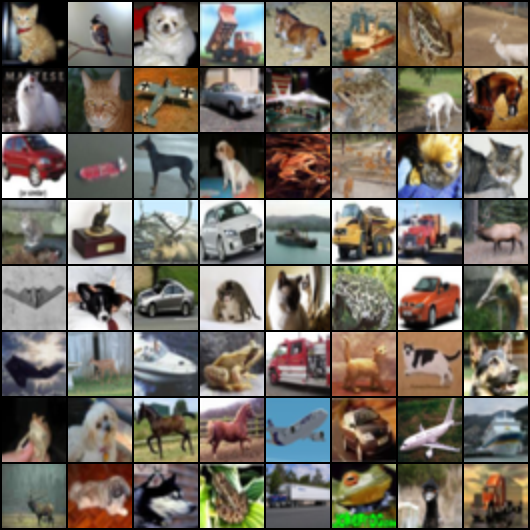

In [13]:
Image.open('output/real_samples.png')

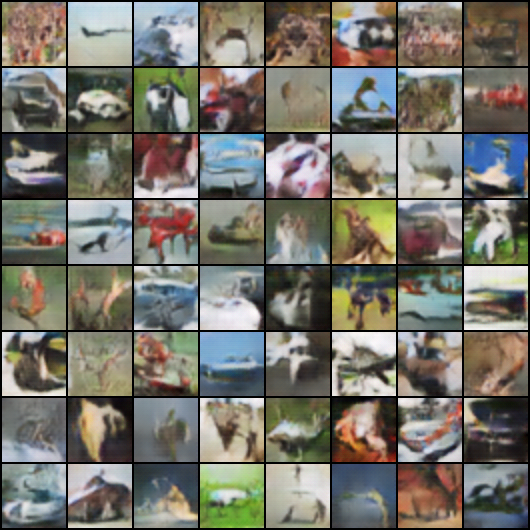

In [14]:
Image.open('output/fake_samples_epoch_024.png')